# Norm and Dir with WIDER
__efficientnetb3 -> b0__

In [1]:
from utils.loss_functions import DKDLoss
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from models_package.models import Teacher, Student
from torchvision import datasets, transforms, models
import models_package
import time
from datetime import datetime
import json
import random
import logging
from pathlib import Path
import argparse
import warnings
from torch.utils.tensorboard import SummaryWriter
import pdb
import time
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Subset, Dataset, DataLoader
from PIL import Image

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os
# new libraries
from data.data_loader import load_cifar10, load_cifar100, load_imagenet, load_prof
import boto3
import io
import models_package
from utils.loss_functions import DKDLoss, DirectNormLoss, KDLoss
from utils.compare_tools import compare_model_size, compare_inference_time, compare_performance_metrics, plot_comparison
from utils.misc_tools import colorstr, Save_Checkpoint, AverageMeter, epoch_loop_reviewkd
from utils.misc_tools import best_LR, best_LR_nd, best_LR_wider, train_teacher, train_teacher_wider, train_teacher_efficientnet, train_teacher_efficientnet_wider, retrieve_teacher_class_weights, new_teacher_class_weights


## Find best LR

In [2]:
# Hyperparameters
learning_rate = 0.003  # 0.01 for resnet34x2 & 0.1 for resnet8 & 0.003 for resnet 8x4
num_epochs = 240
num_workers = 2
batch_size = 64
temperature = 4.0
alpha = 0.9
momentum = 0.9
num_classes = 100
step_size = 30
gamma = 0.1

# new parameters
# lr_input = 0.1
# momentum_input = 0.9
weight_decay_input = 5e-4
# epochs = 20
# T = 4.0 # temperatureture
# alpha = 0.9
patience = 5  # for early stopping

In [3]:
torch.cuda.device_count()

1

## Load in Data

In [4]:
# Hyperparameters
learning_rate = 0.001 # 0.096779
epochs = 300
epochs_pretrain = 3
epochs_optimal_lr = 5
patience_teacher = 7
patience_student = 10
temperature = 4.0
alpha = 0.9
momentum = 0.9
step_size = 30
gamma = 0.1
batch_size = 32
num_workers = 4

# set to true to use stratified sampling
stratified_sampling_flag = False

# list of lambda values to loop through for grid search
lmda_list_student = [10,5,3,0.5,0]
lmda_list_teacher = [10,5,3,0.5,0]

# labels used including for plotting
class_labels = [0, 1, 3, 4, 6, 7, 11, 15, 17, 18, 19, 20, 22, 25, 27, 28, 30, 31, 33, 35, 36, 37, 39, 43, 44, 50, 51, 54, 57, 58]
class_labels_new = torch.tensor([i for i in range(len(class_labels))])
num_classes = 16
class_names_new = [f"Class {label}" for label in range(num_classes)]

# Create directory and file path to save all outputs
output_dir = f'./runs_{datetime.now().strftime("%Y_%m_%d_%H_%M")}'
os.makedirs(output_dir, exist_ok=True)

In [5]:
# set device to cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# Assuming your JSON file is named 'your_file.json'
file_path = './WIDER/Annotations/wider_attribute_trainval.json'

with open(file_path, 'r') as file:
    # Load the JSON data from the file
    data = json.load(file)

class_idx = data['scene_id_map']

In [7]:
new_label_mapping = {
    0: "Team_Sports",
    1: "Celebration",
    2: "Parade",
    3: "Waiter_Or_Waitress",
    4: "Individual_Sports",
    5: "Surgeons",
    6: "Spa",
    7: "Law_Enforcement",
    8: "Business",
    9: "Dresses",
    10: "Water_Activities",
    11: "Picnic",
    12: "Rescue",
    13: "Cheering",
    14: "Performance_And_Entertainment",
    15: "Family"
}

# Ensure that all 16 new classes are covered
# If some classes are not explicitly mentioned in new_label_mapping, add them
for i in range(num_classes):
    if i not in new_label_mapping:
        new_label_mapping[i] = "Additional Category {}".format(i)

class_idx = new_label_mapping

In [8]:
class StratifiedBatchSampler:
    """Stratified batch sampling
    Provides equal representation of target classes in each batch
    """
    def __init__(self, y, batch_size, shuffle=True):
        if torch.is_tensor(y):
            y = y.numpy()
        assert len(y.shape) == 1, 'label array must be 1D'
        n_batches = int(len(y) / batch_size)
        self.skf = StratifiedKFold(n_splits=n_batches, shuffle=shuffle)
        self.X = torch.randn(len(y),1).numpy()
        self.y = y
        self.shuffle = shuffle
        self.batch_size = batch_size

    def __iter__(self):
        if self.shuffle:
            self.skf.random_state = torch.randint(0,int(1e8),size=()).item()
        for train_idx, test_idx in self.skf.split(self.X, self.y):
            yield test_idx

    def __len__(self):
        return len(self.y)//self.batch_size

In [9]:
class DataSet(Dataset):
    def __init__(self, ann_files, augs, img_size, dataset):

        # Create a mapping from old labels to new labels
        self.label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted(class_labels))}

        self.new_label_mapping = {
            0: 2,  # Parade
            1: 8,  # Business
            2: 7,  # Law Enforcement
            3: 14,  # Performance and Entertainment
            4: 1,  # Celebration
            5: 13,  # Cheering
            6: 8,  # Business
            7: 8,  # Business
            8: 1,  # Celebration
            9: 14,  # Performance and Entertainment
            10: 15, # Family
            11: 15, # Family
            12: 11, # Picnic
            13: 7, # Law Enforcement
            14: 6, # Spa
            15: 13, # Cheering
            16: 5, # Surgeons
            17: 3, # Waiter or Waitress
            18: 4, # Individual Sports
            19: 0, # Team Sports
            20: 0, # Team Sports
            21: 0, # Team Sports
            22: 4, # Individual Sports
            23: 10, # Water Activities
            24: 4, # Individual Sports
            25: 1, # Celebration
            26: 9, # Dresses
            27: 12, # Rescue
            28: 10,# Water Activities
            29: 0  # Team Sports
        }

        
        self.dataset = dataset
        self.ann_files = ann_files
        self.augment = self.augs_function(augs, img_size)
        # Initialize transformations directly
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
            ] 
        )
        if self.dataset == "wider":
            self.transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                ] 
            )        

        self.anns = []
        self.load_anns()
        print(self.augment)

    def augs_function(self, augs, img_size):            
        t = []
        if 'randomflip' in augs:
            t.append(transforms.RandomHorizontalFlip())
        if 'ColorJitter' in augs:
            t.append(transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0))
        if 'resizedcrop' in augs:
            t.append(transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)))
        if 'RandAugment' in augs:
            t.append(transforms.RandAugment())

        t.append(transforms.Resize((img_size, img_size)))

        return transforms.Compose(t)
    
    def load_anns(self):
        self.anns = []
        for ann_file in self.ann_files:
            json_data = json.load(open(ann_file, "r"))
            self.anns += json_data

    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        # Make sure the index is within bounds
        idx = idx % len(self)
        ann = self.anns[idx]
        
        try:
            # Attempt to open the image file
            img = Image.open(f'WIDER/Image/{ann["file_name"]}').convert("RGB")

            # If this is the wider dataset, proceed with specific processing
            # x, y, w, h = ann['bbox']
            # img_area = img.crop([x, y, x+w, y+h])
            img_area = self.augment(img)
            img_area = self.transform(img_area)
            attributes_list = [target['attribute'] for target in ann['targets']]
            num_people = len(attributes_list)
            attributes_distribution = [max(sum(attribute), 0)/num_people for attribute in zip(*attributes_list)]
            # Extract label from image path
            img_path = f'WIDER/Image/{ann["file_name"]}'
            label = self.extract_label(img_path)  # You might need to implement this method
            
            return {
                "label": label,
                "target": torch.tensor([attributes_distribution[0]], dtype=torch.float32),
                "img": img_area
            }
            
        except Exception as e:
            # If any error occurs during the processing of an image, log the error and the index
            print(f"Error processing image at index {idx}: {e}")
            # Instead of returning None, raise the exception
            raise

    def extract_label(self, img_path):
        original_label = None
    
        if "WIDER/Image/train" in img_path:
            label_str = img_path.split("WIDER/Image/train/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/test" in img_path:
            label_str = img_path.split("WIDER/Image/test/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/val" in img_path:  # Handle validation images
            label_str = img_path.split("WIDER/Image/val/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
    
        if original_label is not None:
            remapped_label = self.label_mapping[original_label]
            new_label_mapping = self.new_label_mapping[remapped_label]
            return new_label_mapping
        else:
            raise ValueError(f"Label could not be extracted from path: {img_path}")


In [10]:
train_file = ['data/wider/trainval_wider.json']
test_file = ['data/wider/test_wider.json']


In [11]:
def custom_collate(batch):
    # Filter out any None items in the batch
    batch = [item for item in batch if item is not None]
    # If after filtering the batch is empty, handle this case by either returning an empty tensor or raising an exception
    if len(batch) == 0:
        raise ValueError("Batch is empty after filtering out None items.")
    return torch.utils.data.dataloader.default_collate(batch)


In [12]:
# train_dataset = DataSet(train_file, augs = ['RandAugment'], img_size = 226, dataset = 'wider')
train_dataset = DataSet(train_file, augs = [], img_size = 226, dataset = 'wider')
test_dataset = DataSet(test_file, augs = [], img_size = 226, dataset = 'wider')

if stratified_sampling_flag:
    trainloader = DataLoader(train_dataset, 
                             batch_sampler=StratifiedBatchSampler(torch.tensor([train_dataset[i]['label'] for i in range(len(train_dataset))]), 
                             batch_size=batch_size), num_workers=num_workers, collate_fn=custom_collate)
    testloader = DataLoader(test_dataset, batch_sampler=StratifiedBatchSampler(torch.tensor([test_dataset[i]['label'] for i in range(len(test_dataset))]), 
                             batch_size=batch_size), num_workers=num_workers, collate_fn=custom_collate)
else:
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=num_workers, collate_fn=custom_collate)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=custom_collate)

Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)
Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)


In [13]:
len(train_dataset)

10324

## Load in models

### efficientnet

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
##### HELPER FUNCTION FOR FEATURE EXTRACTION

def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

In [16]:
teacher_model = torchvision.models.efficientnet_b3(weights='DEFAULT')
teacher_model.our_classifier = nn.Linear(1536, num_classes)

# register the hook
# teacher_model.avgpool.register_forward_hook(get_features('feats'))
teacher_model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [17]:
student_model = torchvision.models.efficientnet_b0(weights='DEFAULT')
student_model.classifier = nn.Linear(1280, num_classes)

In [18]:
# # Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

# Optimizer and scheduler for the student model
student_optimizer = optim.SGD(student_model.parameters(), lr=learning_rate, momentum=momentum)
student_scheduler = torch.optim.lr_scheduler.StepLR(student_optimizer, step_size=step_size, gamma=gamma)


criterion = nn.CrossEntropyLoss()
# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
# ##### FEATURE EXTRACTION LOOP

# # placeholders
# PREDS = []
# FEATS = []

# # placeholder for batch features
# features = {}

# # loop through batches
# # for i, (inputs, labels) in enumerate(tqdm(trainloader)):
# for index, data in enumerate(tqdm(trainloader)):

#     # move to device
#     # inputs, labels = inputs.to(device), labels.to(device)
#     inputs = data['img'].to(device)
#     labels = data['label'].to(device)
       
#     # forward pass [with feature extraction]
#     preds = teacher_model(inputs)
#     feats = features['feats']
#     emb_feats = torch.flatten(feats, 1)
    
#     # add feats  to lists
#     # FEATS.append(features['feats'].cpu().numpy())

#     # early stop
#     if i == 9:
#         break

100%|██████████████████████████████████████████████████████████████████████████████████████| 323/323 [00:56<00:00,  5.70it/s]


## Best LR

In [23]:
def best_LR_here(save_name, model, trainloader, criterion, optimizer, scheduler, 
                num_epochs=5, emb = False, lr_range=(1e-4, 1e-1), plot_loss=True):
    def get_features(name):
        def hook(model, input, output):
            features[name] = output.detach()
        return hook
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.train()
    # create hook for feature embeddings
    model.to(device)
    model.avgpool.register_forward_hook(get_features('feats'))

    lr_values = np.logspace(np.log10(lr_range[0]), np.log10(lr_range[1]), num_epochs * len(trainloader))  # Generate learning rates for each batch
    lr_iter = iter(lr_values)
    losses = []
    lrs = []
    
    for epoch in range(num_epochs):
        features = {}
        for index, data in enumerate(tqdm(trainloader)):
            lr = next(lr_iter)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr  # Set new learning rate
            
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            # the Norm and Direction models give 2 outputs - feature embeddings and output
            if emb:
                outputs = model(inputs)
                feats = features['feats'].cpu().numpy()
                emb_feats = feats.flatten()

                
                # _, outputs = model(inputs)
            else:
                outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            lrs.append(lr)
    
    # Calculate the derivative of the loss
    loss_derivative = np.gradient(losses)
    
    # Find the learning rate corresponding to the minimum derivative (steepest decline)
    best_lr_index = np.argmin(loss_derivative)
    best_lr = lrs[best_lr_index]

    
    plot_path = './figs/LR/'
    os.makedirs(plot_path, exist_ok=True)
    plot_name = str(plot_path + save_name)

    
    if plot_loss:
        plt.figure()
        plt.plot(lrs, losses)
        plt.xscale('log')
        plt.xlabel('Learning Rate')
        plt.ylabel('Loss')
        plt.title('Learning Rate Range Test')
        plt.axvline(x=best_lr, color='red', linestyle='--', label=f'Best LR: {best_lr}')
        plt.legend()
        plt.savefig(plot_name, bbox_inches='tight')
        plt.show()
    
    print(f'Best learning rate: {best_lr}')
    return best_lr

100%|██████████████████████████████████████████████████████████████████████████████████████| 323/323 [01:48<00:00,  2.97it/s]


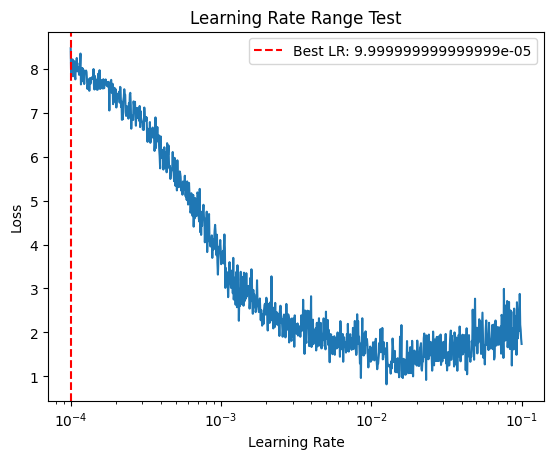

Best learning rate: 9.999999999999999e-05


9.999999999999999e-05

In [20]:
teacher_lr = best_LR_here('efficientnetb3_lr', teacher_model, trainloader, 
                     criterion, teacher_optimizer, 
                     teacher_scheduler, num_epochs=3, emb = True)
teacher_lr

100%|██████████████████████████████████████████████████████████████████████████████████████| 323/323 [00:58<00:00,  5.49it/s]


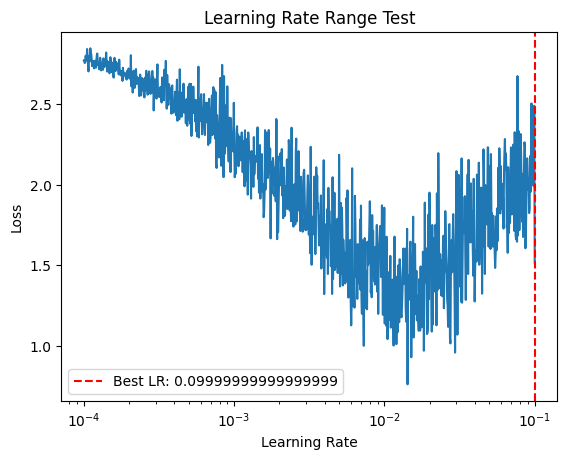

Best learning rate: 0.09999999999999999


0.09999999999999999

In [25]:
student_lr = best_LR_here('efficientnetb3_lr', student_model, trainloader, 
                     criterion, student_optimizer, 
                     student_scheduler, num_epochs=3, emb = False)
student_lr

In [19]:
teacher_lr = 9.999999999999999e-05
student_lr = 0.09999999999999999

## Train Leaderboard Teacher Models

100%|██████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:19<00:00,  5.66it/s]


*****Epoch 1/2*****
*****Train Loss:  4.051330 Val Loss:  2.252660*****
*****Validation Accuracy: 38.27%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:18<00:00,  6.03it/s]


*****Epoch 2/2*****
*****Train Loss:  1.648865 Val Loss:  1.469763*****
*****Validation Accuracy: 53.28%*****

Finished Training Teacher


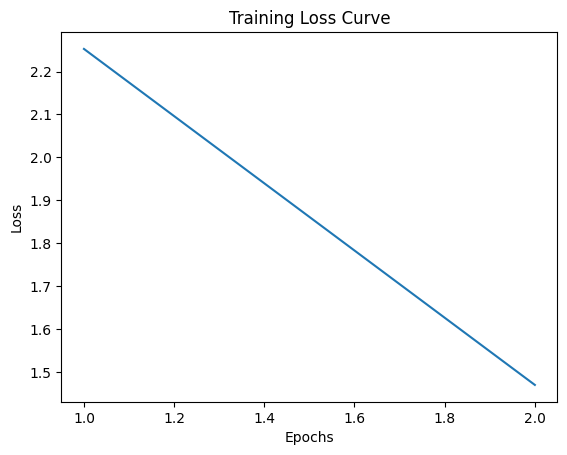

Training took 4.131804184118907 minutes


In [20]:
import time

start = time.time()

teacher_efficientnetb3 = train_teacher_efficientnet_wider('efficientnetb3/wider', teacher_model, trainloader, testloader, criterion, teacher_optimizer, teacher_scheduler, num_epochs=260, patience=5)

end = time.time()

print(f'Training took {(end - start) / 60} minutes')



In [21]:
## load saved model
PATH = './weights/efficientnetb3/wider/weights.pth'
teacher_model.load_state_dict(torch.load(PATH))
teacher_model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [22]:
###################### Saving weights and movel using s3 bucket ######################

session = boto3.session.Session()
s3 = session.client('s3')

bucket_name = '210bucket' 

# Teacher Model
#### IMPORTANT!!!!! Change the file name so that you do not overwrite the existing files
teacher_model_weights_path = 'weights/teacher_model_weights_efficientnetb3_wider.pth'
teacher_model_path = 'models/testing_teacher_model_efficientnetb3_wider.pth'

# Save state dict to buffer
teacher_model_weights_buffer = io.BytesIO()
torch.save(teacher_model.state_dict(), teacher_model_weights_buffer)
teacher_model_weights_buffer.seek(0)

# Save entire model to buffer
teacher_model_buffer = io.BytesIO()
torch.save(teacher_model, teacher_model_buffer)
teacher_model_buffer.seek(0)

# Upload to S3
s3.put_object(Bucket=bucket_name, Key=teacher_model_weights_path, Body=teacher_model_weights_buffer)
s3.put_object(Bucket=bucket_name, Key=teacher_model_path, Body=teacher_model_buffer)
print('teacher weights and architecture saved and exported to S3')

teacher weights and architecture saved and exported to S3


## Extract Class Embeddings

In [25]:
def get_emb_fea(model, dataloader, batch_size):
    ''' Used to extract the feature embeddings in a teacher model '''
    
    def get_features(name):
        def hook(model, input, output):
            features[name] = output.detach()
        return hook

    
    model.eval()
    model.avgpool.register_forward_hook(get_features('feats'))

    EMB = {}


    with torch.no_grad():
        for index, data in enumerate(tqdm(trainloader)):
            FEATS = []
            features = {}
            
            inputs = data['img'].to(device)
            labels = data['label'].to(device)

            curr_batch_size = len(inputs)

            # compute output
            # emb_fea, logits = model(images, embed=True)
            outputs = model(inputs)
            # feats = features['feats'].cpu().numpy()
            # emb_fea = feats.flatten()
            FEATS.append(features['feats'].cpu().numpy())
            emb_fea = np.concatenate(FEATS)
            # reshape embedding features to flatten 
            emb_fea = emb_fea.reshape((curr_batch_size, emb_fea.shape[1]))


            for emb, i in zip(emb_fea, labels):
                i = i.item()
                emb_size = len(emb) 
                if str(i) in EMB:
                    for j in range(emb_size):
                        EMB[str(i)][j].append(round(emb[j].item(), 4))
                else:
                    EMB[str(i)] = [[] for _ in range(emb_size)]
                    for j in range(emb_size):
                        EMB[str(i)][j].append(round(emb[j].item(), 4))

    for key, value in EMB.items():
        for i in range(emb_size):
            EMB[key][i] = round(np.array(EMB[key][i]).mean(), 4)

    return EMB


def retrieve_teacher_class_weights(model_name, model, model_weight_path, num_class, data_name, dataloader, batch_size, bucket_name):
    ''' Use the extracted feature embeddings to create a json of class means for teacher'''

    session = boto3.session.Session()
    s3 = session.client('s3')

    teacher_model_weights_buffer = io.BytesIO()
    s3.download_fileobj(bucket_name, model_weight_path, teacher_model_weights_buffer)
    teacher_model_weights_buffer.seek(0)  

    # Load the model
    # model = models_package.__dict__[model_name](num_class=num_class)
    checkpoint = torch.load(teacher_model_weights_buffer)
    # print("Keys in checkpoint:", checkpoint.keys())
    print("model is loaded properly")

    new_state_dict = OrderedDict()
    for k, v in checkpoint.items():
        name = k[7:] if k.startswith('module.') else k
        new_state_dict[name] = v
    model.load_state_dict(new_state_dict)
    model.eval()

    for param in model.parameters():
        param.requires_grad = False
    
    model = model.cuda()

    # emb = get_emb_fea(model=model, dataloader=dataloader, batch_size=batch_size)
    # emb_json = json.dumps(emb, indent=4)
    # with open("./class_means/{}_embedding_fea/{}.json".format(data_name, model_name), 'w', encoding='utf-8') as f:
    #     f.write(emb_json)

    emb = get_emb_fea(model=model, dataloader=dataloader, batch_size=batch_size)
    emb_json = json.dumps(emb, indent=4)

    # Create the directory if it doesn't exist
    output_dir = "./class_means/{}_embedding_fea".format(data_name)
    os.makedirs(output_dir, exist_ok=True)

    with open("{}/{}.json".format(output_dir, model_name), 'w', encoding='utf-8') as f:
        f.write(emb_json)

In [26]:
from pathlib import Path
from collections import OrderedDict
import os, shutil

data_name = 'WIDER'
retrieve_teacher_class_weights('efficientnetb3', teacher_model, teacher_model_weights_path, num_classes, data_name, testloader, batch_size, bucket_name)


model is loaded properly


100%|██████████████████████████████████████████████████████████████████████████████████████| 323/323 [01:09<00:00,  4.68it/s]


# Knowledge Distillation 

In [45]:
## Training script

def train(model, teacher, T_EMB, train_dataloader, optimizer, criterion, kd_loss, nd_loss, epoch, batch_size):

    def get_features(name):
        def hook(model, input, output):
            features[name] = output.detach()
        return hook
    
    train_loss = AverageMeter()
    train_error = AverageMeter()

    Cls_loss = AverageMeter()
    Div_loss = AverageMeter()
    Norm_Dir_loss = AverageMeter()

    # test T_EMB
    T_EMB = T_EMB

    # Model on train mode
    model.train()
    teacher.eval()
 
    step_per_epoch = len(train_dataloader)

    for step, data in enumerate(tqdm(train_dataloader)):
        
        start = time.time()
        s_FEATS = []
        features = {}

        inputs = data['img'].to(device)
        labels = data['label'].to(device)

        curr_batch_size = len(inputs)

        # compute output
        # emb_fea, logits = model(images, embed=True)
        model.avgpool.register_forward_hook(get_features('feats'))

        s_logits = model(inputs)

        s_FEATS.append(features['feats'].cpu().numpy())
        s_emb = np.concatenate(s_FEATS)
        # print(f'before reshaping s_emb: {s_emb.shape}')
        # reshape embedding features to flatten 
        s_emb = s_emb.reshape((curr_batch_size, s_emb.shape[1]))
        s_emb = torch.from_numpy(s_emb)
        s_emb = s_emb.to(device)

        # fix embedding output on student model
        s_emb_size = 1280
        t_emb_size = 1536
        
        emb_inflate = nn.Sequential(
            nn.BatchNorm1d(s_emb_size),
            nn.Dropout(0.5),
            nn.Linear(s_emb_size, t_emb_size)
            )
        # # clean_model
        for m in model.modules():
            if isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
    
        ##
        emb_inflate.to(device)

        s_emb = emb_inflate(s_emb)
        # model.fc1.to(device)
        
        # s_emb = model.fc1(s_emb)

        with torch.no_grad():
                        
            ####
            
            t_FEATS = []
            features = {}
    
            # compute output
            # emb_fea, logits = model(images, embed=True)
            teacher.avgpool.register_forward_hook(get_features('feats'))
            
            t_logits = model(inputs)
    
            t_FEATS.append(features['feats'].cpu().numpy())
            t_emb = np.concatenate(t_FEATS)
            # reshape embedding features to flatten 
            t_emb = t_emb.reshape((curr_batch_size, t_emb.shape[1]))


        ## save s_emb and t_emb as torch tensors 
        # s_emb = torch.from_numpy(s_emb)
        t_emb = torch.from_numpy(t_emb)

        # s_emb = s_emb.to(device)
        t_emb = t_emb.to(device)


        # print(s_emb.size() == s_emb.size())
        # print(s_emb.size())
        # print(s_emb.size())
        
        ###

        # cls loss
        cls_loss = criterion(s_logits, labels) * cls_loss_factor
        # KD loss
        div_loss = kd_loss(s_out = s_logits, t_out = t_logits) * min(1.0, epoch/warm_up)
        # ND loss
        norm_dir_loss = nd_loss(s_emb=s_emb, t_emb=t_emb, T_EMB=T_EMB, labels=labels)

        loss = cls_loss + div_loss + norm_dir_loss
        # measure accuracy and record loss
        batch_size = inputs.size(0)
        _, pred = s_logits.data.cpu().topk(1, dim=1)
        train_error.update(torch.ne(pred.squeeze(), labels.cpu()).float().sum().item() / batch_size, batch_size)
        train_loss.update(loss.item(), batch_size)

        Cls_loss.update(cls_loss.item(), batch_size)
        Div_loss.update(div_loss.item(), batch_size)
        Norm_Dir_loss.update(norm_dir_loss.item(), batch_size)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        t = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))
        s1 = '\r{} [{}/{}]'.format(t, step+1, step_per_epoch)
        s2 = ' - {:.2f}ms/step - nd_loss: {:.3f} - kd_loss: {:.3f} - cls_loss: {:.3f} - train_loss: {:.3f} - train_acc: {:.3f}'.format(
             1000 * (time.time() - start), norm_dir_loss.item(), div_loss.item(), cls_loss.item(), train_loss.val, 1-train_error.val)

        print(s1+s2, end='', flush=True)

    print()
    return Norm_Dir_loss.avg, Div_loss.avg, Cls_loss.avg, train_loss.avg, train_error.avg


def test(model, test_dataloader, criterion):
    test_loss = AverageMeter()
    test_error = AverageMeter()

    # Model on eval mode
    model.eval()


    with torch.no_grad():
        for step, data in enumerate(tqdm(test_dataloader)):

            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            # compute logits
            logits = model(inputs)

            loss = criterion(logits, labels)

            # measure accuracy and record loss
            batch_size = inputs.size(0)
            _, pred = logits.data.cpu().topk(1, dim=1)
            test_error.update(torch.ne(pred.squeeze(), labels.cpu()).float().sum().item() / batch_size, batch_size)
            test_loss.update(loss.item(), batch_size)

    return test_loss.avg, test_error.avg


def epoch_loop(model, teacher, train_loader, test_loader, num_class, T_EMB, save_dir, batch_size, logger):

    device = "cuda" if torch.cuda.is_available() else "cpu"
    # model = nn.DataParallel(model, device_ids=args.gpus)
    # model = nn.DataParallel(model)
    model = model
    model.to(device)
    # teacher = nn.DataParallel(teacher, device_ids=args.gpus)
    # teacher = nn.DataParallel(teacher)
    teacher = teacher
    teacher.to(device)

    # model.avgpool.register_forward_hook(get_features('s_feats'))
    # teacher.avgpool.register_forward_hook(get_features('t_feats'))

    # loss
    criterion = nn.CrossEntropyLoss().to(device)
    kd_loss = KDLoss(kl_loss_factor=kd_loss_factor, T=t).to(device)
    nd_loss = DirectNormLoss(num_class=num_class, nd_loss_factor=nd_loss_factor).to(device)
    # optimizer
    optimizer = torch.optim.SGD(params=model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay, nesterov=True)

    # weights
    save_dir = Path(save_dir)
    weights = save_dir / 'weights'
    weights.mkdir(parents=True, exist_ok=True)
    last = weights / 'last'
    best = weights / 'best'

    # acc,loss
    acc_loss = save_dir / 'acc_loss'
    acc_loss.mkdir(parents=True, exist_ok=True)

    train_acc_savepath = acc_loss / 'train_acc.npy'
    train_loss_savepath = acc_loss / 'train_loss.npy'
    val_acc_savepath = acc_loss / 'val_acc.npy'
    val_loss_savepath = acc_loss / 'val_loss.npy'

    # tensorboard
    logdir = save_dir / 'logs'
    logdir.mkdir(parents=True, exist_ok=True)
    summary_writer = SummaryWriter(logdir, flush_secs=120)


    start_epoch = 0
    best_error = 0
    train_acc = []
    train_loss = []
    test_acc = []
    test_loss = []

    logger = logger

    # Train model
    best_error = 1
    for epoch in range(start_epoch, epochs):
        if epoch in [150, 180, 210]:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.1
        print("Epoch {}/{}".format(epoch + 1, epochs))
        norm_dir_loss, div_loss, cls_loss, train_epoch_loss, train_error = train(model=model,
                                                                                 teacher=teacher,
                                                                                 T_EMB=T_EMB,
                                                                                 train_dataloader=train_loader,
                                                                                 optimizer=optimizer,
                                                                                 criterion=criterion,
                                                                                 kd_loss=kd_loss,
                                                                                 nd_loss=nd_loss,
                                                                                 epoch=epoch,
                                                                                 batch_size = batch_size)
        test_epoch_loss, test_error = test(model=model,
                                           test_dataloader=test_loader,
                                           criterion=criterion)

        s = "Train Loss: {:.3f}, Train Acc: {:.3f}, Test Loss: {:.3f}, Test Acc: {:.3f}, lr: {:.5f}".format(
            train_epoch_loss, 1-train_error, test_epoch_loss, 1-test_error, optimizer.param_groups[0]['lr'])
        logger.info(colorstr('green', s))

        # save acc,loss
        train_loss.append(train_epoch_loss)
        train_acc.append(1-train_error)
        test_loss.append(test_epoch_loss)
        test_acc.append(1-test_error)

        # save model
        is_best = test_error < best_error
        best_error = min(best_error, test_error)
        state = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_error': best_error,
                'train_acc': train_acc,
                'train_loss': train_loss,
                'test_acc': test_acc,
                'test_loss': test_loss,
            }

        last_path = last / 'epoch_{}_loss_{:.3f}_acc_{:.3f}'.format(
            epoch + 1, test_epoch_loss, 1-test_error)
        best_path = best / 'epoch_{}_acc_{:.3f}'.format(
                epoch + 1, 1-best_error)

        Save_Checkpoint(state, last, last_path, best, best_path, is_best)

        # tensorboard
        if epoch == 1:
            # images, labels = next(iter(train_loader))
            data = next(iter(train_loader))
            images = data['img'].to(device)
            labels = data['label'].to(device)

            img_grid = torchvision.utils.make_grid(images)
            summary_writer.add_image('Image', img_grid)
        summary_writer.add_scalar('lr', optimizer.param_groups[0]['lr'], epoch)
        summary_writer.add_scalar('train_loss', train_epoch_loss, epoch)
        summary_writer.add_scalar('train_error', train_error, epoch)
        summary_writer.add_scalar('val_loss', test_epoch_loss, epoch)
        summary_writer.add_scalar('val_error', test_error, epoch)

        summary_writer.add_scalar('nd_loss', norm_dir_loss, epoch)
        summary_writer.add_scalar('kd_loss', div_loss, epoch)
        summary_writer.add_scalar('cls_loss', cls_loss, epoch)

    summary_writer.close()
    import os
    if not os.path.exists(train_acc_savepath) or not os.path.exists(train_loss_savepath):
        np.save(train_acc_savepath, train_acc)
        np.save(train_loss_savepath, train_loss)
        np.save(val_acc_savepath, test_acc)
        np.save(val_loss_savepath, test_loss)


In [46]:
# set some params
workers = 8 # number of data loading workers
momentum = 0.9 # SGD momentum
cls_loss_factor =1.0 # cls loss weight factor
kd_loss_factor =1.0 #KD loss weight factor
t =4.0 #temperature
nd_loss_factor =1.0 # ND loss weight factor
warm_up=20.0 #loss weight warm up epochs
weight_decay = 5e-4 

def run_norm_and_dir_kd(save_dir, student_model, teacher_model, teacher_weights_path, num_class, epochs, batch_size, lr):
    
    logging.basicConfig(level=logging.INFO, format='%(asctime)s [line:%(lineno)d] %(message)s',
                        datefmt='%d %b %Y %H:%M:%S')
    logger = logging.getLogger(__name__)
    logger.info(colorstr('green', "Distribute train, total batch size:{}, epoch:{}".format(batch_size, epochs)))
 
    
    # load in models
    model = student_model
    
    teacher = teacher_model
    
    print('Load Teacher Weights')

    ###
    session = boto3.session.Session()
    s3 = session.client('s3')
    bucket_name = '210bucket' 

    teacher_model_weights_buffer = io.BytesIO()
    s3.download_fileobj(bucket_name, teacher_weights_path, teacher_model_weights_buffer)
    teacher_model_weights_buffer.seek(0)  

    # Load the model
    # model = models_package.__dict__[model_name](num_class=num_class)
    teacher_ckpt = torch.load(teacher_model_weights_buffer)
    teacher.load_state_dict(teacher_ckpt)
    # print("Keys in checkpoint:", teacher_ckpt.keys())
    print("model is loaded properly")

        
    # teacher_ckpt = torch.load(teacher_weights)['model']
    # teacher.load_state_dict(teacher_ckpt)

    for param in teacher.parameters():
        param.requires_grad = False

    ## get teacher class mean embeddings
    with open("./class_means/WIDER_embedding_fea/efficientnetb3.json", 'r') as f:
        T_EMB = json.load(f)
    f.close()

    logger.info(colorstr('green', 'Use ' + 'efficientnetb3' + ' Training ' + 'efficientnetb0' + ' ...'))


    # Train the model
    epoch_loop(model=model, teacher=teacher, train_loader = trainloader, test_loader = testloader, num_class = num_classes, T_EMB = T_EMB, save_dir = save_dir, batch_size = batch_size, logger = logger)

    

In [47]:
save_dir = './run/WIDER/KD++'
# teacher_weights = './weights/efficientnetb3/weights.pth'
teacher_weights_path = 'weights/teacher_model_weights_efficientnetb3_wider.pth'
epochs = 260
lr = student_lr

start = time.time()

run_norm_and_dir_kd(save_dir, student_model, teacher_model, teacher_weights_path, num_classes, epochs, batch_size, lr)

end = time.time()

print(f'Training took {(end - start) / 60} minutes')

04 Dec 2023 04:05:38 [line:16] Distribute train, total batch size:32, epoch:2
04 Dec 2023 04:05:38 [line:1255] Found credentials in shared credentials file: ~/.aws/credentials


Load Teacher Weights


04 Dec 2023 04:05:38 [line:54] Use efficientnetb3 Training efficientnetb0 ...


model is loaded properly
Epoch 1/2


  0%|                                                                                                | 0/323 [00:00<?, ?it/s]

2023-12-04 04:05:39 [1/323] - 243.91ms/step - nd_loss: 0.999 - kd_loss: 0.000 - cls_loss: 1.844 - train_loss: 2.843 - train_acc: 0.406

  0%|▎                                                                                       | 1/323 [00:01<05:43,  1.07s/it]

2023-12-04 04:05:40 [2/323] - 205.57ms/step - nd_loss: 0.999 - kd_loss: 0.000 - cls_loss: 1.409 - train_loss: 2.409 - train_acc: 0.531

  1%|▌                                                                                       | 2/323 [00:01<03:14,  1.65it/s]

2023-12-04 04:05:40 [3/323] - 215.01ms/step - nd_loss: 1.005 - kd_loss: 0.000 - cls_loss: 1.887 - train_loss: 2.892 - train_acc: 0.406

  1%|▊                                                                                       | 3/323 [00:01<02:29,  2.15it/s]

2023-12-04 04:05:40 [4/323] - 221.00ms/step - nd_loss: 0.998 - kd_loss: 0.000 - cls_loss: 1.628 - train_loss: 2.627 - train_acc: 0.500

  1%|█                                                                                       | 4/323 [00:01<02:10,  2.45it/s]

2023-12-04 04:05:40 [5/323] - 190.34ms/step - nd_loss: 0.994 - kd_loss: 0.000 - cls_loss: 1.573 - train_loss: 2.568 - train_acc: 0.500

  2%|█▎                                                                                      | 5/323 [00:02<01:54,  2.77it/s]

2023-12-04 04:05:41 [6/323] - 186.99ms/step - nd_loss: 0.997 - kd_loss: 0.000 - cls_loss: 1.916 - train_loss: 2.912 - train_acc: 0.438

  2%|█▋                                                                                      | 6/323 [00:02<01:44,  3.02it/s]

2023-12-04 04:05:41 [7/323] - 174.36ms/step - nd_loss: 0.998 - kd_loss: 0.000 - cls_loss: 1.599 - train_loss: 2.597 - train_acc: 0.469

  2%|█▉                                                                                      | 7/323 [00:02<01:38,  3.22it/s]

2023-12-04 04:05:41 [8/323] - 184.20ms/step - nd_loss: 0.996 - kd_loss: 0.000 - cls_loss: 1.647 - train_loss: 2.643 - train_acc: 0.531

  2%|██▏                                                                                     | 8/323 [00:03<01:33,  3.37it/s]

2023-12-04 04:05:41 [9/323] - 183.65ms/step - nd_loss: 0.999 - kd_loss: 0.000 - cls_loss: 1.703 - train_loss: 2.702 - train_acc: 0.500

  3%|██▍                                                                                     | 9/323 [00:03<01:30,  3.46it/s]

2023-12-04 04:05:42 [10/323] - 178.09ms/step - nd_loss: 0.999 - kd_loss: 0.000 - cls_loss: 1.801 - train_loss: 2.800 - train_acc: 0.438

  3%|██▋                                                                                    | 10/323 [00:03<01:28,  3.52it/s]

2023-12-04 04:05:42 [11/323] - 151.65ms/step - nd_loss: 0.999 - kd_loss: 0.000 - cls_loss: 1.543 - train_loss: 2.542 - train_acc: 0.562

  3%|██▉                                                                                    | 11/323 [00:03<01:24,  3.69it/s]

2023-12-04 04:05:42 [12/323] - 184.46ms/step - nd_loss: 0.997 - kd_loss: 0.000 - cls_loss: 1.661 - train_loss: 2.658 - train_acc: 0.438

  4%|███▏                                                                                   | 12/323 [00:04<01:24,  3.69it/s]

2023-12-04 04:05:43 [13/323] - 176.93ms/step - nd_loss: 0.998 - kd_loss: 0.000 - cls_loss: 1.757 - train_loss: 2.756 - train_acc: 0.438

  4%|███▌                                                                                   | 13/323 [00:04<01:23,  3.70it/s]

2023-12-04 04:05:43 [14/323] - 151.97ms/step - nd_loss: 0.997 - kd_loss: 0.000 - cls_loss: 1.270 - train_loss: 2.267 - train_acc: 0.688

  4%|███▊                                                                                   | 14/323 [00:04<01:21,  3.81it/s]

2023-12-04 04:05:43 [15/323] - 186.18ms/step - nd_loss: 0.998 - kd_loss: 0.000 - cls_loss: 1.501 - train_loss: 2.499 - train_acc: 0.562

  5%|████                                                                                   | 15/323 [00:04<01:21,  3.77it/s]

2023-12-04 04:05:43 [16/323] - 184.97ms/step - nd_loss: 1.009 - kd_loss: 0.000 - cls_loss: 1.990 - train_loss: 2.999 - train_acc: 0.312

  5%|████▎                                                                                  | 16/323 [00:05<01:22,  3.74it/s]

2023-12-04 04:05:44 [17/323] - 184.68ms/step - nd_loss: 1.010 - kd_loss: 0.000 - cls_loss: 1.846 - train_loss: 2.856 - train_acc: 0.406

  5%|████▌                                                                                  | 17/323 [00:05<01:22,  3.71it/s]

2023-12-04 04:05:44 [18/323] - 185.12ms/step - nd_loss: 1.001 - kd_loss: 0.000 - cls_loss: 1.911 - train_loss: 2.912 - train_acc: 0.406

  6%|████▊                                                                                  | 18/323 [00:05<01:22,  3.70it/s]

2023-12-04 04:05:44 [19/323] - 165.53ms/step - nd_loss: 1.001 - kd_loss: 0.000 - cls_loss: 1.700 - train_loss: 2.701 - train_acc: 0.438

  6%|█████                                                                                  | 19/323 [00:05<01:21,  3.75it/s]

2023-12-04 04:05:44 [20/323] - 177.09ms/step - nd_loss: 1.005 - kd_loss: 0.000 - cls_loss: 1.390 - train_loss: 2.394 - train_acc: 0.562

  6%|█████▍                                                                                 | 20/323 [00:06<01:21,  3.74it/s]

2023-12-04 04:05:45 [21/323] - 184.86ms/step - nd_loss: 0.993 - kd_loss: 0.000 - cls_loss: 1.981 - train_loss: 2.974 - train_acc: 0.469

  7%|█████▋                                                                                 | 21/323 [00:06<01:21,  3.72it/s]

2023-12-04 04:05:45 [22/323] - 183.34ms/step - nd_loss: 1.000 - kd_loss: 0.000 - cls_loss: 1.289 - train_loss: 2.289 - train_acc: 0.656

  7%|█████▉                                                                                 | 22/323 [00:06<01:21,  3.71it/s]

2023-12-04 04:05:45 [23/323] - 151.86ms/step - nd_loss: 1.003 - kd_loss: 0.000 - cls_loss: 1.613 - train_loss: 2.616 - train_acc: 0.500

  7%|██████▏                                                                                | 23/323 [00:07<01:18,  3.81it/s]

2023-12-04 04:05:45 [24/323] - 152.52ms/step - nd_loss: 0.994 - kd_loss: 0.000 - cls_loss: 1.686 - train_loss: 2.680 - train_acc: 0.438

  7%|██████▍                                                                                | 24/323 [00:07<01:16,  3.89it/s]

2023-12-04 04:05:46 [25/323] - 183.56ms/step - nd_loss: 0.999 - kd_loss: 0.000 - cls_loss: 1.547 - train_loss: 2.546 - train_acc: 0.531

  8%|██████▋                                                                                | 25/323 [00:07<01:17,  3.84it/s]

2023-12-04 04:05:46 [26/323] - 184.21ms/step - nd_loss: 1.005 - kd_loss: 0.000 - cls_loss: 1.769 - train_loss: 2.774 - train_acc: 0.469

  8%|███████                                                                                | 26/323 [00:07<01:18,  3.80it/s]

2023-12-04 04:05:46 [27/323] - 152.50ms/step - nd_loss: 1.000 - kd_loss: 0.000 - cls_loss: 1.432 - train_loss: 2.433 - train_acc: 0.562

  8%|███████▎                                                                               | 27/323 [00:08<01:16,  3.88it/s]

2023-12-04 04:05:46 [28/323] - 157.72ms/step - nd_loss: 1.003 - kd_loss: 0.000 - cls_loss: 1.880 - train_loss: 2.883 - train_acc: 0.438

  9%|███████▌                                                                               | 28/323 [00:08<01:15,  3.92it/s]

2023-12-04 04:05:47 [29/323] - 184.26ms/step - nd_loss: 0.994 - kd_loss: 0.000 - cls_loss: 2.059 - train_loss: 3.053 - train_acc: 0.531

  9%|███████▊                                                                               | 29/323 [00:08<01:16,  3.84it/s]

2023-12-04 04:05:47 [30/323] - 162.12ms/step - nd_loss: 1.001 - kd_loss: 0.000 - cls_loss: 1.644 - train_loss: 2.645 - train_acc: 0.531

  9%|████████                                                                               | 30/323 [00:08<01:15,  3.88it/s]

2023-12-04 04:05:47 [31/323] - 179.47ms/step - nd_loss: 0.998 - kd_loss: 0.000 - cls_loss: 1.424 - train_loss: 2.422 - train_acc: 0.469

 10%|████████▎                                                                              | 31/323 [00:09<01:16,  3.83it/s]

2023-12-04 04:05:48 [32/323] - 165.29ms/step - nd_loss: 1.003 - kd_loss: 0.000 - cls_loss: 1.895 - train_loss: 2.898 - train_acc: 0.375

 10%|████████▌                                                                              | 32/323 [00:09<01:15,  3.84it/s]

2023-12-04 04:05:48 [33/323] - 165.23ms/step - nd_loss: 1.000 - kd_loss: 0.000 - cls_loss: 1.699 - train_loss: 2.698 - train_acc: 0.469

 10%|████████▉                                                                              | 33/323 [00:09<01:15,  3.84it/s]

2023-12-04 04:05:48 [34/323] - 152.40ms/step - nd_loss: 1.002 - kd_loss: 0.000 - cls_loss: 1.699 - train_loss: 2.701 - train_acc: 0.469

 11%|█████████▏                                                                             | 34/323 [00:09<01:13,  3.91it/s]

2023-12-04 04:05:48 [35/323] - 153.88ms/step - nd_loss: 0.998 - kd_loss: 0.000 - cls_loss: 1.780 - train_loss: 2.778 - train_acc: 0.375

 11%|█████████▍                                                                             | 35/323 [00:10<01:12,  3.96it/s]

2023-12-04 04:05:49 [36/323] - 185.15ms/step - nd_loss: 0.996 - kd_loss: 0.000 - cls_loss: 1.900 - train_loss: 2.897 - train_acc: 0.375

 11%|█████████▋                                                                             | 36/323 [00:10<01:14,  3.86it/s]

2023-12-04 04:05:49 [37/323] - 185.19ms/step - nd_loss: 1.003 - kd_loss: 0.000 - cls_loss: 1.724 - train_loss: 2.727 - train_acc: 0.500

 11%|█████████▉                                                                             | 37/323 [00:10<01:14,  3.82it/s]

2023-12-04 04:05:49 [38/323] - 178.23ms/step - nd_loss: 0.998 - kd_loss: 0.000 - cls_loss: 1.524 - train_loss: 2.521 - train_acc: 0.562

 12%|██████████▏                                                                            | 38/323 [00:10<01:15,  3.78it/s]

2023-12-04 04:05:49 [39/323] - 161.70ms/step - nd_loss: 0.990 - kd_loss: 0.000 - cls_loss: 1.587 - train_loss: 2.577 - train_acc: 0.469

 12%|██████████▌                                                                            | 39/323 [00:11<01:13,  3.86it/s]

2023-12-04 04:05:50 [40/323] - 185.02ms/step - nd_loss: 0.999 - kd_loss: 0.000 - cls_loss: 2.020 - train_loss: 3.019 - train_acc: 0.375

 12%|██████████▊                                                                            | 40/323 [00:11<01:14,  3.81it/s]

2023-12-04 04:05:50 [41/323] - 176.58ms/step - nd_loss: 0.996 - kd_loss: 0.000 - cls_loss: 1.602 - train_loss: 2.598 - train_acc: 0.500

 13%|███████████                                                                            | 41/323 [00:11<01:14,  3.78it/s]

2023-12-04 04:05:50 [42/323] - 177.06ms/step - nd_loss: 1.003 - kd_loss: 0.000 - cls_loss: 1.443 - train_loss: 2.446 - train_acc: 0.562

 13%|███████████▎                                                                           | 42/323 [00:11<01:14,  3.75it/s]

2023-12-04 04:05:50 [43/323] - 185.17ms/step - nd_loss: 1.000 - kd_loss: 0.000 - cls_loss: 1.804 - train_loss: 2.805 - train_acc: 0.438

 13%|███████████▌                                                                           | 43/323 [00:12<01:15,  3.73it/s]

2023-12-04 04:05:51 [44/323] - 151.94ms/step - nd_loss: 1.001 - kd_loss: 0.000 - cls_loss: 1.793 - train_loss: 2.793 - train_acc: 0.406

 14%|███████████▊                                                                           | 44/323 [00:12<01:12,  3.83it/s]

2023-12-04 04:05:51 [45/323] - 154.73ms/step - nd_loss: 1.002 - kd_loss: 0.000 - cls_loss: 1.651 - train_loss: 2.653 - train_acc: 0.562

 14%|████████████                                                                           | 45/323 [00:12<01:11,  3.89it/s]

2023-12-04 04:05:51 [46/323] - 189.45ms/step - nd_loss: 0.998 - kd_loss: 0.000 - cls_loss: 1.806 - train_loss: 2.804 - train_acc: 0.312

 14%|████████████▍                                                                          | 46/323 [00:13<01:12,  3.80it/s]

2023-12-04 04:05:51 [47/323] - 160.77ms/step - nd_loss: 0.999 - kd_loss: 0.000 - cls_loss: 2.273 - train_loss: 3.272 - train_acc: 0.375

 15%|████████████▋                                                                          | 47/323 [00:13<01:11,  3.88it/s]

2023-12-04 04:05:52 [48/323] - 185.41ms/step - nd_loss: 1.005 - kd_loss: 0.000 - cls_loss: 1.768 - train_loss: 2.774 - train_acc: 0.438

 15%|████████████▉                                                                          | 48/323 [00:13<01:12,  3.82it/s]

2023-12-04 04:05:52 [49/323] - 152.95ms/step - nd_loss: 0.997 - kd_loss: 0.000 - cls_loss: 1.886 - train_loss: 2.882 - train_acc: 0.406

 15%|█████████████▏                                                                         | 49/323 [00:13<01:10,  3.90it/s]

2023-12-04 04:05:52 [50/323] - 152.60ms/step - nd_loss: 0.999 - kd_loss: 0.000 - cls_loss: 1.501 - train_loss: 2.500 - train_acc: 0.531

 15%|█████████████▍                                                                         | 50/323 [00:14<01:09,  3.96it/s]

2023-12-04 04:05:52 [51/323] - 185.37ms/step - nd_loss: 0.998 - kd_loss: 0.000 - cls_loss: 1.656 - train_loss: 2.654 - train_acc: 0.500

 16%|█████████████▋                                                                         | 51/323 [00:14<01:10,  3.85it/s]

2023-12-04 04:05:53 [52/323] - 185.69ms/step - nd_loss: 0.999 - kd_loss: 0.000 - cls_loss: 2.093 - train_loss: 3.092 - train_acc: 0.406

 16%|██████████████                                                                         | 52/323 [00:14<01:11,  3.79it/s]

2023-12-04 04:05:53 [53/323] - 178.29ms/step - nd_loss: 0.998 - kd_loss: 0.000 - cls_loss: 1.910 - train_loss: 2.907 - train_acc: 0.312

 16%|██████████████▎                                                                        | 53/323 [00:14<01:11,  3.76it/s]

2023-12-04 04:05:53 [54/323] - 177.94ms/step - nd_loss: 1.006 - kd_loss: 0.000 - cls_loss: 2.083 - train_loss: 3.089 - train_acc: 0.312

 17%|██████████████▌                                                                        | 54/323 [00:15<01:11,  3.74it/s]

2023-12-04 04:05:54 [55/323] - 184.10ms/step - nd_loss: 1.000 - kd_loss: 0.000 - cls_loss: 1.900 - train_loss: 2.900 - train_acc: 0.500

 17%|██████████████▊                                                                        | 55/323 [00:15<01:12,  3.72it/s]

2023-12-04 04:05:54 [56/323] - 186.75ms/step - nd_loss: 0.998 - kd_loss: 0.000 - cls_loss: 1.924 - train_loss: 2.923 - train_acc: 0.406

 17%|███████████████                                                                        | 56/323 [00:15<01:12,  3.70it/s]

2023-12-04 04:05:54 [57/323] - 167.04ms/step - nd_loss: 1.000 - kd_loss: 0.000 - cls_loss: 1.750 - train_loss: 2.750 - train_acc: 0.375

 18%|███████████████▎                                                                       | 57/323 [00:15<01:11,  3.73it/s]

2023-12-04 04:05:54 [58/323] - 163.63ms/step - nd_loss: 0.998 - kd_loss: 0.000 - cls_loss: 1.841 - train_loss: 2.839 - train_acc: 0.406

 18%|███████████████▌                                                                       | 58/323 [00:16<01:10,  3.77it/s]

2023-12-04 04:05:55 [59/323] - 177.59ms/step - nd_loss: 1.004 - kd_loss: 0.000 - cls_loss: 1.805 - train_loss: 2.809 - train_acc: 0.375

 18%|███████████████▉                                                                       | 59/323 [00:16<01:10,  3.75it/s]

2023-12-04 04:05:55 [60/323] - 184.57ms/step - nd_loss: 1.003 - kd_loss: 0.000 - cls_loss: 1.653 - train_loss: 2.655 - train_acc: 0.438

 19%|████████████████▏                                                                      | 60/323 [00:16<01:10,  3.72it/s]

2023-12-04 04:05:55 [61/323] - 161.40ms/step - nd_loss: 0.998 - kd_loss: 0.000 - cls_loss: 1.841 - train_loss: 2.839 - train_acc: 0.281

 19%|████████████████▍                                                                      | 61/323 [00:16<01:08,  3.81it/s]

2023-12-04 04:05:55 [62/323] - 176.33ms/step - nd_loss: 1.004 - kd_loss: 0.000 - cls_loss: 1.594 - train_loss: 2.598 - train_acc: 0.438

 19%|████████████████▋                                                                      | 62/323 [00:17<01:09,  3.77it/s]

2023-12-04 04:05:56 [63/323] - 184.44ms/step - nd_loss: 1.000 - kd_loss: 0.000 - cls_loss: 1.659 - train_loss: 2.659 - train_acc: 0.594

 20%|████████████████▉                                                                      | 63/323 [00:17<01:09,  3.75it/s]

2023-12-04 04:05:56 [64/323] - 184.38ms/step - nd_loss: 0.997 - kd_loss: 0.000 - cls_loss: 1.687 - train_loss: 2.684 - train_acc: 0.531

 20%|█████████████████▏                                                                     | 64/323 [00:17<01:09,  3.73it/s]

2023-12-04 04:05:56 [65/323] - 163.28ms/step - nd_loss: 1.003 - kd_loss: 0.000 - cls_loss: 1.617 - train_loss: 2.620 - train_acc: 0.531

 20%|█████████████████▌                                                                     | 65/323 [00:18<01:08,  3.78it/s]

2023-12-04 04:05:56 [66/323] - 177.52ms/step - nd_loss: 0.998 - kd_loss: 0.000 - cls_loss: 1.286 - train_loss: 2.284 - train_acc: 0.594

 20%|█████████████████▊                                                                     | 66/323 [00:18<01:08,  3.76it/s]

2023-12-04 04:05:57 [67/323] - 173.93ms/step - nd_loss: 0.999 - kd_loss: 0.000 - cls_loss: 2.089 - train_loss: 3.087 - train_acc: 0.406

 21%|██████████████████                                                                     | 67/323 [00:18<01:07,  3.77it/s]

2023-12-04 04:05:57 [68/323] - 186.15ms/step - nd_loss: 0.998 - kd_loss: 0.000 - cls_loss: 1.652 - train_loss: 2.650 - train_acc: 0.438

 21%|██████████████████▎                                                                    | 68/323 [00:18<01:08,  3.74it/s]

2023-12-04 04:05:57 [69/323] - 160.79ms/step - nd_loss: 1.001 - kd_loss: 0.000 - cls_loss: 1.636 - train_loss: 2.637 - train_acc: 0.375

 21%|██████████████████▌                                                                    | 69/323 [00:19<01:06,  3.82it/s]

2023-12-04 04:05:58 [70/323] - 185.33ms/step - nd_loss: 1.001 - kd_loss: 0.000 - cls_loss: 2.056 - train_loss: 3.057 - train_acc: 0.312

 22%|██████████████████▊                                                                    | 70/323 [00:19<01:06,  3.78it/s]

2023-12-04 04:05:58 [71/323] - 168.98ms/step - nd_loss: 1.005 - kd_loss: 0.000 - cls_loss: 1.594 - train_loss: 2.600 - train_acc: 0.531

 22%|███████████████████                                                                    | 71/323 [00:19<01:06,  3.79it/s]

2023-12-04 04:05:58 [72/323] - 180.16ms/step - nd_loss: 0.998 - kd_loss: 0.000 - cls_loss: 2.270 - train_loss: 3.268 - train_acc: 0.281

 22%|███████████████████▍                                                                   | 72/323 [00:19<01:06,  3.76it/s]

2023-12-04 04:05:58 [73/323] - 183.80ms/step - nd_loss: 1.000 - kd_loss: 0.000 - cls_loss: 1.618 - train_loss: 2.617 - train_acc: 0.531

 23%|███████████████████▋                                                                   | 73/323 [00:20<01:06,  3.74it/s]

2023-12-04 04:05:59 [74/323] - 169.98ms/step - nd_loss: 0.997 - kd_loss: 0.000 - cls_loss: 1.581 - train_loss: 2.578 - train_acc: 0.531

 23%|███████████████████▉                                                                   | 74/323 [00:20<01:06,  3.77it/s]

2023-12-04 04:05:59 [75/323] - 176.57ms/step - nd_loss: 0.997 - kd_loss: 0.000 - cls_loss: 1.810 - train_loss: 2.806 - train_acc: 0.406

 23%|████████████████████▏                                                                  | 75/323 [00:20<01:05,  3.76it/s]

2023-12-04 04:05:59 [76/323] - 184.02ms/step - nd_loss: 1.001 - kd_loss: 0.000 - cls_loss: 2.129 - train_loss: 3.130 - train_acc: 0.438

 24%|████████████████████▍                                                                  | 76/323 [00:20<01:06,  3.74it/s]

2023-12-04 04:05:59 [77/323] - 177.47ms/step - nd_loss: 1.002 - kd_loss: 0.000 - cls_loss: 1.885 - train_loss: 2.886 - train_acc: 0.406

 24%|████████████████████▋                                                                  | 77/323 [00:21<01:05,  3.74it/s]

2023-12-04 04:06:00 [78/323] - 161.27ms/step - nd_loss: 1.004 - kd_loss: 0.000 - cls_loss: 1.764 - train_loss: 2.768 - train_acc: 0.438

 24%|█████████████████████                                                                  | 78/323 [00:21<01:04,  3.83it/s]

2023-12-04 04:06:00 [79/323] - 185.71ms/step - nd_loss: 1.002 - kd_loss: 0.000 - cls_loss: 2.088 - train_loss: 3.090 - train_acc: 0.344

 24%|█████████████████████▎                                                                 | 79/323 [00:21<01:04,  3.78it/s]

2023-12-04 04:06:00 [80/323] - 157.49ms/step - nd_loss: 1.005 - kd_loss: 0.000 - cls_loss: 1.959 - train_loss: 2.964 - train_acc: 0.344

 25%|█████████████████████▌                                                                 | 80/323 [00:22<01:03,  3.85it/s]

2023-12-04 04:06:00 [81/323] - 185.34ms/step - nd_loss: 1.006 - kd_loss: 0.000 - cls_loss: 1.849 - train_loss: 2.855 - train_acc: 0.438

 25%|█████████████████████▊                                                                 | 81/323 [00:22<01:03,  3.79it/s]

2023-12-04 04:06:01 [82/323] - 154.15ms/step - nd_loss: 0.994 - kd_loss: 0.000 - cls_loss: 1.747 - train_loss: 2.741 - train_acc: 0.469

 25%|██████████████████████                                                                 | 82/323 [00:22<01:02,  3.87it/s]

2023-12-04 04:06:01 [83/323] - 186.08ms/step - nd_loss: 0.993 - kd_loss: 0.000 - cls_loss: 1.820 - train_loss: 2.814 - train_acc: 0.375

 26%|██████████████████████▎                                                                | 83/323 [00:22<01:03,  3.81it/s]

2023-12-04 04:06:01 [84/323] - 161.18ms/step - nd_loss: 0.992 - kd_loss: 0.000 - cls_loss: 1.850 - train_loss: 2.841 - train_acc: 0.406

 26%|██████████████████████▋                                                                | 84/323 [00:23<01:01,  3.88it/s]

2023-12-04 04:06:01 [85/323] - 184.44ms/step - nd_loss: 0.996 - kd_loss: 0.000 - cls_loss: 1.580 - train_loss: 2.576 - train_acc: 0.438

 26%|██████████████████████▉                                                                | 85/323 [00:23<01:02,  3.83it/s]

2023-12-04 04:06:02 [86/323] - 160.72ms/step - nd_loss: 1.003 - kd_loss: 0.000 - cls_loss: 1.755 - train_loss: 2.758 - train_acc: 0.594

 27%|███████████████████████▏                                                               | 86/323 [00:23<01:00,  3.90it/s]

2023-12-04 04:06:02 [87/323] - 186.37ms/step - nd_loss: 1.001 - kd_loss: 0.000 - cls_loss: 1.972 - train_loss: 2.973 - train_acc: 0.438

 27%|███████████████████████▍                                                               | 87/323 [00:23<01:01,  3.82it/s]

2023-12-04 04:06:02 [88/323] - 179.13ms/step - nd_loss: 1.000 - kd_loss: 0.000 - cls_loss: 1.845 - train_loss: 2.845 - train_acc: 0.344

 27%|███████████████████████▋                                                               | 88/323 [00:24<01:02,  3.79it/s]

2023-12-04 04:06:03 [89/323] - 160.61ms/step - nd_loss: 1.004 - kd_loss: 0.000 - cls_loss: 1.629 - train_loss: 2.633 - train_acc: 0.469

 28%|███████████████████████▉                                                               | 89/323 [00:24<01:00,  3.87it/s]

2023-12-04 04:06:03 [90/323] - 183.82ms/step - nd_loss: 1.011 - kd_loss: 0.000 - cls_loss: 1.874 - train_loss: 2.886 - train_acc: 0.312

 28%|████████████████████████▏                                                              | 90/323 [00:24<01:00,  3.82it/s]

2023-12-04 04:06:03 [91/323] - 161.16ms/step - nd_loss: 0.998 - kd_loss: 0.000 - cls_loss: 1.674 - train_loss: 2.672 - train_acc: 0.469

 28%|████████████████████████▌                                                              | 91/323 [00:24<00:59,  3.89it/s]

2023-12-04 04:06:03 [92/323] - 183.50ms/step - nd_loss: 1.001 - kd_loss: 0.000 - cls_loss: 1.164 - train_loss: 2.165 - train_acc: 0.688

 28%|████████████████████████▊                                                              | 92/323 [00:25<01:00,  3.83it/s]

2023-12-04 04:06:04 [93/323] - 168.77ms/step - nd_loss: 0.997 - kd_loss: 0.000 - cls_loss: 1.763 - train_loss: 2.760 - train_acc: 0.500

 29%|█████████████████████████                                                              | 93/323 [00:25<01:00,  3.82it/s]

2023-12-04 04:06:04 [94/323] - 185.91ms/step - nd_loss: 0.993 - kd_loss: 0.000 - cls_loss: 1.846 - train_loss: 2.839 - train_acc: 0.469

 29%|█████████████████████████▎                                                             | 94/323 [00:25<01:00,  3.77it/s]

2023-12-04 04:06:04 [95/323] - 159.93ms/step - nd_loss: 0.999 - kd_loss: 0.000 - cls_loss: 1.450 - train_loss: 2.449 - train_acc: 0.562

 29%|█████████████████████████▌                                                             | 95/323 [00:25<00:59,  3.85it/s]

2023-12-04 04:06:04 [96/323] - 175.99ms/step - nd_loss: 1.003 - kd_loss: 0.000 - cls_loss: 1.809 - train_loss: 2.812 - train_acc: 0.406

 30%|█████████████████████████▊                                                             | 96/323 [00:26<00:59,  3.81it/s]

2023-12-04 04:06:05 [97/323] - 184.00ms/step - nd_loss: 1.001 - kd_loss: 0.000 - cls_loss: 2.157 - train_loss: 3.159 - train_acc: 0.438

 30%|██████████████████████████▏                                                            | 97/323 [00:26<00:59,  3.77it/s]

2023-12-04 04:06:05 [98/323] - 184.13ms/step - nd_loss: 1.003 - kd_loss: 0.000 - cls_loss: 1.765 - train_loss: 2.768 - train_acc: 0.406

 30%|██████████████████████████▍                                                            | 98/323 [00:26<01:00,  3.75it/s]

2023-12-04 04:06:05 [99/323] - 164.29ms/step - nd_loss: 1.004 - kd_loss: 0.000 - cls_loss: 2.121 - train_loss: 3.125 - train_acc: 0.312

 31%|██████████████████████████▋                                                            | 99/323 [00:26<00:58,  3.83it/s]

2023-12-04 04:06:05 [100/323] - 185.83ms/step - nd_loss: 0.999 - kd_loss: 0.000 - cls_loss: 1.915 - train_loss: 2.913 - train_acc: 0.406

 31%|██████████████████████████▋                                                           | 100/323 [00:27<00:59,  3.77it/s]

2023-12-04 04:06:06 [101/323] - 162.37ms/step - nd_loss: 1.004 - kd_loss: 0.000 - cls_loss: 1.797 - train_loss: 2.801 - train_acc: 0.406

 31%|██████████████████████████▉                                                           | 101/323 [00:27<00:57,  3.85it/s]

2023-12-04 04:06:06 [102/323] - 161.46ms/step - nd_loss: 1.001 - kd_loss: 0.000 - cls_loss: 1.899 - train_loss: 2.900 - train_acc: 0.500

 32%|███████████████████████████▏                                                          | 102/323 [00:27<00:56,  3.91it/s]

2023-12-04 04:06:06 [103/323] - 187.34ms/step - nd_loss: 1.003 - kd_loss: 0.000 - cls_loss: 1.709 - train_loss: 2.712 - train_acc: 0.438

 32%|███████████████████████████▍                                                          | 103/323 [00:28<00:57,  3.84it/s]

2023-12-04 04:06:06 [104/323] - 177.93ms/step - nd_loss: 1.001 - kd_loss: 0.000 - cls_loss: 1.461 - train_loss: 2.462 - train_acc: 0.469

 32%|███████████████████████████▋                                                          | 104/323 [00:28<00:57,  3.80it/s]

2023-12-04 04:06:07 [105/323] - 184.28ms/step - nd_loss: 1.005 - kd_loss: 0.000 - cls_loss: 1.603 - train_loss: 2.608 - train_acc: 0.500

 33%|███████████████████████████▉                                                          | 105/323 [00:28<00:57,  3.76it/s]

2023-12-04 04:06:07 [106/323] - 178.46ms/step - nd_loss: 0.994 - kd_loss: 0.000 - cls_loss: 1.936 - train_loss: 2.930 - train_acc: 0.312

 33%|████████████████████████████▏                                                         | 106/323 [00:28<00:57,  3.75it/s]

2023-12-04 04:06:07 [107/323] - 161.79ms/step - nd_loss: 0.998 - kd_loss: 0.000 - cls_loss: 1.676 - train_loss: 2.675 - train_acc: 0.406

 33%|████████████████████████████▍                                                         | 107/323 [00:29<00:56,  3.83it/s]

2023-12-04 04:06:08 [108/323] - 185.20ms/step - nd_loss: 1.002 - kd_loss: 0.000 - cls_loss: 1.758 - train_loss: 2.761 - train_acc: 0.406

 33%|████████████████████████████▊                                                         | 108/323 [00:29<00:56,  3.78it/s]

2023-12-04 04:06:08 [109/323] - 166.43ms/step - nd_loss: 0.999 - kd_loss: 0.000 - cls_loss: 1.442 - train_loss: 2.441 - train_acc: 0.531

 34%|█████████████████████████████                                                         | 109/323 [00:29<00:56,  3.80it/s]

2023-12-04 04:06:08 [110/323] - 176.83ms/step - nd_loss: 0.992 - kd_loss: 0.000 - cls_loss: 2.296 - train_loss: 3.288 - train_acc: 0.312

 34%|█████████████████████████████▎                                                        | 110/323 [00:29<00:56,  3.78it/s]

2023-12-04 04:06:08 [111/323] - 183.91ms/step - nd_loss: 0.998 - kd_loss: 0.000 - cls_loss: 1.808 - train_loss: 2.806 - train_acc: 0.500

 34%|█████████████████████████████▌                                                        | 111/323 [00:30<00:56,  3.74it/s]

2023-12-04 04:06:09 [112/323] - 160.25ms/step - nd_loss: 1.002 - kd_loss: 0.000 - cls_loss: 1.505 - train_loss: 2.507 - train_acc: 0.531

 35%|█████████████████████████████▊                                                        | 112/323 [00:30<00:55,  3.84it/s]

2023-12-04 04:06:09 [113/323] - 184.35ms/step - nd_loss: 0.996 - kd_loss: 0.000 - cls_loss: 1.895 - train_loss: 2.891 - train_acc: 0.406

 35%|██████████████████████████████                                                        | 113/323 [00:30<00:55,  3.80it/s]

2023-12-04 04:06:09 [114/323] - 186.19ms/step - nd_loss: 0.994 - kd_loss: 0.000 - cls_loss: 1.747 - train_loss: 2.740 - train_acc: 0.469

 35%|██████████████████████████████▎                                                       | 114/323 [00:30<00:55,  3.76it/s]

2023-12-04 04:06:09 [115/323] - 184.18ms/step - nd_loss: 0.994 - kd_loss: 0.000 - cls_loss: 2.043 - train_loss: 3.037 - train_acc: 0.438

 36%|██████████████████████████████▌                                                       | 115/323 [00:31<00:55,  3.73it/s]

2023-12-04 04:06:10 [116/323] - 161.47ms/step - nd_loss: 1.007 - kd_loss: 0.000 - cls_loss: 2.137 - train_loss: 3.144 - train_acc: 0.406

 36%|██████████████████████████████▉                                                       | 116/323 [00:31<00:54,  3.83it/s]

2023-12-04 04:06:10 [117/323] - 160.73ms/step - nd_loss: 0.999 - kd_loss: 0.000 - cls_loss: 1.746 - train_loss: 2.746 - train_acc: 0.469

 36%|███████████████████████████████▏                                                      | 117/323 [00:31<00:52,  3.90it/s]

2023-12-04 04:06:10 [118/323] - 184.85ms/step - nd_loss: 1.003 - kd_loss: 0.000 - cls_loss: 1.521 - train_loss: 2.524 - train_acc: 0.500

 37%|███████████████████████████████▍                                                      | 118/323 [00:31<00:53,  3.82it/s]

2023-12-04 04:06:10 [119/323] - 161.64ms/step - nd_loss: 1.002 - kd_loss: 0.000 - cls_loss: 2.425 - train_loss: 3.427 - train_acc: 0.250

 37%|███████████████████████████████▋                                                      | 119/323 [00:32<00:52,  3.89it/s]

2023-12-04 04:06:11 [120/323] - 187.46ms/step - nd_loss: 1.003 - kd_loss: 0.000 - cls_loss: 1.774 - train_loss: 2.777 - train_acc: 0.500

 37%|███████████████████████████████▉                                                      | 120/323 [00:32<00:53,  3.82it/s]

2023-12-04 04:06:11 [121/323] - 165.40ms/step - nd_loss: 1.002 - kd_loss: 0.000 - cls_loss: 1.430 - train_loss: 2.432 - train_acc: 0.469

 37%|████████████████████████████████▏                                                     | 121/323 [00:32<00:52,  3.83it/s]

2023-12-04 04:06:11 [122/323] - 172.09ms/step - nd_loss: 0.994 - kd_loss: 0.000 - cls_loss: 1.807 - train_loss: 2.801 - train_acc: 0.344

 38%|████████████████████████████████▍                                                     | 122/323 [00:33<00:52,  3.81it/s]

2023-12-04 04:06:11 [123/323] - 177.82ms/step - nd_loss: 0.994 - kd_loss: 0.000 - cls_loss: 1.948 - train_loss: 2.942 - train_acc: 0.375

 38%|████████████████████████████████▋                                                     | 123/323 [00:33<00:52,  3.78it/s]

2023-12-04 04:06:12 [124/323] - 184.78ms/step - nd_loss: 0.996 - kd_loss: 0.000 - cls_loss: 1.695 - train_loss: 2.691 - train_acc: 0.375

 38%|█████████████████████████████████                                                     | 124/323 [00:33<00:53,  3.75it/s]

2023-12-04 04:06:12 [125/323] - 174.82ms/step - nd_loss: 0.999 - kd_loss: 0.000 - cls_loss: 1.596 - train_loss: 2.595 - train_acc: 0.406

 39%|█████████████████████████████████▎                                                    | 125/323 [00:33<00:52,  3.75it/s]

2023-12-04 04:06:12 [126/323] - 174.66ms/step - nd_loss: 1.001 - kd_loss: 0.000 - cls_loss: 1.707 - train_loss: 2.708 - train_acc: 0.344

 39%|█████████████████████████████████▌                                                    | 126/323 [00:34<00:52,  3.74it/s]

2023-12-04 04:06:13 [127/323] - 179.74ms/step - nd_loss: 1.002 - kd_loss: 0.000 - cls_loss: 1.535 - train_loss: 2.537 - train_acc: 0.469

 39%|█████████████████████████████████▊                                                    | 127/323 [00:34<00:52,  3.73it/s]

2023-12-04 04:06:13 [128/323] - 163.92ms/step - nd_loss: 1.001 - kd_loss: 0.000 - cls_loss: 1.552 - train_loss: 2.553 - train_acc: 0.531

 40%|██████████████████████████████████                                                    | 128/323 [00:34<00:51,  3.78it/s]

2023-12-04 04:06:13 [129/323] - 183.33ms/step - nd_loss: 1.006 - kd_loss: 0.000 - cls_loss: 1.439 - train_loss: 2.445 - train_acc: 0.594

 40%|██████████████████████████████████▎                                                   | 129/323 [00:34<00:51,  3.76it/s]

2023-12-04 04:06:13 [130/323] - 180.56ms/step - nd_loss: 1.000 - kd_loss: 0.000 - cls_loss: 1.671 - train_loss: 2.671 - train_acc: 0.344

 40%|██████████████████████████████████▌                                                   | 130/323 [00:35<00:51,  3.73it/s]

2023-12-04 04:06:14 [131/323] - 184.41ms/step - nd_loss: 1.001 - kd_loss: 0.000 - cls_loss: 1.950 - train_loss: 2.951 - train_acc: 0.438

 41%|██████████████████████████████████▉                                                   | 131/323 [00:35<00:51,  3.72it/s]

2023-12-04 04:06:14 [132/323] - 152.07ms/step - nd_loss: 0.998 - kd_loss: 0.000 - cls_loss: 1.847 - train_loss: 2.844 - train_acc: 0.500

 41%|███████████████████████████████████▏                                                  | 132/323 [00:35<00:50,  3.82it/s]

2023-12-04 04:06:14 [133/323] - 151.63ms/step - nd_loss: 1.000 - kd_loss: 0.000 - cls_loss: 2.127 - train_loss: 3.127 - train_acc: 0.375

 41%|███████████████████████████████████▍                                                  | 133/323 [00:35<00:48,  3.88it/s]

2023-12-04 04:06:14 [134/323] - 184.25ms/step - nd_loss: 1.003 - kd_loss: 0.000 - cls_loss: 1.700 - train_loss: 2.703 - train_acc: 0.531

 41%|███████████████████████████████████▋                                                  | 134/323 [00:36<00:49,  3.82it/s]

2023-12-04 04:06:15 [135/323] - 161.57ms/step - nd_loss: 1.001 - kd_loss: 0.000 - cls_loss: 1.554 - train_loss: 2.554 - train_acc: 0.500

 42%|███████████████████████████████████▉                                                  | 135/323 [00:36<00:48,  3.88it/s]

2023-12-04 04:06:15 [136/323] - 186.61ms/step - nd_loss: 1.003 - kd_loss: 0.000 - cls_loss: 1.611 - train_loss: 2.614 - train_acc: 0.562

 42%|████████████████████████████████████▏                                                 | 136/323 [00:36<00:49,  3.81it/s]

2023-12-04 04:06:15 [137/323] - 184.47ms/step - nd_loss: 1.006 - kd_loss: 0.000 - cls_loss: 1.607 - train_loss: 2.613 - train_acc: 0.500

 42%|████████████████████████████████████▍                                                 | 137/323 [00:36<00:49,  3.78it/s]

2023-12-04 04:06:15 [138/323] - 161.95ms/step - nd_loss: 1.001 - kd_loss: 0.000 - cls_loss: 1.999 - train_loss: 3.001 - train_acc: 0.438

 43%|████████████████████████████████████▋                                                 | 138/323 [00:37<00:48,  3.85it/s]

2023-12-04 04:06:16 [139/323] - 182.62ms/step - nd_loss: 1.005 - kd_loss: 0.000 - cls_loss: 1.863 - train_loss: 2.868 - train_acc: 0.438

 43%|█████████████████████████████████████                                                 | 139/323 [00:37<00:48,  3.81it/s]

2023-12-04 04:06:16 [140/323] - 177.69ms/step - nd_loss: 1.005 - kd_loss: 0.000 - cls_loss: 2.224 - train_loss: 3.229 - train_acc: 0.406

 43%|█████████████████████████████████████▎                                                | 140/323 [00:37<00:48,  3.78it/s]

2023-12-04 04:06:16 [141/323] - 181.58ms/step - nd_loss: 0.997 - kd_loss: 0.000 - cls_loss: 1.652 - train_loss: 2.648 - train_acc: 0.500

 44%|█████████████████████████████████████▌                                                | 141/323 [00:38<00:48,  3.76it/s]

2023-12-04 04:06:16 [142/323] - 177.73ms/step - nd_loss: 0.996 - kd_loss: 0.000 - cls_loss: 1.687 - train_loss: 2.683 - train_acc: 0.469

 44%|█████████████████████████████████████▊                                                | 142/323 [00:38<00:48,  3.74it/s]

2023-12-04 04:06:17 [143/323] - 185.19ms/step - nd_loss: 1.002 - kd_loss: 0.000 - cls_loss: 2.129 - train_loss: 3.131 - train_acc: 0.406

 44%|██████████████████████████████████████                                                | 143/323 [00:38<00:48,  3.71it/s]

2023-12-04 04:06:17 [144/323] - 164.28ms/step - nd_loss: 1.003 - kd_loss: 0.000 - cls_loss: 1.835 - train_loss: 2.838 - train_acc: 0.375

 45%|██████████████████████████████████████▎                                               | 144/323 [00:38<00:47,  3.76it/s]

2023-12-04 04:06:17 [145/323] - 183.44ms/step - nd_loss: 1.001 - kd_loss: 0.000 - cls_loss: 1.830 - train_loss: 2.832 - train_acc: 0.469

 45%|██████████████████████████████████████▌                                               | 145/323 [00:39<00:47,  3.74it/s]

2023-12-04 04:06:18 [146/323] - 172.46ms/step - nd_loss: 0.996 - kd_loss: 0.000 - cls_loss: 1.814 - train_loss: 2.811 - train_acc: 0.531

 45%|██████████████████████████████████████▊                                               | 146/323 [00:39<00:46,  3.77it/s]

2023-12-04 04:06:18 [147/323] - 178.79ms/step - nd_loss: 0.997 - kd_loss: 0.000 - cls_loss: 1.881 - train_loss: 2.878 - train_acc: 0.406

 46%|███████████████████████████████████████▏                                              | 147/323 [00:39<00:46,  3.75it/s]

2023-12-04 04:06:18 [148/323] - 187.14ms/step - nd_loss: 0.999 - kd_loss: 0.000 - cls_loss: 2.017 - train_loss: 3.016 - train_acc: 0.406

 46%|███████████████████████████████████████▍                                              | 148/323 [00:39<00:47,  3.72it/s]

2023-12-04 04:06:18 [149/323] - 177.13ms/step - nd_loss: 0.993 - kd_loss: 0.000 - cls_loss: 2.111 - train_loss: 3.104 - train_acc: 0.281

 46%|███████████████████████████████████████▋                                              | 149/323 [00:40<00:46,  3.72it/s]

2023-12-04 04:06:19 [150/323] - 184.01ms/step - nd_loss: 1.001 - kd_loss: 0.000 - cls_loss: 2.009 - train_loss: 3.010 - train_acc: 0.375

 46%|███████████████████████████████████████▉                                              | 150/323 [00:40<00:46,  3.70it/s]

2023-12-04 04:06:19 [151/323] - 170.51ms/step - nd_loss: 1.005 - kd_loss: 0.000 - cls_loss: 1.996 - train_loss: 3.001 - train_acc: 0.344

 47%|████████████████████████████████████████▏                                             | 151/323 [00:40<00:46,  3.73it/s]

2023-12-04 04:06:19 [152/323] - 180.22ms/step - nd_loss: 0.999 - kd_loss: 0.000 - cls_loss: 1.616 - train_loss: 2.614 - train_acc: 0.500

 47%|████████████████████████████████████████▍                                             | 152/323 [00:41<00:46,  3.71it/s]

2023-12-04 04:06:19 [153/323] - 186.20ms/step - nd_loss: 0.996 - kd_loss: 0.000 - cls_loss: 1.693 - train_loss: 2.688 - train_acc: 0.531

 47%|████████████████████████████████████████▋                                             | 153/323 [00:41<00:46,  3.69it/s]

2023-12-04 04:06:20 [154/323] - 158.99ms/step - nd_loss: 0.994 - kd_loss: 0.000 - cls_loss: 1.852 - train_loss: 2.846 - train_acc: 0.375

 48%|█████████████████████████████████████████                                             | 154/323 [00:41<00:44,  3.79it/s]

2023-12-04 04:06:20 [155/323] - 166.81ms/step - nd_loss: 0.998 - kd_loss: 0.000 - cls_loss: 1.992 - train_loss: 2.990 - train_acc: 0.312

 48%|█████████████████████████████████████████▎                                            | 155/323 [00:41<00:44,  3.74it/s]

2023-12-04 04:06:20 [156/323] - 183.81ms/step - nd_loss: 1.003 - kd_loss: 0.000 - cls_loss: 1.814 - train_loss: 2.817 - train_acc: 0.469

 48%|█████████████████████████████████████████▌                                            | 156/323 [00:42<00:44,  3.71it/s]

2023-12-04 04:06:21 [157/323] - 186.82ms/step - nd_loss: 0.996 - kd_loss: 0.000 - cls_loss: 1.888 - train_loss: 2.884 - train_acc: 0.375

 49%|█████████████████████████████████████████▊                                            | 157/323 [00:42<00:44,  3.70it/s]

2023-12-04 04:06:21 [158/323] - 182.32ms/step - nd_loss: 1.000 - kd_loss: 0.000 - cls_loss: 1.882 - train_loss: 2.882 - train_acc: 0.438

 49%|██████████████████████████████████████████                                            | 158/323 [00:42<00:44,  3.70it/s]

2023-12-04 04:06:21 [159/323] - 168.07ms/step - nd_loss: 1.001 - kd_loss: 0.000 - cls_loss: 1.911 - train_loss: 2.912 - train_acc: 0.344

 49%|██████████████████████████████████████████▎                                           | 159/323 [00:42<00:43,  3.74it/s]

2023-12-04 04:06:21 [160/323] - 178.98ms/step - nd_loss: 1.003 - kd_loss: 0.000 - cls_loss: 1.472 - train_loss: 2.476 - train_acc: 0.562

 50%|██████████████████████████████████████████▌                                           | 160/323 [00:43<00:43,  3.73it/s]

2023-12-04 04:06:22 [161/323] - 183.63ms/step - nd_loss: 1.000 - kd_loss: 0.000 - cls_loss: 1.575 - train_loss: 2.575 - train_acc: 0.469

 50%|██████████████████████████████████████████▊                                           | 161/323 [00:43<00:43,  3.71it/s]

2023-12-04 04:06:22 [162/323] - 177.79ms/step - nd_loss: 1.002 - kd_loss: 0.000 - cls_loss: 1.855 - train_loss: 2.857 - train_acc: 0.406

 50%|███████████████████████████████████████████▏                                          | 162/323 [00:43<00:43,  3.71it/s]

2023-12-04 04:06:22 [163/323] - 160.69ms/step - nd_loss: 1.002 - kd_loss: 0.000 - cls_loss: 1.939 - train_loss: 2.942 - train_acc: 0.438

 50%|███████████████████████████████████████████▍                                          | 163/323 [00:43<00:42,  3.81it/s]

2023-12-04 04:06:22 [164/323] - 186.34ms/step - nd_loss: 1.007 - kd_loss: 0.000 - cls_loss: 1.840 - train_loss: 2.847 - train_acc: 0.469

 51%|███████████████████████████████████████████▋                                          | 164/323 [00:44<00:42,  3.77it/s]

2023-12-04 04:06:23 [165/323] - 176.91ms/step - nd_loss: 1.000 - kd_loss: 0.000 - cls_loss: 1.879 - train_loss: 2.878 - train_acc: 0.406

 51%|███████████████████████████████████████████▉                                          | 165/323 [00:44<00:42,  3.76it/s]

2023-12-04 04:06:23 [166/323] - 176.55ms/step - nd_loss: 0.994 - kd_loss: 0.000 - cls_loss: 2.390 - train_loss: 3.384 - train_acc: 0.281

 51%|████████████████████████████████████████████▏                                         | 166/323 [00:44<00:41,  3.74it/s]

2023-12-04 04:06:23 [167/323] - 160.88ms/step - nd_loss: 1.005 - kd_loss: 0.000 - cls_loss: 1.951 - train_loss: 2.955 - train_acc: 0.406

 52%|████████████████████████████████████████████▍                                         | 167/323 [00:44<00:40,  3.83it/s]

2023-12-04 04:06:23 [168/323] - 160.40ms/step - nd_loss: 0.999 - kd_loss: 0.000 - cls_loss: 1.946 - train_loss: 2.945 - train_acc: 0.438

 52%|████████████████████████████████████████████▋                                         | 168/323 [00:45<00:39,  3.90it/s]

2023-12-04 04:06:24 [169/323] - 184.35ms/step - nd_loss: 0.999 - kd_loss: 0.000 - cls_loss: 1.960 - train_loss: 2.959 - train_acc: 0.406

 52%|████████████████████████████████████████████▉                                         | 169/323 [00:45<00:40,  3.83it/s]

2023-12-04 04:06:24 [170/323] - 169.89ms/step - nd_loss: 1.006 - kd_loss: 0.000 - cls_loss: 1.560 - train_loss: 2.565 - train_acc: 0.531

 53%|█████████████████████████████████████████████▎                                        | 170/323 [00:45<00:40,  3.82it/s]

2023-12-04 04:06:24 [171/323] - 180.68ms/step - nd_loss: 1.004 - kd_loss: 0.000 - cls_loss: 1.747 - train_loss: 2.750 - train_acc: 0.594

 53%|█████████████████████████████████████████████▌                                        | 171/323 [00:46<00:40,  3.78it/s]

2023-12-04 04:06:24 [172/323] - 178.30ms/step - nd_loss: 1.002 - kd_loss: 0.000 - cls_loss: 2.303 - train_loss: 3.305 - train_acc: 0.219

 53%|█████████████████████████████████████████████▊                                        | 172/323 [00:46<00:40,  3.76it/s]

2023-12-04 04:06:25 [173/323] - 184.10ms/step - nd_loss: 1.001 - kd_loss: 0.000 - cls_loss: 1.824 - train_loss: 2.825 - train_acc: 0.438

 54%|██████████████████████████████████████████████                                        | 173/323 [00:46<00:40,  3.74it/s]

2023-12-04 04:06:25 [174/323] - 152.48ms/step - nd_loss: 0.996 - kd_loss: 0.000 - cls_loss: 2.153 - train_loss: 3.149 - train_acc: 0.344

 54%|██████████████████████████████████████████████▎                                       | 174/323 [00:46<00:38,  3.84it/s]

2023-12-04 04:06:25 [175/323] - 152.44ms/step - nd_loss: 0.994 - kd_loss: 0.000 - cls_loss: 1.730 - train_loss: 2.724 - train_acc: 0.438

 54%|██████████████████████████████████████████████▌                                       | 175/323 [00:47<00:37,  3.91it/s]

2023-12-04 04:06:26 [176/323] - 185.87ms/step - nd_loss: 0.997 - kd_loss: 0.000 - cls_loss: 1.714 - train_loss: 2.710 - train_acc: 0.469

 54%|██████████████████████████████████████████████▊                                       | 176/323 [00:47<00:38,  3.84it/s]

2023-12-04 04:06:26 [177/323] - 160.57ms/step - nd_loss: 1.000 - kd_loss: 0.000 - cls_loss: 1.766 - train_loss: 2.767 - train_acc: 0.438

 55%|███████████████████████████████████████████████▏                                      | 177/323 [00:47<00:37,  3.90it/s]

2023-12-04 04:06:26 [178/323] - 184.34ms/step - nd_loss: 1.003 - kd_loss: 0.000 - cls_loss: 2.077 - train_loss: 3.080 - train_acc: 0.250

 55%|███████████████████████████████████████████████▍                                      | 178/323 [00:47<00:37,  3.84it/s]

2023-12-04 04:06:26 [179/323] - 160.80ms/step - nd_loss: 1.003 - kd_loss: 0.000 - cls_loss: 2.238 - train_loss: 3.242 - train_acc: 0.438

 55%|███████████████████████████████████████████████▋                                      | 179/323 [00:48<00:36,  3.90it/s]

2023-12-04 04:06:27 [180/323] - 184.65ms/step - nd_loss: 0.998 - kd_loss: 0.000 - cls_loss: 2.035 - train_loss: 3.032 - train_acc: 0.344

 56%|███████████████████████████████████████████████▉                                      | 180/323 [00:48<00:37,  3.84it/s]

2023-12-04 04:06:27 [181/323] - 161.54ms/step - nd_loss: 0.996 - kd_loss: 0.000 - cls_loss: 1.653 - train_loss: 2.649 - train_acc: 0.500

 56%|████████████████████████████████████████████████▏                                     | 181/323 [00:48<00:36,  3.90it/s]

2023-12-04 04:06:27 [182/323] - 152.95ms/step - nd_loss: 1.004 - kd_loss: 0.000 - cls_loss: 1.662 - train_loss: 2.666 - train_acc: 0.500

 56%|████████████████████████████████████████████████▍                                     | 182/323 [00:48<00:35,  3.95it/s]

2023-12-04 04:06:27 [183/323] - 154.18ms/step - nd_loss: 0.996 - kd_loss: 0.000 - cls_loss: 1.979 - train_loss: 2.974 - train_acc: 0.375

 57%|████████████████████████████████████████████████▋                                     | 183/323 [00:49<00:35,  3.98it/s]

2023-12-04 04:06:28 [184/323] - 182.20ms/step - nd_loss: 1.000 - kd_loss: 0.000 - cls_loss: 1.789 - train_loss: 2.788 - train_acc: 0.469

 57%|████████████████████████████████████████████████▉                                     | 184/323 [00:49<00:35,  3.88it/s]

2023-12-04 04:06:28 [185/323] - 179.95ms/step - nd_loss: 1.001 - kd_loss: 0.000 - cls_loss: 1.694 - train_loss: 2.695 - train_acc: 0.469

 57%|█████████████████████████████████████████████████▎                                    | 185/323 [00:49<00:36,  3.82it/s]

2023-12-04 04:06:28 [186/323] - 185.58ms/step - nd_loss: 1.001 - kd_loss: 0.000 - cls_loss: 2.257 - train_loss: 3.258 - train_acc: 0.250

 58%|█████████████████████████████████████████████████▌                                    | 186/323 [00:49<00:36,  3.78it/s]

2023-12-04 04:06:28 [187/323] - 166.53ms/step - nd_loss: 0.999 - kd_loss: 0.000 - cls_loss: 2.042 - train_loss: 3.041 - train_acc: 0.375

 58%|█████████████████████████████████████████████████▊                                    | 187/323 [00:50<00:35,  3.80it/s]

2023-12-04 04:06:29 [188/323] - 185.30ms/step - nd_loss: 1.000 - kd_loss: 0.000 - cls_loss: 1.771 - train_loss: 2.771 - train_acc: 0.344

 58%|██████████████████████████████████████████████████                                    | 188/323 [00:50<00:35,  3.76it/s]

2023-12-04 04:06:29 [189/323] - 161.19ms/step - nd_loss: 0.997 - kd_loss: 0.000 - cls_loss: 1.583 - train_loss: 2.580 - train_acc: 0.469

 59%|██████████████████████████████████████████████████▎                                   | 189/323 [00:50<00:34,  3.85it/s]

2023-12-04 04:06:29 [190/323] - 161.55ms/step - nd_loss: 1.002 - kd_loss: 0.000 - cls_loss: 1.813 - train_loss: 2.815 - train_acc: 0.438

 59%|██████████████████████████████████████████████████▌                                   | 190/323 [00:50<00:34,  3.91it/s]

2023-12-04 04:06:29 [191/323] - 152.05ms/step - nd_loss: 1.001 - kd_loss: 0.000 - cls_loss: 1.963 - train_loss: 2.964 - train_acc: 0.406

 59%|██████████████████████████████████████████████████▊                                   | 191/323 [00:51<00:33,  3.96it/s]

2023-12-04 04:06:30 [192/323] - 184.42ms/step - nd_loss: 1.001 - kd_loss: 0.000 - cls_loss: 1.623 - train_loss: 2.623 - train_acc: 0.438

 59%|███████████████████████████████████████████████████                                   | 192/323 [00:51<00:33,  3.85it/s]

2023-12-04 04:06:30 [193/323] - 161.57ms/step - nd_loss: 1.007 - kd_loss: 0.000 - cls_loss: 1.886 - train_loss: 2.893 - train_acc: 0.344

 60%|███████████████████████████████████████████████████▍                                  | 193/323 [00:51<00:33,  3.90it/s]

2023-12-04 04:06:30 [194/323] - 184.91ms/step - nd_loss: 1.000 - kd_loss: 0.000 - cls_loss: 1.668 - train_loss: 2.668 - train_acc: 0.469

 60%|███████████████████████████████████████████████████▋                                  | 194/323 [00:52<00:33,  3.84it/s]

2023-12-04 04:06:30 [195/323] - 153.26ms/step - nd_loss: 0.998 - kd_loss: 0.000 - cls_loss: 2.116 - train_loss: 3.114 - train_acc: 0.344

 60%|███████████████████████████████████████████████████▉                                  | 195/323 [00:52<00:32,  3.89it/s]

2023-12-04 04:06:31 [196/323] - 184.07ms/step - nd_loss: 1.002 - kd_loss: 0.000 - cls_loss: 1.459 - train_loss: 2.462 - train_acc: 0.562

 61%|████████████████████████████████████████████████████▏                                 | 196/323 [00:52<00:33,  3.83it/s]

2023-12-04 04:06:31 [197/323] - 178.27ms/step - nd_loss: 1.002 - kd_loss: 0.000 - cls_loss: 1.653 - train_loss: 2.654 - train_acc: 0.438

 61%|████████████████████████████████████████████████████▍                                 | 197/323 [00:52<00:33,  3.80it/s]

2023-12-04 04:06:31 [198/323] - 152.99ms/step - nd_loss: 0.997 - kd_loss: 0.000 - cls_loss: 1.928 - train_loss: 2.925 - train_acc: 0.312

 61%|████████████████████████████████████████████████████▋                                 | 198/323 [00:53<00:32,  3.87it/s]

2023-12-04 04:06:31 [199/323] - 184.38ms/step - nd_loss: 1.001 - kd_loss: 0.000 - cls_loss: 1.819 - train_loss: 2.820 - train_acc: 0.438

 62%|████████████████████████████████████████████████████▉                                 | 199/323 [00:53<00:32,  3.81it/s]

2023-12-04 04:06:32 [200/323] - 180.96ms/step - nd_loss: 0.998 - kd_loss: 0.000 - cls_loss: 1.836 - train_loss: 2.834 - train_acc: 0.469

 62%|█████████████████████████████████████████████████████▎                                | 200/323 [00:53<00:32,  3.77it/s]

2023-12-04 04:06:32 [201/323] - 175.68ms/step - nd_loss: 0.998 - kd_loss: 0.000 - cls_loss: 1.731 - train_loss: 2.729 - train_acc: 0.500

 62%|█████████████████████████████████████████████████████▌                                | 201/323 [00:53<00:32,  3.76it/s]

2023-12-04 04:06:32 [202/323] - 176.35ms/step - nd_loss: 0.997 - kd_loss: 0.000 - cls_loss: 2.211 - train_loss: 3.208 - train_acc: 0.250

 63%|█████████████████████████████████████████████████████▊                                | 202/323 [00:54<00:32,  3.75it/s]

2023-12-04 04:06:33 [203/323] - 184.17ms/step - nd_loss: 1.002 - kd_loss: 0.000 - cls_loss: 2.089 - train_loss: 3.091 - train_acc: 0.312

 63%|██████████████████████████████████████████████████████                                | 203/323 [00:54<00:32,  3.73it/s]

2023-12-04 04:06:33 [204/323] - 152.80ms/step - nd_loss: 1.000 - kd_loss: 0.000 - cls_loss: 1.977 - train_loss: 2.977 - train_acc: 0.188

 63%|██████████████████████████████████████████████████████▎                               | 204/323 [00:54<00:31,  3.83it/s]

2023-12-04 04:06:33 [205/323] - 184.79ms/step - nd_loss: 1.008 - kd_loss: 0.000 - cls_loss: 2.016 - train_loss: 3.024 - train_acc: 0.406

 63%|██████████████████████████████████████████████████████▌                               | 205/323 [00:54<00:31,  3.78it/s]

2023-12-04 04:06:33 [206/323] - 178.12ms/step - nd_loss: 0.999 - kd_loss: 0.000 - cls_loss: 1.987 - train_loss: 2.986 - train_acc: 0.469

 64%|██████████████████████████████████████████████████████▊                               | 206/323 [00:55<00:31,  3.76it/s]

2023-12-04 04:06:34 [207/323] - 161.37ms/step - nd_loss: 1.002 - kd_loss: 0.000 - cls_loss: 2.022 - train_loss: 3.024 - train_acc: 0.344

 64%|███████████████████████████████████████████████████████                               | 207/323 [00:55<00:30,  3.84it/s]

2023-12-04 04:06:34 [208/323] - 162.72ms/step - nd_loss: 1.005 - kd_loss: 0.000 - cls_loss: 1.815 - train_loss: 2.820 - train_acc: 0.375

 64%|███████████████████████████████████████████████████████▍                              | 208/323 [00:55<00:29,  3.88it/s]

2023-12-04 04:06:34 [209/323] - 185.43ms/step - nd_loss: 0.993 - kd_loss: 0.000 - cls_loss: 1.944 - train_loss: 2.937 - train_acc: 0.312

 65%|███████████████████████████████████████████████████████▋                              | 209/323 [00:55<00:29,  3.81it/s]

2023-12-04 04:06:34 [210/323] - 164.09ms/step - nd_loss: 1.000 - kd_loss: 0.000 - cls_loss: 1.752 - train_loss: 2.752 - train_acc: 0.500

 65%|███████████████████████████████████████████████████████▉                              | 210/323 [00:56<00:29,  3.82it/s]

2023-12-04 04:06:35 [211/323] - 185.14ms/step - nd_loss: 1.001 - kd_loss: 0.000 - cls_loss: 1.621 - train_loss: 2.622 - train_acc: 0.438

 65%|████████████████████████████████████████████████████████▏                             | 211/323 [00:56<00:29,  3.78it/s]

2023-12-04 04:06:35 [212/323] - 163.55ms/step - nd_loss: 1.001 - kd_loss: 0.000 - cls_loss: 1.696 - train_loss: 2.697 - train_acc: 0.469

 66%|████████████████████████████████████████████████████████▍                             | 212/323 [00:56<00:29,  3.81it/s]

2023-12-04 04:06:35 [213/323] - 183.09ms/step - nd_loss: 1.004 - kd_loss: 0.000 - cls_loss: 1.527 - train_loss: 2.532 - train_acc: 0.500

 66%|████████████████████████████████████████████████████████▋                             | 213/323 [00:57<00:29,  3.78it/s]

2023-12-04 04:06:35 [214/323] - 187.81ms/step - nd_loss: 0.999 - kd_loss: 0.000 - cls_loss: 1.955 - train_loss: 2.953 - train_acc: 0.469

 66%|████████████████████████████████████████████████████████▉                             | 214/323 [00:57<00:29,  3.74it/s]

2023-12-04 04:06:36 [215/323] - 171.91ms/step - nd_loss: 1.005 - kd_loss: 0.000 - cls_loss: 1.674 - train_loss: 2.679 - train_acc: 0.438

 67%|█████████████████████████████████████████████████████████▏                            | 215/323 [00:57<00:28,  3.75it/s]

2023-12-04 04:06:36 [216/323] - 167.37ms/step - nd_loss: 0.997 - kd_loss: 0.000 - cls_loss: 1.623 - train_loss: 2.620 - train_acc: 0.469

 67%|█████████████████████████████████████████████████████████▌                            | 216/323 [00:57<00:28,  3.77it/s]

2023-12-04 04:06:36 [217/323] - 185.48ms/step - nd_loss: 1.006 - kd_loss: 0.000 - cls_loss: 1.843 - train_loss: 2.848 - train_acc: 0.344

 67%|█████████████████████████████████████████████████████████▊                            | 217/323 [00:58<00:28,  3.74it/s]

2023-12-04 04:06:36 [218/323] - 160.54ms/step - nd_loss: 1.002 - kd_loss: 0.000 - cls_loss: 1.653 - train_loss: 2.655 - train_acc: 0.500

 67%|██████████████████████████████████████████████████████████                            | 218/323 [00:58<00:27,  3.80it/s]

2023-12-04 04:06:37 [219/323] - 168.77ms/step - nd_loss: 1.004 - kd_loss: 0.000 - cls_loss: 1.719 - train_loss: 2.723 - train_acc: 0.438

 68%|██████████████████████████████████████████████████████████▎                           | 219/323 [00:58<00:27,  3.80it/s]

2023-12-04 04:06:37 [220/323] - 176.85ms/step - nd_loss: 0.993 - kd_loss: 0.000 - cls_loss: 2.219 - train_loss: 3.212 - train_acc: 0.344

 68%|██████████████████████████████████████████████████████████▌                           | 220/323 [00:58<00:27,  3.78it/s]

2023-12-04 04:06:37 [221/323] - 185.00ms/step - nd_loss: 1.001 - kd_loss: 0.000 - cls_loss: 1.986 - train_loss: 2.987 - train_acc: 0.438

 68%|██████████████████████████████████████████████████████████▊                           | 221/323 [00:59<00:27,  3.75it/s]

2023-12-04 04:06:38 [222/323] - 177.61ms/step - nd_loss: 0.995 - kd_loss: 0.000 - cls_loss: 1.650 - train_loss: 2.645 - train_acc: 0.562

 69%|███████████████████████████████████████████████████████████                           | 222/323 [00:59<00:27,  3.73it/s]

2023-12-04 04:06:38 [223/323] - 152.47ms/step - nd_loss: 1.004 - kd_loss: 0.000 - cls_loss: 1.469 - train_loss: 2.473 - train_acc: 0.594

 69%|███████████████████████████████████████████████████████████▎                          | 223/323 [00:59<00:26,  3.83it/s]

2023-12-04 04:06:38 [224/323] - 185.08ms/step - nd_loss: 1.005 - kd_loss: 0.000 - cls_loss: 1.609 - train_loss: 2.614 - train_acc: 0.531

 69%|███████████████████████████████████████████████████████████▋                          | 224/323 [00:59<00:26,  3.78it/s]

2023-12-04 04:06:38 [225/323] - 180.84ms/step - nd_loss: 0.998 - kd_loss: 0.000 - cls_loss: 1.792 - train_loss: 2.791 - train_acc: 0.438

 70%|███████████████████████████████████████████████████████████▉                          | 225/323 [01:00<00:26,  3.75it/s]

2023-12-04 04:06:39 [226/323] - 153.23ms/step - nd_loss: 0.999 - kd_loss: 0.000 - cls_loss: 2.259 - train_loss: 3.258 - train_acc: 0.250

 70%|████████████████████████████████████████████████████████████▏                         | 226/323 [01:00<00:25,  3.84it/s]

2023-12-04 04:06:39 [227/323] - 184.68ms/step - nd_loss: 0.999 - kd_loss: 0.000 - cls_loss: 1.799 - train_loss: 2.798 - train_acc: 0.438

 70%|████████████████████████████████████████████████████████████▍                         | 227/323 [01:00<00:25,  3.79it/s]

2023-12-04 04:06:39 [228/323] - 186.39ms/step - nd_loss: 0.999 - kd_loss: 0.000 - cls_loss: 1.671 - train_loss: 2.670 - train_acc: 0.531

 71%|████████████████████████████████████████████████████████████▋                         | 228/323 [01:00<00:25,  3.75it/s]

2023-12-04 04:06:39 [229/323] - 170.92ms/step - nd_loss: 1.004 - kd_loss: 0.000 - cls_loss: 1.903 - train_loss: 2.907 - train_acc: 0.438

 71%|████████████████████████████████████████████████████████████▉                         | 229/323 [01:01<00:24,  3.78it/s]

2023-12-04 04:06:40 [230/323] - 164.20ms/step - nd_loss: 1.005 - kd_loss: 0.000 - cls_loss: 1.847 - train_loss: 2.852 - train_acc: 0.469

 71%|█████████████████████████████████████████████████████████████▏                        | 230/323 [01:01<00:24,  3.80it/s]

2023-12-04 04:06:40 [231/323] - 177.73ms/step - nd_loss: 1.007 - kd_loss: 0.000 - cls_loss: 1.958 - train_loss: 2.965 - train_acc: 0.344

 72%|█████████████████████████████████████████████████████████████▌                        | 231/323 [01:01<00:24,  3.77it/s]

2023-12-04 04:06:40 [232/323] - 166.03ms/step - nd_loss: 0.995 - kd_loss: 0.000 - cls_loss: 1.619 - train_loss: 2.614 - train_acc: 0.531

 72%|█████████████████████████████████████████████████████████████▊                        | 232/323 [01:02<00:23,  3.81it/s]

2023-12-04 04:06:40 [233/323] - 185.24ms/step - nd_loss: 1.000 - kd_loss: 0.000 - cls_loss: 1.536 - train_loss: 2.536 - train_acc: 0.500

 72%|██████████████████████████████████████████████████████████████                        | 233/323 [01:02<00:23,  3.77it/s]

2023-12-04 04:06:41 [234/323] - 163.29ms/step - nd_loss: 1.008 - kd_loss: 0.000 - cls_loss: 1.689 - train_loss: 2.697 - train_acc: 0.406

 72%|██████████████████████████████████████████████████████████████▎                       | 234/323 [01:02<00:23,  3.82it/s]

2023-12-04 04:06:41 [235/323] - 184.77ms/step - nd_loss: 1.002 - kd_loss: 0.000 - cls_loss: 2.052 - train_loss: 3.054 - train_acc: 0.375

 73%|██████████████████████████████████████████████████████████████▌                       | 235/323 [01:02<00:23,  3.77it/s]

2023-12-04 04:06:41 [236/323] - 177.39ms/step - nd_loss: 1.004 - kd_loss: 0.000 - cls_loss: 1.726 - train_loss: 2.731 - train_acc: 0.406

 73%|██████████████████████████████████████████████████████████████▊                       | 236/323 [01:03<00:23,  3.75it/s]

2023-12-04 04:06:42 [237/323] - 182.89ms/step - nd_loss: 1.001 - kd_loss: 0.000 - cls_loss: 1.950 - train_loss: 2.951 - train_acc: 0.406

 73%|███████████████████████████████████████████████████████████████                       | 237/323 [01:03<00:23,  3.74it/s]

2023-12-04 04:06:42 [238/323] - 186.85ms/step - nd_loss: 1.002 - kd_loss: 0.000 - cls_loss: 1.718 - train_loss: 2.720 - train_acc: 0.500

 74%|███████████████████████████████████████████████████████████████▎                      | 238/323 [01:03<00:22,  3.71it/s]

2023-12-04 04:06:42 [239/323] - 173.79ms/step - nd_loss: 0.998 - kd_loss: 0.000 - cls_loss: 1.815 - train_loss: 2.813 - train_acc: 0.406

 74%|███████████████████████████████████████████████████████████████▋                      | 239/323 [01:03<00:22,  3.74it/s]

2023-12-04 04:06:42 [240/323] - 178.41ms/step - nd_loss: 0.999 - kd_loss: 0.000 - cls_loss: 2.074 - train_loss: 3.073 - train_acc: 0.375

 74%|███████████████████████████████████████████████████████████████▉                      | 240/323 [01:04<00:22,  3.73it/s]

2023-12-04 04:06:43 [241/323] - 152.16ms/step - nd_loss: 0.998 - kd_loss: 0.000 - cls_loss: 1.919 - train_loss: 2.917 - train_acc: 0.312

 75%|████████████████████████████████████████████████████████████████▏                     | 241/323 [01:04<00:21,  3.83it/s]

2023-12-04 04:06:43 [242/323] - 175.32ms/step - nd_loss: 0.998 - kd_loss: 0.000 - cls_loss: 2.075 - train_loss: 3.072 - train_acc: 0.250

 75%|████████████████████████████████████████████████████████████████▍                     | 242/323 [01:04<00:21,  3.79it/s]

2023-12-04 04:06:43 [243/323] - 184.29ms/step - nd_loss: 1.004 - kd_loss: 0.000 - cls_loss: 1.524 - train_loss: 2.528 - train_acc: 0.562

 75%|████████████████████████████████████████████████████████████████▋                     | 243/323 [01:04<00:21,  3.75it/s]

2023-12-04 04:06:43 [244/323] - 176.53ms/step - nd_loss: 1.000 - kd_loss: 0.000 - cls_loss: 2.082 - train_loss: 3.082 - train_acc: 0.281

 76%|████████████████████████████████████████████████████████████████▉                     | 244/323 [01:05<00:21,  3.75it/s]

2023-12-04 04:06:44 [245/323] - 184.20ms/step - nd_loss: 0.996 - kd_loss: 0.000 - cls_loss: 1.869 - train_loss: 2.864 - train_acc: 0.375

 76%|█████████████████████████████████████████████████████████████████▏                    | 245/323 [01:05<00:20,  3.73it/s]

2023-12-04 04:06:44 [246/323] - 164.15ms/step - nd_loss: 0.999 - kd_loss: 0.000 - cls_loss: 2.120 - train_loss: 3.119 - train_acc: 0.281

 76%|█████████████████████████████████████████████████████████████████▍                    | 246/323 [01:05<00:20,  3.76it/s]

2023-12-04 04:06:44 [247/323] - 152.46ms/step - nd_loss: 1.001 - kd_loss: 0.000 - cls_loss: 2.089 - train_loss: 3.090 - train_acc: 0.344

 76%|█████████████████████████████████████████████████████████████████▊                    | 247/323 [01:06<00:19,  3.85it/s]

2023-12-04 04:06:44 [248/323] - 183.18ms/step - nd_loss: 0.998 - kd_loss: 0.000 - cls_loss: 1.972 - train_loss: 2.970 - train_acc: 0.281

 77%|██████████████████████████████████████████████████████████████████                    | 248/323 [01:06<00:19,  3.80it/s]

2023-12-04 04:06:45 [249/323] - 175.24ms/step - nd_loss: 1.002 - kd_loss: 0.000 - cls_loss: 1.879 - train_loss: 2.881 - train_acc: 0.469

 77%|██████████████████████████████████████████████████████████████████▎                   | 249/323 [01:06<00:19,  3.77it/s]

2023-12-04 04:06:45 [250/323] - 164.10ms/step - nd_loss: 1.004 - kd_loss: 0.000 - cls_loss: 1.745 - train_loss: 2.749 - train_acc: 0.406

 77%|██████████████████████████████████████████████████████████████████▌                   | 250/323 [01:06<00:19,  3.80it/s]

2023-12-04 04:06:45 [251/323] - 177.10ms/step - nd_loss: 1.004 - kd_loss: 0.000 - cls_loss: 1.828 - train_loss: 2.832 - train_acc: 0.438

 78%|██████████████████████████████████████████████████████████████████▊                   | 251/323 [01:07<00:19,  3.78it/s]

2023-12-04 04:06:46 [252/323] - 183.58ms/step - nd_loss: 1.001 - kd_loss: 0.000 - cls_loss: 2.325 - train_loss: 3.326 - train_acc: 0.281

 78%|███████████████████████████████████████████████████████████████████                   | 252/323 [01:07<00:18,  3.75it/s]

2023-12-04 04:06:46 [253/323] - 163.38ms/step - nd_loss: 0.994 - kd_loss: 0.000 - cls_loss: 1.889 - train_loss: 2.883 - train_acc: 0.438

 78%|███████████████████████████████████████████████████████████████████▎                  | 253/323 [01:07<00:18,  3.78it/s]

2023-12-04 04:06:46 [254/323] - 165.72ms/step - nd_loss: 0.996 - kd_loss: 0.000 - cls_loss: 1.780 - train_loss: 2.776 - train_acc: 0.500

 79%|███████████████████████████████████████████████████████████████████▋                  | 254/323 [01:07<00:18,  3.80it/s]

2023-12-04 04:06:46 [255/323] - 175.68ms/step - nd_loss: 1.001 - kd_loss: 0.000 - cls_loss: 2.287 - train_loss: 3.288 - train_acc: 0.250

 79%|███████████████████████████████████████████████████████████████████▉                  | 255/323 [01:08<00:18,  3.78it/s]

2023-12-04 04:06:47 [256/323] - 177.24ms/step - nd_loss: 1.001 - kd_loss: 0.000 - cls_loss: 1.744 - train_loss: 2.745 - train_acc: 0.375

 79%|████████████████████████████████████████████████████████████████████▏                 | 256/323 [01:08<00:17,  3.76it/s]

2023-12-04 04:06:47 [257/323] - 184.94ms/step - nd_loss: 0.999 - kd_loss: 0.000 - cls_loss: 1.731 - train_loss: 2.730 - train_acc: 0.531

 80%|████████████████████████████████████████████████████████████████████▍                 | 257/323 [01:08<00:17,  3.73it/s]

2023-12-04 04:06:47 [258/323] - 173.78ms/step - nd_loss: 1.002 - kd_loss: 0.000 - cls_loss: 1.459 - train_loss: 2.461 - train_acc: 0.500

 80%|████████████████████████████████████████████████████████████████████▋                 | 258/323 [01:08<00:17,  3.76it/s]

2023-12-04 04:06:47 [259/323] - 183.53ms/step - nd_loss: 0.997 - kd_loss: 0.000 - cls_loss: 1.917 - train_loss: 2.914 - train_acc: 0.469

 80%|████████████████████████████████████████████████████████████████████▉                 | 259/323 [01:09<00:17,  3.75it/s]

2023-12-04 04:06:48 [260/323] - 186.13ms/step - nd_loss: 1.001 - kd_loss: 0.000 - cls_loss: 2.005 - train_loss: 3.006 - train_acc: 0.406

 80%|█████████████████████████████████████████████████████████████████████▏                | 260/323 [01:09<00:16,  3.72it/s]

2023-12-04 04:06:48 [261/323] - 176.58ms/step - nd_loss: 1.001 - kd_loss: 0.000 - cls_loss: 1.830 - train_loss: 2.830 - train_acc: 0.344

 81%|█████████████████████████████████████████████████████████████████████▍                | 261/323 [01:09<00:16,  3.71it/s]

2023-12-04 04:06:48 [262/323] - 176.78ms/step - nd_loss: 1.001 - kd_loss: 0.000 - cls_loss: 1.702 - train_loss: 2.703 - train_acc: 0.438

 81%|█████████████████████████████████████████████████████████████████████▊                | 262/323 [01:10<00:16,  3.71it/s]

2023-12-04 04:06:48 [263/323] - 176.22ms/step - nd_loss: 1.004 - kd_loss: 0.000 - cls_loss: 1.835 - train_loss: 2.839 - train_acc: 0.531

 81%|██████████████████████████████████████████████████████████████████████                | 263/323 [01:10<00:16,  3.71it/s]

2023-12-04 04:06:49 [264/323] - 160.37ms/step - nd_loss: 1.003 - kd_loss: 0.000 - cls_loss: 2.039 - train_loss: 3.042 - train_acc: 0.469

 82%|██████████████████████████████████████████████████████████████████████▎               | 264/323 [01:10<00:15,  3.81it/s]

2023-12-04 04:06:49 [265/323] - 181.85ms/step - nd_loss: 1.002 - kd_loss: 0.000 - cls_loss: 1.635 - train_loss: 2.637 - train_acc: 0.531

 82%|██████████████████████████████████████████████████████████████████████▌               | 265/323 [01:10<00:15,  3.78it/s]

2023-12-04 04:06:49 [266/323] - 168.62ms/step - nd_loss: 1.001 - kd_loss: 0.000 - cls_loss: 1.967 - train_loss: 2.968 - train_acc: 0.438

 82%|██████████████████████████████████████████████████████████████████████▊               | 266/323 [01:11<00:15,  3.78it/s]

2023-12-04 04:06:50 [267/323] - 183.03ms/step - nd_loss: 0.994 - kd_loss: 0.000 - cls_loss: 2.191 - train_loss: 3.185 - train_acc: 0.281

 83%|███████████████████████████████████████████████████████████████████████               | 267/323 [01:11<00:14,  3.76it/s]

2023-12-04 04:06:50 [268/323] - 160.46ms/step - nd_loss: 0.994 - kd_loss: 0.000 - cls_loss: 1.672 - train_loss: 2.667 - train_acc: 0.469

 83%|███████████████████████████████████████████████████████████████████████▎              | 268/323 [01:11<00:14,  3.85it/s]

2023-12-04 04:06:50 [269/323] - 160.55ms/step - nd_loss: 0.998 - kd_loss: 0.000 - cls_loss: 1.897 - train_loss: 2.896 - train_acc: 0.375

 83%|███████████████████████████████████████████████████████████████████████▌              | 269/323 [01:11<00:13,  3.91it/s]

2023-12-04 04:06:50 [270/323] - 152.84ms/step - nd_loss: 1.006 - kd_loss: 0.000 - cls_loss: 1.819 - train_loss: 2.824 - train_acc: 0.375

 84%|███████████████████████████████████████████████████████████████████████▉              | 270/323 [01:12<00:13,  3.96it/s]

2023-12-04 04:06:51 [271/323] - 184.74ms/step - nd_loss: 1.002 - kd_loss: 0.000 - cls_loss: 1.512 - train_loss: 2.514 - train_acc: 0.500

 84%|████████████████████████████████████████████████████████████████████████▏             | 271/323 [01:12<00:13,  3.87it/s]

2023-12-04 04:06:51 [272/323] - 183.69ms/step - nd_loss: 1.004 - kd_loss: 0.000 - cls_loss: 1.839 - train_loss: 2.843 - train_acc: 0.438

 84%|████████████████████████████████████████████████████████████████████████▍             | 272/323 [01:12<00:13,  3.81it/s]

2023-12-04 04:06:51 [273/323] - 171.22ms/step - nd_loss: 1.000 - kd_loss: 0.000 - cls_loss: 1.783 - train_loss: 2.783 - train_acc: 0.469

 85%|████████████████████████████████████████████████████████████████████████▋             | 273/323 [01:12<00:13,  3.82it/s]

2023-12-04 04:06:51 [274/323] - 174.58ms/step - nd_loss: 0.996 - kd_loss: 0.000 - cls_loss: 1.547 - train_loss: 2.543 - train_acc: 0.500

 85%|████████████████████████████████████████████████████████████████████████▉             | 274/323 [01:13<00:12,  3.79it/s]

2023-12-04 04:06:52 [275/323] - 183.87ms/step - nd_loss: 1.000 - kd_loss: 0.000 - cls_loss: 1.690 - train_loss: 2.691 - train_acc: 0.469

 85%|█████████████████████████████████████████████████████████████████████████▏            | 275/323 [01:13<00:12,  3.76it/s]

2023-12-04 04:06:52 [276/323] - 161.51ms/step - nd_loss: 0.995 - kd_loss: 0.000 - cls_loss: 1.771 - train_loss: 2.766 - train_acc: 0.438

 85%|█████████████████████████████████████████████████████████████████████████▍            | 276/323 [01:13<00:12,  3.84it/s]

2023-12-04 04:06:52 [277/323] - 185.30ms/step - nd_loss: 1.003 - kd_loss: 0.000 - cls_loss: 2.078 - train_loss: 3.082 - train_acc: 0.375

 86%|█████████████████████████████████████████████████████████████████████████▊            | 277/323 [01:13<00:12,  3.79it/s]

2023-12-04 04:06:52 [278/323] - 177.10ms/step - nd_loss: 1.000 - kd_loss: 0.000 - cls_loss: 1.518 - train_loss: 2.518 - train_acc: 0.406

 86%|██████████████████████████████████████████████████████████████████████████            | 278/323 [01:14<00:11,  3.76it/s]

2023-12-04 04:06:53 [279/323] - 186.51ms/step - nd_loss: 1.002 - kd_loss: 0.000 - cls_loss: 1.404 - train_loss: 2.406 - train_acc: 0.594

 86%|██████████████████████████████████████████████████████████████████████████▎           | 279/323 [01:14<00:11,  3.74it/s]

2023-12-04 04:06:53 [280/323] - 185.83ms/step - nd_loss: 0.998 - kd_loss: 0.000 - cls_loss: 1.701 - train_loss: 2.699 - train_acc: 0.469

 87%|██████████████████████████████████████████████████████████████████████████▌           | 280/323 [01:14<00:11,  3.71it/s]

2023-12-04 04:06:53 [281/323] - 164.10ms/step - nd_loss: 1.002 - kd_loss: 0.000 - cls_loss: 1.918 - train_loss: 2.920 - train_acc: 0.438

 87%|██████████████████████████████████████████████████████████████████████████▊           | 281/323 [01:15<00:11,  3.76it/s]

2023-12-04 04:06:53 [282/323] - 185.70ms/step - nd_loss: 1.007 - kd_loss: 0.000 - cls_loss: 1.981 - train_loss: 2.988 - train_acc: 0.344

 87%|███████████████████████████████████████████████████████████████████████████           | 282/323 [01:15<00:10,  3.73it/s]

2023-12-04 04:06:54 [283/323] - 164.68ms/step - nd_loss: 0.993 - kd_loss: 0.000 - cls_loss: 1.845 - train_loss: 2.838 - train_acc: 0.406

 88%|███████████████████████████████████████████████████████████████████████████▎          | 283/323 [01:15<00:10,  3.77it/s]

2023-12-04 04:06:54 [284/323] - 176.64ms/step - nd_loss: 1.001 - kd_loss: 0.000 - cls_loss: 1.478 - train_loss: 2.480 - train_acc: 0.594

 88%|███████████████████████████████████████████████████████████████████████████▌          | 284/323 [01:15<00:10,  3.77it/s]

2023-12-04 04:06:54 [285/323] - 185.10ms/step - nd_loss: 1.008 - kd_loss: 0.000 - cls_loss: 2.249 - train_loss: 3.257 - train_acc: 0.375

 88%|███████████████████████████████████████████████████████████████████████████▉          | 285/323 [01:16<00:10,  3.73it/s]

2023-12-04 04:06:55 [286/323] - 181.45ms/step - nd_loss: 0.996 - kd_loss: 0.000 - cls_loss: 1.645 - train_loss: 2.641 - train_acc: 0.469

 89%|████████████████████████████████████████████████████████████████████████████▏         | 286/323 [01:16<00:09,  3.73it/s]

2023-12-04 04:06:55 [287/323] - 160.49ms/step - nd_loss: 0.997 - kd_loss: 0.000 - cls_loss: 1.369 - train_loss: 2.366 - train_acc: 0.562

 89%|████████████████████████████████████████████████████████████████████████████▍         | 287/323 [01:16<00:09,  3.82it/s]

2023-12-04 04:06:55 [288/323] - 185.72ms/step - nd_loss: 1.002 - kd_loss: 0.000 - cls_loss: 2.025 - train_loss: 3.027 - train_acc: 0.250

 89%|████████████████████████████████████████████████████████████████████████████▋         | 288/323 [01:16<00:09,  3.77it/s]

2023-12-04 04:06:55 [289/323] - 174.99ms/step - nd_loss: 0.996 - kd_loss: 0.000 - cls_loss: 1.946 - train_loss: 2.942 - train_acc: 0.406

 89%|████████████████████████████████████████████████████████████████████████████▉         | 289/323 [01:17<00:08,  3.78it/s]

2023-12-04 04:06:56 [290/323] - 186.51ms/step - nd_loss: 1.001 - kd_loss: 0.000 - cls_loss: 1.808 - train_loss: 2.810 - train_acc: 0.406

 90%|█████████████████████████████████████████████████████████████████████████████▏        | 290/323 [01:17<00:08,  3.74it/s]

2023-12-04 04:06:56 [291/323] - 176.70ms/step - nd_loss: 1.001 - kd_loss: 0.000 - cls_loss: 1.583 - train_loss: 2.584 - train_acc: 0.531

 90%|█████████████████████████████████████████████████████████████████████████████▍        | 291/323 [01:17<00:08,  3.73it/s]

2023-12-04 04:06:56 [292/323] - 176.48ms/step - nd_loss: 1.002 - kd_loss: 0.000 - cls_loss: 1.553 - train_loss: 2.554 - train_acc: 0.469

 90%|█████████████████████████████████████████████████████████████████████████████▋        | 292/323 [01:17<00:08,  3.73it/s]

2023-12-04 04:06:56 [293/323] - 178.62ms/step - nd_loss: 0.996 - kd_loss: 0.000 - cls_loss: 1.461 - train_loss: 2.457 - train_acc: 0.625

 91%|██████████████████████████████████████████████████████████████████████████████        | 293/323 [01:18<00:08,  3.72it/s]

2023-12-04 04:06:57 [294/323] - 177.71ms/step - nd_loss: 0.995 - kd_loss: 0.000 - cls_loss: 1.487 - train_loss: 2.482 - train_acc: 0.531

 91%|██████████████████████████████████████████████████████████████████████████████▎       | 294/323 [01:18<00:07,  3.71it/s]

2023-12-04 04:06:57 [295/323] - 160.93ms/step - nd_loss: 0.996 - kd_loss: 0.000 - cls_loss: 2.240 - train_loss: 3.235 - train_acc: 0.312

 91%|██████████████████████████████████████████████████████████████████████████████▌       | 295/323 [01:18<00:07,  3.81it/s]

2023-12-04 04:06:57 [296/323] - 160.55ms/step - nd_loss: 0.999 - kd_loss: 0.000 - cls_loss: 1.955 - train_loss: 2.954 - train_acc: 0.406

 92%|██████████████████████████████████████████████████████████████████████████████▊       | 296/323 [01:18<00:06,  3.88it/s]

2023-12-04 04:06:57 [297/323] - 184.20ms/step - nd_loss: 1.001 - kd_loss: 0.000 - cls_loss: 1.505 - train_loss: 2.506 - train_acc: 0.406

 92%|███████████████████████████████████████████████████████████████████████████████       | 297/323 [01:19<00:06,  3.82it/s]

2023-12-04 04:06:58 [298/323] - 152.26ms/step - nd_loss: 0.999 - kd_loss: 0.000 - cls_loss: 2.135 - train_loss: 3.134 - train_acc: 0.344

 92%|███████████████████████████████████████████████████████████████████████████████▎      | 298/323 [01:19<00:06,  3.89it/s]

2023-12-04 04:06:58 [299/323] - 156.52ms/step - nd_loss: 1.004 - kd_loss: 0.000 - cls_loss: 1.816 - train_loss: 2.820 - train_acc: 0.375

 93%|███████████████████████████████████████████████████████████████████████████████▌      | 299/323 [01:19<00:06,  3.93it/s]

2023-12-04 04:06:58 [300/323] - 191.53ms/step - nd_loss: 1.000 - kd_loss: 0.000 - cls_loss: 2.122 - train_loss: 3.122 - train_acc: 0.375

 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [01:20<00:06,  3.82it/s]

2023-12-04 04:06:58 [301/323] - 177.74ms/step - nd_loss: 0.999 - kd_loss: 0.000 - cls_loss: 2.067 - train_loss: 3.066 - train_acc: 0.375

 93%|████████████████████████████████████████████████████████████████████████████████▏     | 301/323 [01:20<00:05,  3.79it/s]

2023-12-04 04:06:59 [302/323] - 184.96ms/step - nd_loss: 1.002 - kd_loss: 0.000 - cls_loss: 1.453 - train_loss: 2.455 - train_acc: 0.531

 93%|████████████████████████████████████████████████████████████████████████████████▍     | 302/323 [01:20<00:05,  3.75it/s]

2023-12-04 04:06:59 [303/323] - 176.82ms/step - nd_loss: 0.999 - kd_loss: 0.000 - cls_loss: 2.049 - train_loss: 3.047 - train_acc: 0.344

 94%|████████████████████████████████████████████████████████████████████████████████▋     | 303/323 [01:20<00:05,  3.74it/s]

2023-12-04 04:06:59 [304/323] - 184.04ms/step - nd_loss: 1.002 - kd_loss: 0.000 - cls_loss: 1.831 - train_loss: 2.833 - train_acc: 0.406

 94%|████████████████████████████████████████████████████████████████████████████████▉     | 304/323 [01:21<00:05,  3.72it/s]

2023-12-04 04:07:00 [305/323] - 169.65ms/step - nd_loss: 1.000 - kd_loss: 0.000 - cls_loss: 1.759 - train_loss: 2.758 - train_acc: 0.469

 94%|█████████████████████████████████████████████████████████████████████████████████▏    | 305/323 [01:21<00:04,  3.74it/s]

2023-12-04 04:07:00 [306/323] - 183.59ms/step - nd_loss: 1.003 - kd_loss: 0.000 - cls_loss: 2.046 - train_loss: 3.048 - train_acc: 0.344

 95%|█████████████████████████████████████████████████████████████████████████████████▍    | 306/323 [01:21<00:04,  3.72it/s]

2023-12-04 04:07:00 [307/323] - 171.94ms/step - nd_loss: 0.997 - kd_loss: 0.000 - cls_loss: 1.853 - train_loss: 2.851 - train_acc: 0.344

 95%|█████████████████████████████████████████████████████████████████████████████████▋    | 307/323 [01:21<00:04,  3.75it/s]

2023-12-04 04:07:00 [308/323] - 178.46ms/step - nd_loss: 1.002 - kd_loss: 0.000 - cls_loss: 1.723 - train_loss: 2.725 - train_acc: 0.531

 95%|██████████████████████████████████████████████████████████████████████████████████    | 308/323 [01:22<00:04,  3.73it/s]

2023-12-04 04:07:01 [309/323] - 185.52ms/step - nd_loss: 0.993 - kd_loss: 0.000 - cls_loss: 1.749 - train_loss: 2.743 - train_acc: 0.406

 96%|██████████████████████████████████████████████████████████████████████████████████▎   | 309/323 [01:22<00:03,  3.72it/s]

2023-12-04 04:07:01 [310/323] - 166.35ms/step - nd_loss: 0.999 - kd_loss: 0.000 - cls_loss: 1.767 - train_loss: 2.766 - train_acc: 0.531

 96%|██████████████████████████████████████████████████████████████████████████████████▌   | 310/323 [01:22<00:03,  3.75it/s]

2023-12-04 04:07:01 [311/323] - 183.30ms/step - nd_loss: 1.005 - kd_loss: 0.000 - cls_loss: 1.707 - train_loss: 2.712 - train_acc: 0.469

 96%|██████████████████████████████████████████████████████████████████████████████████▊   | 311/323 [01:22<00:03,  3.73it/s]

2023-12-04 04:07:01 [312/323] - 176.88ms/step - nd_loss: 0.999 - kd_loss: 0.000 - cls_loss: 2.237 - train_loss: 3.236 - train_acc: 0.312

 97%|███████████████████████████████████████████████████████████████████████████████████   | 312/323 [01:23<00:02,  3.72it/s]

2023-12-04 04:07:02 [313/323] - 161.80ms/step - nd_loss: 0.995 - kd_loss: 0.000 - cls_loss: 1.643 - train_loss: 2.638 - train_acc: 0.531

 97%|███████████████████████████████████████████████████████████████████████████████████▎  | 313/323 [01:23<00:02,  3.82it/s]

2023-12-04 04:07:02 [314/323] - 184.53ms/step - nd_loss: 1.001 - kd_loss: 0.000 - cls_loss: 1.996 - train_loss: 2.996 - train_acc: 0.375

 97%|███████████████████████████████████████████████████████████████████████████████████▌  | 314/323 [01:23<00:02,  3.77it/s]

2023-12-04 04:07:02 [315/323] - 153.28ms/step - nd_loss: 0.997 - kd_loss: 0.000 - cls_loss: 2.042 - train_loss: 3.039 - train_acc: 0.250

 98%|███████████████████████████████████████████████████████████████████████████████████▊  | 315/323 [01:24<00:02,  3.84it/s]

2023-12-04 04:07:02 [316/323] - 151.35ms/step - nd_loss: 1.002 - kd_loss: 0.000 - cls_loss: 1.484 - train_loss: 2.486 - train_acc: 0.562

 98%|████████████████████████████████████████████████████████████████████████████████████▏ | 316/323 [01:24<00:01,  3.92it/s]

2023-12-04 04:07:03 [317/323] - 151.21ms/step - nd_loss: 0.998 - kd_loss: 0.000 - cls_loss: 1.524 - train_loss: 2.522 - train_acc: 0.625

 98%|████████████████████████████████████████████████████████████████████████████████████▍ | 317/323 [01:24<00:01,  3.97it/s]

2023-12-04 04:07:03 [318/323] - 153.41ms/step - nd_loss: 1.003 - kd_loss: 0.000 - cls_loss: 1.947 - train_loss: 2.950 - train_acc: 0.344

 98%|████████████████████████████████████████████████████████████████████████████████████▋ | 318/323 [01:24<00:01,  4.00it/s]

2023-12-04 04:07:03 [319/323] - 151.82ms/step - nd_loss: 1.000 - kd_loss: 0.000 - cls_loss: 1.888 - train_loss: 2.888 - train_acc: 0.406

 99%|████████████████████████████████████████████████████████████████████████████████████▉ | 319/323 [01:24<00:00,  4.03it/s]

2023-12-04 04:07:03 [320/323] - 151.70ms/step - nd_loss: 0.993 - kd_loss: 0.000 - cls_loss: 1.882 - train_loss: 2.876 - train_acc: 0.406

 99%|█████████████████████████████████████████████████████████████████████████████████████▏| 320/323 [01:25<00:00,  4.05it/s]

2023-12-04 04:07:04 [321/323] - 151.56ms/step - nd_loss: 1.006 - kd_loss: 0.000 - cls_loss: 1.649 - train_loss: 2.654 - train_acc: 0.469

 99%|█████████████████████████████████████████████████████████████████████████████████████▍| 321/323 [01:25<00:00,  4.07it/s]

2023-12-04 04:07:04 [322/323] - 152.33ms/step - nd_loss: 0.996 - kd_loss: 0.000 - cls_loss: 1.619 - train_loss: 2.615 - train_acc: 0.594

100%|█████████████████████████████████████████████████████████████████████████████████████▋| 322/323 [01:25<00:00,  4.08it/s]

2023-12-04 04:07:04 [323/323] - 107.32ms/step - nd_loss: 0.997 - kd_loss: 0.000 - cls_loss: 1.666 - train_loss: 2.663 - train_acc: 0.450

100%|██████████████████████████████████████████████████████████████████████████████████████| 323/323 [01:25<00:00,  3.76it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:17<00:00,  6.17it/s]
04 Dec 2023 04:07:22 [line:246] Train Loss: 2.804, Train Acc: 0.435, Test Loss: 1.885, Test Acc: 0.418, lr: 0.10000


Epoch 2/2


  0%|                                                                                                | 0/323 [00:00<?, ?it/s]

2023-12-04 04:07:23 [1/323] - 244.26ms/step - nd_loss: 1.001 - kd_loss: 0.002 - cls_loss: 2.121 - train_loss: 3.123 - train_acc: 0.406

  0%|▎                                                                                       | 1/323 [00:01<06:08,  1.15s/it]

2023-12-04 04:07:23 [2/323] - 248.69ms/step - nd_loss: 0.998 - kd_loss: 0.003 - cls_loss: 1.510 - train_loss: 2.512 - train_acc: 0.594

  1%|▌                                                                                       | 2/323 [00:01<03:33,  1.50it/s]

2023-12-04 04:07:24 [3/323] - 203.02ms/step - nd_loss: 0.991 - kd_loss: 0.003 - cls_loss: 1.835 - train_loss: 2.829 - train_acc: 0.469

  1%|▊                                                                                       | 3/323 [00:01<02:38,  2.02it/s]

2023-12-04 04:07:24 [4/323] - 240.52ms/step - nd_loss: 1.002 - kd_loss: 0.002 - cls_loss: 1.227 - train_loss: 2.232 - train_acc: 0.562

  1%|█                                                                                       | 4/323 [00:02<02:19,  2.29it/s]

2023-12-04 04:07:24 [5/323] - 183.76ms/step - nd_loss: 1.005 - kd_loss: 0.002 - cls_loss: 1.773 - train_loss: 2.780 - train_acc: 0.438

  2%|█▎                                                                                      | 5/323 [00:02<01:59,  2.65it/s]

2023-12-04 04:07:25 [6/323] - 185.73ms/step - nd_loss: 1.000 - kd_loss: 0.002 - cls_loss: 1.700 - train_loss: 2.702 - train_acc: 0.438

  2%|█▋                                                                                      | 6/323 [00:02<01:48,  2.92it/s]

2023-12-04 04:07:25 [7/323] - 164.54ms/step - nd_loss: 0.994 - kd_loss: 0.004 - cls_loss: 1.597 - train_loss: 2.595 - train_acc: 0.469

  2%|█▉                                                                                      | 7/323 [00:02<01:39,  3.17it/s]

2023-12-04 04:07:25 [8/323] - 175.55ms/step - nd_loss: 0.990 - kd_loss: 0.001 - cls_loss: 1.315 - train_loss: 2.307 - train_acc: 0.531

  2%|██▏                                                                                     | 8/323 [00:03<01:34,  3.33it/s]

2023-12-04 04:07:25 [9/323] - 180.67ms/step - nd_loss: 1.003 - kd_loss: 0.003 - cls_loss: 1.761 - train_loss: 2.767 - train_acc: 0.406

  3%|██▍                                                                                     | 9/323 [00:03<01:31,  3.42it/s]

2023-12-04 04:07:26 [10/323] - 189.35ms/step - nd_loss: 0.999 - kd_loss: 0.003 - cls_loss: 2.048 - train_loss: 3.050 - train_acc: 0.406

  3%|██▋                                                                                    | 10/323 [00:03<01:29,  3.48it/s]

2023-12-04 04:07:26 [11/323] - 165.86ms/step - nd_loss: 0.995 - kd_loss: 0.003 - cls_loss: 1.821 - train_loss: 2.818 - train_acc: 0.500

  3%|██▉                                                                                    | 11/323 [00:03<01:25,  3.63it/s]

2023-12-04 04:07:26 [12/323] - 152.27ms/step - nd_loss: 1.003 - kd_loss: 0.003 - cls_loss: 1.726 - train_loss: 2.732 - train_acc: 0.500

  4%|███▏                                                                                   | 12/323 [00:04<01:22,  3.76it/s]

2023-12-04 04:07:26 [13/323] - 182.76ms/step - nd_loss: 0.997 - kd_loss: 0.003 - cls_loss: 1.645 - train_loss: 2.645 - train_acc: 0.375

  4%|███▌                                                                                   | 13/323 [00:04<01:22,  3.74it/s]

2023-12-04 04:07:27 [14/323] - 177.47ms/step - nd_loss: 1.002 - kd_loss: 0.003 - cls_loss: 1.573 - train_loss: 2.578 - train_acc: 0.531

  4%|███▊                                                                                   | 14/323 [00:04<01:23,  3.72it/s]

2023-12-04 04:07:27 [15/323] - 179.23ms/step - nd_loss: 1.004 - kd_loss: 0.005 - cls_loss: 1.571 - train_loss: 2.581 - train_acc: 0.531

  5%|████                                                                                   | 15/323 [00:05<01:23,  3.71it/s]

2023-12-04 04:07:27 [16/323] - 152.29ms/step - nd_loss: 1.003 - kd_loss: 0.003 - cls_loss: 1.447 - train_loss: 2.454 - train_acc: 0.562

  5%|████▎                                                                                  | 16/323 [00:05<01:20,  3.82it/s]

2023-12-04 04:07:27 [17/323] - 152.40ms/step - nd_loss: 0.992 - kd_loss: 0.005 - cls_loss: 2.315 - train_loss: 3.311 - train_acc: 0.344

  5%|████▌                                                                                  | 17/323 [00:05<01:18,  3.89it/s]

2023-12-04 04:07:28 [18/323] - 184.75ms/step - nd_loss: 0.995 - kd_loss: 0.004 - cls_loss: 1.779 - train_loss: 2.778 - train_acc: 0.406

  6%|████▊                                                                                  | 18/323 [00:05<01:19,  3.82it/s]

2023-12-04 04:07:28 [19/323] - 152.82ms/step - nd_loss: 0.999 - kd_loss: 0.003 - cls_loss: 2.608 - train_loss: 3.610 - train_acc: 0.219

  6%|█████                                                                                  | 19/323 [00:06<01:18,  3.89it/s]

2023-12-04 04:07:28 [20/323] - 186.48ms/step - nd_loss: 0.999 - kd_loss: 0.004 - cls_loss: 1.433 - train_loss: 2.436 - train_acc: 0.562

  6%|█████▍                                                                                 | 20/323 [00:06<01:19,  3.82it/s]

2023-12-04 04:07:29 [21/323] - 152.75ms/step - nd_loss: 0.997 - kd_loss: 0.004 - cls_loss: 2.077 - train_loss: 3.077 - train_acc: 0.312

  7%|█████▋                                                                                 | 21/323 [00:06<01:17,  3.88it/s]

2023-12-04 04:07:29 [22/323] - 178.48ms/step - nd_loss: 0.999 - kd_loss: 0.002 - cls_loss: 1.883 - train_loss: 2.885 - train_acc: 0.281

  7%|█████▉                                                                                 | 22/323 [00:06<01:18,  3.82it/s]

2023-12-04 04:07:29 [23/323] - 176.78ms/step - nd_loss: 1.000 - kd_loss: 0.004 - cls_loss: 1.528 - train_loss: 2.532 - train_acc: 0.594

  7%|██████▏                                                                                | 23/323 [00:07<01:19,  3.79it/s]

2023-12-04 04:07:29 [24/323] - 152.69ms/step - nd_loss: 1.004 - kd_loss: 0.003 - cls_loss: 1.343 - train_loss: 2.350 - train_acc: 0.562

  7%|██████▍                                                                                | 24/323 [00:07<01:17,  3.88it/s]

2023-12-04 04:07:30 [25/323] - 184.27ms/step - nd_loss: 1.002 - kd_loss: 0.003 - cls_loss: 1.394 - train_loss: 2.399 - train_acc: 0.531

  8%|██████▋                                                                                | 25/323 [00:07<01:18,  3.81it/s]

2023-12-04 04:07:30 [26/323] - 187.58ms/step - nd_loss: 0.998 - kd_loss: 0.003 - cls_loss: 1.693 - train_loss: 2.694 - train_acc: 0.562

  8%|███████                                                                                | 26/323 [00:07<01:18,  3.77it/s]

2023-12-04 04:07:30 [27/323] - 186.10ms/step - nd_loss: 0.998 - kd_loss: 0.002 - cls_loss: 1.698 - train_loss: 2.699 - train_acc: 0.562

  8%|███████▎                                                                               | 27/323 [00:08<01:19,  3.73it/s]

2023-12-04 04:07:30 [28/323] - 170.93ms/step - nd_loss: 1.003 - kd_loss: 0.002 - cls_loss: 2.202 - train_loss: 3.207 - train_acc: 0.281

  9%|███████▌                                                                               | 28/323 [00:08<01:18,  3.77it/s]

2023-12-04 04:07:31 [29/323] - 186.74ms/step - nd_loss: 0.996 - kd_loss: 0.003 - cls_loss: 1.695 - train_loss: 2.694 - train_acc: 0.469

  9%|███████▊                                                                               | 29/323 [00:08<01:18,  3.74it/s]

2023-12-04 04:07:31 [30/323] - 152.31ms/step - nd_loss: 0.999 - kd_loss: 0.003 - cls_loss: 2.051 - train_loss: 3.053 - train_acc: 0.312

  9%|████████                                                                               | 30/323 [00:08<01:16,  3.84it/s]

2023-12-04 04:07:31 [31/323] - 183.47ms/step - nd_loss: 1.000 - kd_loss: 0.003 - cls_loss: 1.763 - train_loss: 2.766 - train_acc: 0.438

 10%|████████▎                                                                              | 31/323 [00:09<01:17,  3.79it/s]

2023-12-04 04:07:31 [32/323] - 187.56ms/step - nd_loss: 1.005 - kd_loss: 0.002 - cls_loss: 1.581 - train_loss: 2.589 - train_acc: 0.562

 10%|████████▌                                                                              | 32/323 [00:09<01:17,  3.76it/s]

2023-12-04 04:07:32 [33/323] - 185.61ms/step - nd_loss: 0.998 - kd_loss: 0.002 - cls_loss: 1.980 - train_loss: 2.980 - train_acc: 0.344

 10%|████████▉                                                                              | 33/323 [00:09<01:17,  3.73it/s]

2023-12-04 04:07:32 [34/323] - 177.73ms/step - nd_loss: 1.005 - kd_loss: 0.002 - cls_loss: 1.889 - train_loss: 2.897 - train_acc: 0.406

 11%|█████████▏                                                                             | 34/323 [00:10<01:17,  3.72it/s]

2023-12-04 04:07:32 [35/323] - 183.61ms/step - nd_loss: 1.004 - kd_loss: 0.002 - cls_loss: 2.121 - train_loss: 3.127 - train_acc: 0.406

 11%|█████████▍                                                                             | 35/323 [00:10<01:17,  3.71it/s]

2023-12-04 04:07:33 [36/323] - 186.24ms/step - nd_loss: 0.992 - kd_loss: 0.003 - cls_loss: 2.102 - train_loss: 3.097 - train_acc: 0.344

 11%|█████████▋                                                                             | 36/323 [00:10<01:17,  3.70it/s]

2023-12-04 04:07:33 [37/323] - 187.56ms/step - nd_loss: 0.995 - kd_loss: 0.003 - cls_loss: 2.023 - train_loss: 3.021 - train_acc: 0.438

 11%|█████████▉                                                                             | 37/323 [00:10<01:17,  3.68it/s]

2023-12-04 04:07:33 [38/323] - 177.51ms/step - nd_loss: 0.997 - kd_loss: 0.002 - cls_loss: 1.428 - train_loss: 2.427 - train_acc: 0.531

 12%|██████████▏                                                                            | 38/323 [00:11<01:17,  3.69it/s]

2023-12-04 04:07:33 [39/323] - 170.79ms/step - nd_loss: 0.998 - kd_loss: 0.002 - cls_loss: 1.502 - train_loss: 2.503 - train_acc: 0.531

 12%|██████████▌                                                                            | 39/323 [00:11<01:16,  3.71it/s]

2023-12-04 04:07:34 [40/323] - 177.05ms/step - nd_loss: 0.998 - kd_loss: 0.003 - cls_loss: 1.407 - train_loss: 2.408 - train_acc: 0.594

 12%|██████████▊                                                                            | 40/323 [00:11<01:16,  3.71it/s]

2023-12-04 04:07:34 [41/323] - 189.29ms/step - nd_loss: 0.999 - kd_loss: 0.003 - cls_loss: 1.961 - train_loss: 2.963 - train_acc: 0.344

 13%|███████████                                                                            | 41/323 [00:11<01:16,  3.70it/s]

2023-12-04 04:07:34 [42/323] - 175.77ms/step - nd_loss: 0.999 - kd_loss: 0.003 - cls_loss: 1.693 - train_loss: 2.695 - train_acc: 0.531

 13%|███████████▎                                                                           | 42/323 [00:12<01:15,  3.70it/s]

2023-12-04 04:07:34 [43/323] - 152.07ms/step - nd_loss: 0.997 - kd_loss: 0.004 - cls_loss: 1.661 - train_loss: 2.662 - train_acc: 0.469

 13%|███████████▌                                                                           | 43/323 [00:12<01:13,  3.81it/s]

2023-12-04 04:07:35 [44/323] - 183.66ms/step - nd_loss: 1.005 - kd_loss: 0.003 - cls_loss: 1.664 - train_loss: 2.672 - train_acc: 0.469

 14%|███████████▊                                                                           | 44/323 [00:12<01:14,  3.77it/s]

2023-12-04 04:07:35 [45/323] - 183.11ms/step - nd_loss: 0.997 - kd_loss: 0.005 - cls_loss: 1.820 - train_loss: 2.822 - train_acc: 0.312

 14%|████████████                                                                           | 45/323 [00:12<01:14,  3.72it/s]

2023-12-04 04:07:35 [46/323] - 185.38ms/step - nd_loss: 0.995 - kd_loss: 0.003 - cls_loss: 1.556 - train_loss: 2.554 - train_acc: 0.562

 14%|████████████▍                                                                          | 46/323 [00:13<01:15,  3.69it/s]

2023-12-04 04:07:36 [47/323] - 186.22ms/step - nd_loss: 0.999 - kd_loss: 0.003 - cls_loss: 1.404 - train_loss: 2.405 - train_acc: 0.625

 15%|████████████▋                                                                          | 47/323 [00:13<01:15,  3.68it/s]

2023-12-04 04:07:36 [48/323] - 159.99ms/step - nd_loss: 1.000 - kd_loss: 0.002 - cls_loss: 1.542 - train_loss: 2.544 - train_acc: 0.531

 15%|████████████▉                                                                          | 48/323 [00:13<01:12,  3.79it/s]

2023-12-04 04:07:36 [49/323] - 179.15ms/step - nd_loss: 1.000 - kd_loss: 0.005 - cls_loss: 1.788 - train_loss: 2.793 - train_acc: 0.500

 15%|█████████████▏                                                                         | 49/323 [00:14<01:12,  3.75it/s]

2023-12-04 04:07:36 [50/323] - 188.92ms/step - nd_loss: 0.998 - kd_loss: 0.003 - cls_loss: 1.799 - train_loss: 2.800 - train_acc: 0.500

 15%|█████████████▍                                                                         | 50/323 [00:14<01:13,  3.73it/s]

2023-12-04 04:07:37 [51/323] - 185.92ms/step - nd_loss: 1.004 - kd_loss: 0.003 - cls_loss: 1.565 - train_loss: 2.573 - train_acc: 0.625

 16%|█████████████▋                                                                         | 51/323 [00:14<01:13,  3.71it/s]

2023-12-04 04:07:37 [52/323] - 185.73ms/step - nd_loss: 1.000 - kd_loss: 0.003 - cls_loss: 2.068 - train_loss: 3.071 - train_acc: 0.375

 16%|██████████████                                                                         | 52/323 [00:14<01:13,  3.70it/s]

2023-12-04 04:07:37 [53/323] - 162.43ms/step - nd_loss: 0.999 - kd_loss: 0.003 - cls_loss: 1.401 - train_loss: 2.403 - train_acc: 0.625

 16%|██████████████▎                                                                        | 53/323 [00:15<01:11,  3.79it/s]

2023-12-04 04:07:37 [54/323] - 161.36ms/step - nd_loss: 0.994 - kd_loss: 0.003 - cls_loss: 1.399 - train_loss: 2.397 - train_acc: 0.500

 17%|██████████████▌                                                                        | 54/323 [00:15<01:09,  3.87it/s]

2023-12-04 04:07:38 [55/323] - 183.92ms/step - nd_loss: 1.004 - kd_loss: 0.003 - cls_loss: 2.119 - train_loss: 3.126 - train_acc: 0.281

 17%|██████████████▊                                                                        | 55/323 [00:15<01:10,  3.81it/s]

2023-12-04 04:07:38 [56/323] - 185.74ms/step - nd_loss: 0.994 - kd_loss: 0.003 - cls_loss: 1.871 - train_loss: 2.867 - train_acc: 0.438

 17%|███████████████                                                                        | 56/323 [00:15<01:10,  3.77it/s]

2023-12-04 04:07:38 [57/323] - 151.48ms/step - nd_loss: 0.996 - kd_loss: 0.004 - cls_loss: 1.956 - train_loss: 2.957 - train_acc: 0.375

 18%|███████████████▎                                                                       | 57/323 [00:16<01:08,  3.86it/s]

2023-12-04 04:07:38 [58/323] - 184.25ms/step - nd_loss: 0.993 - kd_loss: 0.002 - cls_loss: 1.937 - train_loss: 2.932 - train_acc: 0.438

 18%|███████████████▌                                                                       | 58/323 [00:16<01:09,  3.81it/s]

2023-12-04 04:07:39 [59/323] - 161.15ms/step - nd_loss: 1.003 - kd_loss: 0.002 - cls_loss: 1.551 - train_loss: 2.555 - train_acc: 0.500

 18%|███████████████▉                                                                       | 59/323 [00:16<01:08,  3.88it/s]

2023-12-04 04:07:39 [60/323] - 184.49ms/step - nd_loss: 0.996 - kd_loss: 0.003 - cls_loss: 2.168 - train_loss: 3.167 - train_acc: 0.281

 19%|████████████████▏                                                                      | 60/323 [00:16<01:08,  3.82it/s]

2023-12-04 04:07:39 [61/323] - 179.07ms/step - nd_loss: 1.002 - kd_loss: 0.003 - cls_loss: 1.895 - train_loss: 2.900 - train_acc: 0.281

 19%|████████████████▍                                                                      | 61/323 [00:17<01:09,  3.78it/s]

2023-12-04 04:07:39 [62/323] - 168.09ms/step - nd_loss: 1.003 - kd_loss: 0.002 - cls_loss: 1.556 - train_loss: 2.560 - train_acc: 0.531

 19%|████████████████▋                                                                      | 62/323 [00:17<01:08,  3.80it/s]

2023-12-04 04:07:40 [63/323] - 152.03ms/step - nd_loss: 0.998 - kd_loss: 0.003 - cls_loss: 1.660 - train_loss: 2.661 - train_acc: 0.438

 20%|████████████████▉                                                                      | 63/323 [00:17<01:06,  3.88it/s]

2023-12-04 04:07:40 [64/323] - 185.15ms/step - nd_loss: 1.001 - kd_loss: 0.002 - cls_loss: 1.265 - train_loss: 2.268 - train_acc: 0.625

 20%|█████████████████▏                                                                     | 64/323 [00:18<01:07,  3.82it/s]

2023-12-04 04:07:40 [65/323] - 184.09ms/step - nd_loss: 0.996 - kd_loss: 0.003 - cls_loss: 1.853 - train_loss: 2.852 - train_acc: 0.438

 20%|█████████████████▌                                                                     | 65/323 [00:18<01:08,  3.77it/s]

2023-12-04 04:07:41 [66/323] - 177.39ms/step - nd_loss: 1.000 - kd_loss: 0.003 - cls_loss: 1.672 - train_loss: 2.675 - train_acc: 0.406

 20%|█████████████████▊                                                                     | 66/323 [00:18<01:08,  3.76it/s]

2023-12-04 04:07:41 [67/323] - 185.24ms/step - nd_loss: 0.999 - kd_loss: 0.004 - cls_loss: 1.767 - train_loss: 2.769 - train_acc: 0.375

 21%|██████████████████                                                                     | 67/323 [00:18<01:08,  3.73it/s]

2023-12-04 04:07:41 [68/323] - 152.20ms/step - nd_loss: 0.998 - kd_loss: 0.002 - cls_loss: 1.649 - train_loss: 2.649 - train_acc: 0.469

 21%|██████████████████▎                                                                    | 68/323 [00:19<01:07,  3.80it/s]

2023-12-04 04:07:41 [69/323] - 180.01ms/step - nd_loss: 1.001 - kd_loss: 0.003 - cls_loss: 1.813 - train_loss: 2.817 - train_acc: 0.438

 21%|██████████████████▌                                                                    | 69/323 [00:19<01:07,  3.75it/s]

2023-12-04 04:07:42 [70/323] - 176.97ms/step - nd_loss: 1.001 - kd_loss: 0.002 - cls_loss: 1.664 - train_loss: 2.667 - train_acc: 0.375

 22%|██████████████████▊                                                                    | 70/323 [00:19<01:07,  3.74it/s]

2023-12-04 04:07:42 [71/323] - 182.53ms/step - nd_loss: 1.006 - kd_loss: 0.003 - cls_loss: 2.118 - train_loss: 3.127 - train_acc: 0.375

 22%|███████████████████                                                                    | 71/323 [00:19<01:07,  3.73it/s]

2023-12-04 04:07:42 [72/323] - 181.21ms/step - nd_loss: 1.004 - kd_loss: 0.002 - cls_loss: 1.663 - train_loss: 2.669 - train_acc: 0.562

 22%|███████████████████▍                                                                   | 72/323 [00:20<01:07,  3.73it/s]

2023-12-04 04:07:42 [73/323] - 151.67ms/step - nd_loss: 1.000 - kd_loss: 0.003 - cls_loss: 1.681 - train_loss: 2.684 - train_acc: 0.469

 23%|███████████████████▋                                                                   | 73/323 [00:20<01:05,  3.83it/s]

2023-12-04 04:07:43 [74/323] - 183.59ms/step - nd_loss: 1.002 - kd_loss: 0.003 - cls_loss: 1.603 - train_loss: 2.608 - train_acc: 0.438

 23%|███████████████████▉                                                                   | 74/323 [00:20<01:05,  3.78it/s]

2023-12-04 04:07:43 [75/323] - 152.60ms/step - nd_loss: 1.001 - kd_loss: 0.003 - cls_loss: 1.863 - train_loss: 2.867 - train_acc: 0.438

 23%|████████████████████▏                                                                  | 75/323 [00:20<01:04,  3.87it/s]

2023-12-04 04:07:43 [76/323] - 184.79ms/step - nd_loss: 1.003 - kd_loss: 0.003 - cls_loss: 1.468 - train_loss: 2.473 - train_acc: 0.531

 24%|████████████████████▍                                                                  | 76/323 [00:21<01:04,  3.80it/s]

2023-12-04 04:07:43 [77/323] - 185.74ms/step - nd_loss: 1.001 - kd_loss: 0.002 - cls_loss: 1.481 - train_loss: 2.484 - train_acc: 0.562

 24%|████████████████████▋                                                                  | 77/323 [00:21<01:05,  3.76it/s]

2023-12-04 04:07:44 [78/323] - 186.20ms/step - nd_loss: 1.000 - kd_loss: 0.004 - cls_loss: 1.972 - train_loss: 2.977 - train_acc: 0.438

 24%|█████████████████████                                                                  | 78/323 [00:21<01:05,  3.73it/s]

2023-12-04 04:07:44 [79/323] - 183.09ms/step - nd_loss: 0.999 - kd_loss: 0.002 - cls_loss: 1.706 - train_loss: 2.708 - train_acc: 0.406

 24%|█████████████████████▎                                                                 | 79/323 [00:21<01:05,  3.72it/s]

2023-12-04 04:07:44 [80/323] - 177.77ms/step - nd_loss: 0.997 - kd_loss: 0.003 - cls_loss: 1.450 - train_loss: 2.450 - train_acc: 0.625

 25%|█████████████████████▌                                                                 | 80/323 [00:22<01:05,  3.72it/s]

2023-12-04 04:07:44 [81/323] - 175.68ms/step - nd_loss: 1.001 - kd_loss: 0.002 - cls_loss: 1.753 - train_loss: 2.755 - train_acc: 0.531

 25%|█████████████████████▊                                                                 | 81/323 [00:22<01:05,  3.72it/s]

2023-12-04 04:07:45 [82/323] - 171.12ms/step - nd_loss: 0.999 - kd_loss: 0.004 - cls_loss: 1.721 - train_loss: 2.724 - train_acc: 0.469

 25%|██████████████████████                                                                 | 82/323 [00:22<01:04,  3.75it/s]

2023-12-04 04:07:45 [83/323] - 177.18ms/step - nd_loss: 0.997 - kd_loss: 0.002 - cls_loss: 1.358 - train_loss: 2.357 - train_acc: 0.594

 26%|██████████████████████▎                                                                | 83/323 [00:23<01:04,  3.74it/s]

2023-12-04 04:07:45 [84/323] - 184.79ms/step - nd_loss: 1.001 - kd_loss: 0.002 - cls_loss: 1.898 - train_loss: 2.900 - train_acc: 0.406

 26%|██████████████████████▋                                                                | 84/323 [00:23<01:04,  3.72it/s]

2023-12-04 04:07:46 [85/323] - 161.30ms/step - nd_loss: 0.998 - kd_loss: 0.002 - cls_loss: 1.566 - train_loss: 2.567 - train_acc: 0.500

 26%|██████████████████████▉                                                                | 85/323 [00:23<01:02,  3.81it/s]

2023-12-04 04:07:46 [86/323] - 162.53ms/step - nd_loss: 1.005 - kd_loss: 0.003 - cls_loss: 1.584 - train_loss: 2.592 - train_acc: 0.469

 27%|███████████████████████▏                                                               | 86/323 [00:23<01:01,  3.87it/s]

2023-12-04 04:07:46 [87/323] - 186.84ms/step - nd_loss: 1.002 - kd_loss: 0.002 - cls_loss: 1.937 - train_loss: 2.942 - train_acc: 0.406

 27%|███████████████████████▍                                                               | 87/323 [00:24<01:02,  3.80it/s]

2023-12-04 04:07:46 [88/323] - 186.65ms/step - nd_loss: 1.005 - kd_loss: 0.002 - cls_loss: 1.736 - train_loss: 2.743 - train_acc: 0.469

 27%|███████████████████████▋                                                               | 88/323 [00:24<01:02,  3.74it/s]

2023-12-04 04:07:47 [89/323] - 188.17ms/step - nd_loss: 0.994 - kd_loss: 0.003 - cls_loss: 1.779 - train_loss: 2.776 - train_acc: 0.406

 28%|███████████████████████▉                                                               | 89/323 [00:24<01:03,  3.70it/s]

2023-12-04 04:07:47 [90/323] - 182.38ms/step - nd_loss: 1.002 - kd_loss: 0.004 - cls_loss: 1.835 - train_loss: 2.841 - train_acc: 0.469

 28%|████████████████████████▏                                                              | 90/323 [00:24<01:03,  3.69it/s]

2023-12-04 04:07:47 [91/323] - 156.15ms/step - nd_loss: 1.002 - kd_loss: 0.002 - cls_loss: 1.672 - train_loss: 2.676 - train_acc: 0.500

 28%|████████████████████████▌                                                              | 91/323 [00:25<01:01,  3.79it/s]

2023-12-04 04:07:47 [92/323] - 155.44ms/step - nd_loss: 1.006 - kd_loss: 0.002 - cls_loss: 1.364 - train_loss: 2.372 - train_acc: 0.688

 28%|████████████████████████▊                                                              | 92/323 [00:25<00:59,  3.85it/s]

2023-12-04 04:07:48 [93/323] - 185.97ms/step - nd_loss: 0.998 - kd_loss: 0.003 - cls_loss: 1.487 - train_loss: 2.488 - train_acc: 0.562

 29%|█████████████████████████                                                              | 93/323 [00:25<01:00,  3.80it/s]

2023-12-04 04:07:48 [94/323] - 179.02ms/step - nd_loss: 1.001 - kd_loss: 0.003 - cls_loss: 2.058 - train_loss: 3.063 - train_acc: 0.375

 29%|█████████████████████████▎                                                             | 94/323 [00:25<01:00,  3.76it/s]

2023-12-04 04:07:48 [95/323] - 160.59ms/step - nd_loss: 1.001 - kd_loss: 0.002 - cls_loss: 1.570 - train_loss: 2.573 - train_acc: 0.562

 29%|█████████████████████████▌                                                             | 95/323 [00:26<00:59,  3.84it/s]

2023-12-04 04:07:48 [96/323] - 182.09ms/step - nd_loss: 0.995 - kd_loss: 0.003 - cls_loss: 1.561 - train_loss: 2.559 - train_acc: 0.531

 30%|█████████████████████████▊                                                             | 96/323 [00:26<00:59,  3.79it/s]

2023-12-04 04:07:49 [97/323] - 179.02ms/step - nd_loss: 0.999 - kd_loss: 0.003 - cls_loss: 1.428 - train_loss: 2.430 - train_acc: 0.688

 30%|██████████████████████████▏                                                            | 97/323 [00:26<01:00,  3.76it/s]

2023-12-04 04:07:49 [98/323] - 178.97ms/step - nd_loss: 0.996 - kd_loss: 0.003 - cls_loss: 1.079 - train_loss: 2.079 - train_acc: 0.688

 30%|██████████████████████████▍                                                            | 98/323 [00:27<01:00,  3.74it/s]

2023-12-04 04:07:49 [99/323] - 160.66ms/step - nd_loss: 1.000 - kd_loss: 0.003 - cls_loss: 1.604 - train_loss: 2.608 - train_acc: 0.500

 31%|██████████████████████████▋                                                            | 99/323 [00:27<00:58,  3.82it/s]

2023-12-04 04:07:49 [100/323] - 161.90ms/step - nd_loss: 1.003 - kd_loss: 0.003 - cls_loss: 1.433 - train_loss: 2.439 - train_acc: 0.562

 31%|██████████████████████████▋                                                           | 100/323 [00:27<00:57,  3.88it/s]

2023-12-04 04:07:50 [101/323] - 152.89ms/step - nd_loss: 1.002 - kd_loss: 0.002 - cls_loss: 1.490 - train_loss: 2.493 - train_acc: 0.469

 31%|██████████████████████████▉                                                           | 101/323 [00:27<00:56,  3.94it/s]

2023-12-04 04:07:50 [102/323] - 184.18ms/step - nd_loss: 1.000 - kd_loss: 0.003 - cls_loss: 2.430 - train_loss: 3.434 - train_acc: 0.344

 32%|███████████████████████████▏                                                          | 102/323 [00:28<00:57,  3.85it/s]

2023-12-04 04:07:50 [103/323] - 162.36ms/step - nd_loss: 0.997 - kd_loss: 0.003 - cls_loss: 2.088 - train_loss: 3.088 - train_acc: 0.406

 32%|███████████████████████████▍                                                          | 103/323 [00:28<00:56,  3.91it/s]

2023-12-04 04:07:51 [104/323] - 186.86ms/step - nd_loss: 0.997 - kd_loss: 0.003 - cls_loss: 1.459 - train_loss: 2.460 - train_acc: 0.531

 32%|███████████████████████████▋                                                          | 104/323 [00:28<00:57,  3.83it/s]

2023-12-04 04:07:51 [105/323] - 186.34ms/step - nd_loss: 1.003 - kd_loss: 0.002 - cls_loss: 1.900 - train_loss: 2.905 - train_acc: 0.469

 33%|███████████████████████████▉                                                          | 105/323 [00:28<00:57,  3.78it/s]

2023-12-04 04:07:51 [106/323] - 164.86ms/step - nd_loss: 1.009 - kd_loss: 0.003 - cls_loss: 1.510 - train_loss: 2.523 - train_acc: 0.562

 33%|████████████████████████████▏                                                         | 106/323 [00:29<00:57,  3.80it/s]

2023-12-04 04:07:51 [107/323] - 176.04ms/step - nd_loss: 0.993 - kd_loss: 0.002 - cls_loss: 1.685 - train_loss: 2.681 - train_acc: 0.469

 33%|████████████████████████████▍                                                         | 107/323 [00:29<00:57,  3.77it/s]

2023-12-04 04:07:52 [108/323] - 152.06ms/step - nd_loss: 0.996 - kd_loss: 0.004 - cls_loss: 2.150 - train_loss: 3.150 - train_acc: 0.344

 33%|████████████████████████████▊                                                         | 108/323 [00:29<00:55,  3.86it/s]

2023-12-04 04:07:52 [109/323] - 182.04ms/step - nd_loss: 0.998 - kd_loss: 0.003 - cls_loss: 1.819 - train_loss: 2.820 - train_acc: 0.469

 34%|█████████████████████████████                                                         | 109/323 [00:29<00:56,  3.80it/s]

2023-12-04 04:07:52 [110/323] - 185.16ms/step - nd_loss: 0.999 - kd_loss: 0.003 - cls_loss: 1.987 - train_loss: 2.989 - train_acc: 0.375

 34%|█████████████████████████████▎                                                        | 110/323 [00:30<00:56,  3.77it/s]

2023-12-04 04:07:52 [111/323] - 185.83ms/step - nd_loss: 0.997 - kd_loss: 0.002 - cls_loss: 1.557 - train_loss: 2.557 - train_acc: 0.562

 34%|█████████████████████████████▌                                                        | 111/323 [00:30<00:56,  3.73it/s]

2023-12-04 04:07:53 [112/323] - 171.24ms/step - nd_loss: 0.999 - kd_loss: 0.003 - cls_loss: 1.687 - train_loss: 2.688 - train_acc: 0.500

 35%|█████████████████████████████▊                                                        | 112/323 [00:30<00:56,  3.76it/s]

2023-12-04 04:07:53 [113/323] - 178.59ms/step - nd_loss: 0.996 - kd_loss: 0.002 - cls_loss: 1.557 - train_loss: 2.554 - train_acc: 0.562

 35%|██████████████████████████████                                                        | 113/323 [00:30<00:56,  3.73it/s]

2023-12-04 04:07:53 [114/323] - 161.83ms/step - nd_loss: 1.002 - kd_loss: 0.003 - cls_loss: 1.677 - train_loss: 2.681 - train_acc: 0.531

 35%|██████████████████████████████▎                                                       | 114/323 [00:31<00:54,  3.82it/s]

2023-12-04 04:07:53 [115/323] - 176.62ms/step - nd_loss: 1.002 - kd_loss: 0.003 - cls_loss: 1.634 - train_loss: 2.639 - train_acc: 0.562

 36%|██████████████████████████████▌                                                       | 115/323 [00:31<00:54,  3.79it/s]

2023-12-04 04:07:54 [116/323] - 184.30ms/step - nd_loss: 1.002 - kd_loss: 0.002 - cls_loss: 1.740 - train_loss: 2.744 - train_acc: 0.406

 36%|██████████████████████████████▉                                                       | 116/323 [00:31<00:55,  3.76it/s]

2023-12-04 04:07:54 [117/323] - 152.48ms/step - nd_loss: 1.003 - kd_loss: 0.005 - cls_loss: 1.766 - train_loss: 2.774 - train_acc: 0.469

 36%|███████████████████████████████▏                                                      | 117/323 [00:32<00:53,  3.85it/s]

2023-12-04 04:07:54 [118/323] - 152.53ms/step - nd_loss: 1.005 - kd_loss: 0.003 - cls_loss: 1.514 - train_loss: 2.522 - train_acc: 0.438

 37%|███████████████████████████████▍                                                      | 118/323 [00:32<00:52,  3.92it/s]

2023-12-04 04:07:54 [119/323] - 186.70ms/step - nd_loss: 0.995 - kd_loss: 0.002 - cls_loss: 1.837 - train_loss: 2.833 - train_acc: 0.500

 37%|███████████████████████████████▋                                                      | 119/323 [00:32<00:53,  3.84it/s]

2023-12-04 04:07:55 [120/323] - 177.28ms/step - nd_loss: 1.002 - kd_loss: 0.003 - cls_loss: 1.998 - train_loss: 3.004 - train_acc: 0.344

 37%|███████████████████████████████▉                                                      | 120/323 [00:32<00:53,  3.80it/s]

2023-12-04 04:07:55 [121/323] - 182.24ms/step - nd_loss: 1.004 - kd_loss: 0.003 - cls_loss: 1.788 - train_loss: 2.795 - train_acc: 0.438

 37%|████████████████████████████████▏                                                     | 121/323 [00:33<00:53,  3.75it/s]

2023-12-04 04:07:55 [122/323] - 165.47ms/step - nd_loss: 0.997 - kd_loss: 0.004 - cls_loss: 1.676 - train_loss: 2.676 - train_acc: 0.500

 38%|████████████████████████████████▍                                                     | 122/323 [00:33<00:52,  3.83it/s]

2023-12-04 04:07:56 [123/323] - 184.87ms/step - nd_loss: 0.993 - kd_loss: 0.004 - cls_loss: 1.485 - train_loss: 2.481 - train_acc: 0.500

 38%|████████████████████████████████▋                                                     | 123/323 [00:33<00:52,  3.78it/s]

2023-12-04 04:07:56 [124/323] - 185.26ms/step - nd_loss: 0.998 - kd_loss: 0.002 - cls_loss: 1.575 - train_loss: 2.575 - train_acc: 0.500

 38%|█████████████████████████████████                                                     | 124/323 [00:33<00:52,  3.76it/s]

2023-12-04 04:07:56 [125/323] - 161.04ms/step - nd_loss: 0.999 - kd_loss: 0.003 - cls_loss: 2.205 - train_loss: 3.207 - train_acc: 0.281

 39%|█████████████████████████████████▎                                                    | 125/323 [00:34<00:51,  3.84it/s]

2023-12-04 04:07:56 [126/323] - 185.00ms/step - nd_loss: 1.007 - kd_loss: 0.003 - cls_loss: 1.913 - train_loss: 2.923 - train_acc: 0.438

 39%|█████████████████████████████████▌                                                    | 126/323 [00:34<00:51,  3.80it/s]

2023-12-04 04:07:57 [127/323] - 177.57ms/step - nd_loss: 0.999 - kd_loss: 0.004 - cls_loss: 1.373 - train_loss: 2.376 - train_acc: 0.531

 39%|█████████████████████████████████▊                                                    | 127/323 [00:34<00:52,  3.77it/s]

2023-12-04 04:07:57 [128/323] - 182.96ms/step - nd_loss: 0.997 - kd_loss: 0.005 - cls_loss: 1.694 - train_loss: 2.695 - train_acc: 0.438

 40%|██████████████████████████████████                                                    | 128/323 [00:34<00:52,  3.75it/s]

2023-12-04 04:07:57 [129/323] - 184.67ms/step - nd_loss: 1.001 - kd_loss: 0.003 - cls_loss: 1.673 - train_loss: 2.677 - train_acc: 0.500

 40%|██████████████████████████████████▎                                                   | 129/323 [00:35<00:52,  3.72it/s]

2023-12-04 04:07:57 [130/323] - 172.23ms/step - nd_loss: 0.995 - kd_loss: 0.004 - cls_loss: 1.343 - train_loss: 2.342 - train_acc: 0.594

 40%|██████████████████████████████████▌                                                   | 130/323 [00:35<00:51,  3.73it/s]

2023-12-04 04:07:58 [131/323] - 171.48ms/step - nd_loss: 1.002 - kd_loss: 0.005 - cls_loss: 1.481 - train_loss: 2.487 - train_acc: 0.562

 41%|██████████████████████████████████▉                                                   | 131/323 [00:35<00:51,  3.76it/s]

2023-12-04 04:07:58 [132/323] - 185.13ms/step - nd_loss: 0.990 - kd_loss: 0.003 - cls_loss: 1.421 - train_loss: 2.414 - train_acc: 0.500

 41%|███████████████████████████████████▏                                                  | 132/323 [00:35<00:51,  3.74it/s]

2023-12-04 04:07:58 [133/323] - 173.95ms/step - nd_loss: 1.003 - kd_loss: 0.003 - cls_loss: 1.812 - train_loss: 2.817 - train_acc: 0.375

 41%|███████████████████████████████████▍                                                  | 133/323 [00:36<00:50,  3.73it/s]

2023-12-04 04:07:58 [134/323] - 171.03ms/step - nd_loss: 1.001 - kd_loss: 0.003 - cls_loss: 1.918 - train_loss: 2.922 - train_acc: 0.438

 41%|███████████████████████████████████▋                                                  | 134/323 [00:36<00:50,  3.75it/s]

2023-12-04 04:07:59 [135/323] - 187.34ms/step - nd_loss: 1.001 - kd_loss: 0.004 - cls_loss: 1.627 - train_loss: 2.632 - train_acc: 0.594

 42%|███████████████████████████████████▉                                                  | 135/323 [00:36<00:50,  3.72it/s]

2023-12-04 04:07:59 [136/323] - 161.52ms/step - nd_loss: 0.991 - kd_loss: 0.003 - cls_loss: 1.847 - train_loss: 2.842 - train_acc: 0.469

 42%|████████████████████████████████████▏                                                 | 136/323 [00:37<00:49,  3.81it/s]

2023-12-04 04:07:59 [137/323] - 184.26ms/step - nd_loss: 1.006 - kd_loss: 0.004 - cls_loss: 1.388 - train_loss: 2.397 - train_acc: 0.594

 42%|████████████████████████████████████▍                                                 | 137/323 [00:37<00:49,  3.77it/s]

2023-12-04 04:08:00 [138/323] - 161.72ms/step - nd_loss: 0.998 - kd_loss: 0.003 - cls_loss: 1.575 - train_loss: 2.576 - train_acc: 0.562

 43%|████████████████████████████████████▋                                                 | 138/323 [00:37<00:48,  3.82it/s]

2023-12-04 04:08:00 [139/323] - 174.02ms/step - nd_loss: 1.002 - kd_loss: 0.004 - cls_loss: 1.656 - train_loss: 2.662 - train_acc: 0.438

 43%|█████████████████████████████████████                                                 | 139/323 [00:37<00:48,  3.80it/s]

2023-12-04 04:08:00 [140/323] - 175.75ms/step - nd_loss: 0.997 - kd_loss: 0.005 - cls_loss: 1.749 - train_loss: 2.751 - train_acc: 0.406

 43%|█████████████████████████████████████▎                                                | 140/323 [00:38<00:48,  3.77it/s]

2023-12-04 04:08:00 [141/323] - 182.34ms/step - nd_loss: 1.003 - kd_loss: 0.004 - cls_loss: 1.712 - train_loss: 2.719 - train_acc: 0.406

 44%|█████████████████████████████████████▌                                                | 141/323 [00:38<00:48,  3.75it/s]

2023-12-04 04:08:01 [142/323] - 181.26ms/step - nd_loss: 1.001 - kd_loss: 0.002 - cls_loss: 1.434 - train_loss: 2.437 - train_acc: 0.531

 44%|█████████████████████████████████████▊                                                | 142/323 [00:38<00:48,  3.72it/s]

2023-12-04 04:08:01 [143/323] - 164.06ms/step - nd_loss: 1.002 - kd_loss: 0.003 - cls_loss: 1.960 - train_loss: 2.965 - train_acc: 0.406

 44%|██████████████████████████████████████                                                | 143/323 [00:38<00:47,  3.77it/s]

2023-12-04 04:08:01 [144/323] - 178.61ms/step - nd_loss: 1.003 - kd_loss: 0.002 - cls_loss: 1.865 - train_loss: 2.871 - train_acc: 0.375

 45%|██████████████████████████████████████▎                                               | 144/323 [00:39<00:47,  3.75it/s]

2023-12-04 04:08:01 [145/323] - 184.21ms/step - nd_loss: 0.999 - kd_loss: 0.005 - cls_loss: 1.550 - train_loss: 2.554 - train_acc: 0.562

 45%|██████████████████████████████████████▌                                               | 145/323 [00:39<00:47,  3.73it/s]

2023-12-04 04:08:02 [146/323] - 186.49ms/step - nd_loss: 1.003 - kd_loss: 0.004 - cls_loss: 1.807 - train_loss: 2.815 - train_acc: 0.406

 45%|██████████████████████████████████████▊                                               | 146/323 [00:39<00:47,  3.71it/s]

2023-12-04 04:08:02 [147/323] - 176.75ms/step - nd_loss: 1.002 - kd_loss: 0.003 - cls_loss: 1.894 - train_loss: 2.899 - train_acc: 0.375

 46%|███████████████████████████████████████▏                                              | 147/323 [00:39<00:47,  3.71it/s]

2023-12-04 04:08:02 [148/323] - 185.60ms/step - nd_loss: 1.005 - kd_loss: 0.004 - cls_loss: 1.834 - train_loss: 2.843 - train_acc: 0.344

 46%|███████████████████████████████████████▍                                              | 148/323 [00:40<00:47,  3.71it/s]

2023-12-04 04:08:02 [149/323] - 152.45ms/step - nd_loss: 0.999 - kd_loss: 0.002 - cls_loss: 1.646 - train_loss: 2.648 - train_acc: 0.469

 46%|███████████████████████████████████████▋                                              | 149/323 [00:40<00:45,  3.81it/s]

2023-12-04 04:08:03 [150/323] - 189.95ms/step - nd_loss: 1.001 - kd_loss: 0.003 - cls_loss: 1.562 - train_loss: 2.566 - train_acc: 0.500

 46%|███████████████████████████████████████▉                                              | 150/323 [00:40<00:46,  3.75it/s]

2023-12-04 04:08:03 [151/323] - 166.25ms/step - nd_loss: 0.994 - kd_loss: 0.003 - cls_loss: 1.690 - train_loss: 2.687 - train_acc: 0.438

 47%|████████████████████████████████████████▏                                             | 151/323 [00:41<00:45,  3.82it/s]

2023-12-04 04:08:03 [152/323] - 184.86ms/step - nd_loss: 0.999 - kd_loss: 0.003 - cls_loss: 2.035 - train_loss: 3.037 - train_acc: 0.344

 47%|████████████████████████████████████████▍                                             | 152/323 [00:41<00:45,  3.78it/s]

2023-12-04 04:08:04 [153/323] - 152.58ms/step - nd_loss: 0.995 - kd_loss: 0.005 - cls_loss: 1.527 - train_loss: 2.526 - train_acc: 0.500

 47%|████████████████████████████████████████▋                                             | 153/323 [00:41<00:44,  3.86it/s]

2023-12-04 04:08:04 [154/323] - 184.87ms/step - nd_loss: 1.001 - kd_loss: 0.003 - cls_loss: 2.078 - train_loss: 3.081 - train_acc: 0.312

 48%|█████████████████████████████████████████                                             | 154/323 [00:41<00:44,  3.81it/s]

2023-12-04 04:08:04 [155/323] - 180.34ms/step - nd_loss: 1.003 - kd_loss: 0.003 - cls_loss: 1.848 - train_loss: 2.854 - train_acc: 0.438

 48%|█████████████████████████████████████████▎                                            | 155/323 [00:42<00:44,  3.76it/s]

2023-12-04 04:08:04 [156/323] - 171.37ms/step - nd_loss: 1.004 - kd_loss: 0.002 - cls_loss: 1.839 - train_loss: 2.845 - train_acc: 0.438

 48%|█████████████████████████████████████████▌                                            | 156/323 [00:42<00:44,  3.78it/s]

2023-12-04 04:08:05 [157/323] - 186.37ms/step - nd_loss: 0.992 - kd_loss: 0.002 - cls_loss: 1.441 - train_loss: 2.435 - train_acc: 0.438

 49%|█████████████████████████████████████████▊                                            | 157/323 [00:42<00:44,  3.74it/s]

2023-12-04 04:08:05 [158/323] - 167.24ms/step - nd_loss: 1.003 - kd_loss: 0.003 - cls_loss: 1.686 - train_loss: 2.692 - train_acc: 0.500

 49%|██████████████████████████████████████████                                            | 158/323 [00:42<00:43,  3.77it/s]

2023-12-04 04:08:05 [159/323] - 163.57ms/step - nd_loss: 0.998 - kd_loss: 0.002 - cls_loss: 1.551 - train_loss: 2.552 - train_acc: 0.469

 49%|██████████████████████████████████████████▎                                           | 159/323 [00:43<00:43,  3.80it/s]

2023-12-04 04:08:05 [160/323] - 183.16ms/step - nd_loss: 1.005 - kd_loss: 0.002 - cls_loss: 1.833 - train_loss: 2.841 - train_acc: 0.375

 50%|██████████████████████████████████████████▌                                           | 160/323 [00:43<00:43,  3.76it/s]

2023-12-04 04:08:06 [161/323] - 178.37ms/step - nd_loss: 1.001 - kd_loss: 0.003 - cls_loss: 1.857 - train_loss: 2.861 - train_acc: 0.406

 50%|██████████████████████████████████████████▊                                           | 161/323 [00:43<00:43,  3.74it/s]

2023-12-04 04:08:06 [162/323] - 185.54ms/step - nd_loss: 1.001 - kd_loss: 0.002 - cls_loss: 1.738 - train_loss: 2.741 - train_acc: 0.500

 50%|███████████████████████████████████████████▏                                          | 162/323 [00:43<00:43,  3.72it/s]

2023-12-04 04:08:06 [163/323] - 158.46ms/step - nd_loss: 0.998 - kd_loss: 0.003 - cls_loss: 1.590 - train_loss: 2.591 - train_acc: 0.500

 50%|███████████████████████████████████████████▍                                          | 163/323 [00:44<00:41,  3.81it/s]

2023-12-04 04:08:06 [164/323] - 185.26ms/step - nd_loss: 1.004 - kd_loss: 0.002 - cls_loss: 1.754 - train_loss: 2.760 - train_acc: 0.469

 51%|███████████████████████████████████████████▋                                          | 164/323 [00:44<00:42,  3.77it/s]

2023-12-04 04:08:07 [165/323] - 183.18ms/step - nd_loss: 1.005 - kd_loss: 0.003 - cls_loss: 1.810 - train_loss: 2.818 - train_acc: 0.500

 51%|███████████████████████████████████████████▉                                          | 165/323 [00:44<00:42,  3.74it/s]

2023-12-04 04:08:07 [166/323] - 185.96ms/step - nd_loss: 0.998 - kd_loss: 0.002 - cls_loss: 1.697 - train_loss: 2.697 - train_acc: 0.562

 51%|████████████████████████████████████████████▏                                         | 166/323 [00:45<00:42,  3.71it/s]

2023-12-04 04:08:07 [167/323] - 185.94ms/step - nd_loss: 1.001 - kd_loss: 0.003 - cls_loss: 1.493 - train_loss: 2.496 - train_acc: 0.531

 52%|████████████████████████████████████████████▍                                         | 167/323 [00:45<00:42,  3.69it/s]

2023-12-04 04:08:08 [168/323] - 186.33ms/step - nd_loss: 1.001 - kd_loss: 0.003 - cls_loss: 1.659 - train_loss: 2.664 - train_acc: 0.438

 52%|████████████████████████████████████████████▋                                         | 168/323 [00:45<00:42,  3.68it/s]

2023-12-04 04:08:08 [169/323] - 176.24ms/step - nd_loss: 0.993 - kd_loss: 0.004 - cls_loss: 1.420 - train_loss: 2.416 - train_acc: 0.500

 52%|████████████████████████████████████████████▉                                         | 169/323 [00:45<00:41,  3.69it/s]

2023-12-04 04:08:08 [170/323] - 151.97ms/step - nd_loss: 1.001 - kd_loss: 0.004 - cls_loss: 1.595 - train_loss: 2.600 - train_acc: 0.469

 53%|█████████████████████████████████████████████▎                                        | 170/323 [00:46<00:40,  3.80it/s]

2023-12-04 04:08:08 [171/323] - 183.35ms/step - nd_loss: 1.005 - kd_loss: 0.003 - cls_loss: 1.543 - train_loss: 2.551 - train_acc: 0.469

 53%|█████████████████████████████████████████████▌                                        | 171/323 [00:46<00:40,  3.76it/s]

2023-12-04 04:08:09 [172/323] - 186.65ms/step - nd_loss: 1.001 - kd_loss: 0.003 - cls_loss: 1.851 - train_loss: 2.856 - train_acc: 0.312

 53%|█████████████████████████████████████████████▊                                        | 172/323 [00:46<00:40,  3.73it/s]

2023-12-04 04:08:09 [173/323] - 152.04ms/step - nd_loss: 1.000 - kd_loss: 0.003 - cls_loss: 1.670 - train_loss: 2.673 - train_acc: 0.562

 54%|██████████████████████████████████████████████                                        | 173/323 [00:46<00:39,  3.78it/s]

2023-12-04 04:08:09 [174/323] - 151.88ms/step - nd_loss: 1.007 - kd_loss: 0.003 - cls_loss: 1.889 - train_loss: 2.900 - train_acc: 0.406

 54%|██████████████████████████████████████████████▎                                       | 174/323 [00:47<00:38,  3.87it/s]

2023-12-04 04:08:09 [175/323] - 185.54ms/step - nd_loss: 1.005 - kd_loss: 0.004 - cls_loss: 1.974 - train_loss: 2.983 - train_acc: 0.375

 54%|██████████████████████████████████████████████▌                                       | 175/323 [00:47<00:38,  3.80it/s]

2023-12-04 04:08:10 [176/323] - 162.41ms/step - nd_loss: 1.003 - kd_loss: 0.003 - cls_loss: 2.173 - train_loss: 3.179 - train_acc: 0.375

 54%|██████████████████████████████████████████████▊                                       | 176/323 [00:47<00:38,  3.86it/s]

2023-12-04 04:08:10 [177/323] - 184.19ms/step - nd_loss: 0.995 - kd_loss: 0.002 - cls_loss: 1.998 - train_loss: 2.996 - train_acc: 0.406

 55%|███████████████████████████████████████████████▏                                      | 177/323 [00:47<00:38,  3.80it/s]

2023-12-04 04:08:10 [178/323] - 157.73ms/step - nd_loss: 0.996 - kd_loss: 0.004 - cls_loss: 2.051 - train_loss: 3.052 - train_acc: 0.344

 55%|███████████████████████████████████████████████▍                                      | 178/323 [00:48<00:37,  3.85it/s]

2023-12-04 04:08:10 [179/323] - 185.81ms/step - nd_loss: 1.001 - kd_loss: 0.003 - cls_loss: 2.046 - train_loss: 3.050 - train_acc: 0.375

 55%|███████████████████████████████████████████████▋                                      | 179/323 [00:48<00:38,  3.78it/s]

2023-12-04 04:08:11 [180/323] - 177.23ms/step - nd_loss: 0.997 - kd_loss: 0.002 - cls_loss: 1.739 - train_loss: 2.739 - train_acc: 0.406

 56%|███████████████████████████████████████████████▉                                      | 180/323 [00:48<00:38,  3.76it/s]

2023-12-04 04:08:11 [181/323] - 152.52ms/step - nd_loss: 0.996 - kd_loss: 0.002 - cls_loss: 2.084 - train_loss: 3.082 - train_acc: 0.312

 56%|████████████████████████████████████████████████▏                                     | 181/323 [00:48<00:36,  3.85it/s]

2023-12-04 04:08:11 [182/323] - 183.23ms/step - nd_loss: 1.001 - kd_loss: 0.003 - cls_loss: 1.564 - train_loss: 2.568 - train_acc: 0.469

 56%|████████████████████████████████████████████████▍                                     | 182/323 [00:49<00:37,  3.80it/s]

2023-12-04 04:08:11 [183/323] - 187.22ms/step - nd_loss: 1.004 - kd_loss: 0.002 - cls_loss: 1.954 - train_loss: 2.960 - train_acc: 0.344

 57%|████████████████████████████████████████████████▋                                     | 183/323 [00:49<00:37,  3.77it/s]

2023-12-04 04:08:12 [184/323] - 177.13ms/step - nd_loss: 0.999 - kd_loss: 0.003 - cls_loss: 1.687 - train_loss: 2.689 - train_acc: 0.438

 57%|████████████████████████████████████████████████▉                                     | 184/323 [00:49<00:37,  3.75it/s]

2023-12-04 04:08:12 [185/323] - 181.89ms/step - nd_loss: 1.000 - kd_loss: 0.004 - cls_loss: 1.798 - train_loss: 2.801 - train_acc: 0.438

 57%|█████████████████████████████████████████████████▎                                    | 185/323 [00:50<00:37,  3.72it/s]

2023-12-04 04:08:12 [186/323] - 180.33ms/step - nd_loss: 0.998 - kd_loss: 0.003 - cls_loss: 1.674 - train_loss: 2.674 - train_acc: 0.469

 58%|█████████████████████████████████████████████████▌                                    | 186/323 [00:50<00:37,  3.70it/s]

2023-12-04 04:08:13 [187/323] - 152.73ms/step - nd_loss: 1.003 - kd_loss: 0.003 - cls_loss: 1.749 - train_loss: 2.754 - train_acc: 0.406

 58%|█████████████████████████████████████████████████▊                                    | 187/323 [00:50<00:35,  3.81it/s]

2023-12-04 04:08:13 [188/323] - 182.44ms/step - nd_loss: 1.000 - kd_loss: 0.003 - cls_loss: 1.429 - train_loss: 2.432 - train_acc: 0.625

 58%|██████████████████████████████████████████████████                                    | 188/323 [00:50<00:35,  3.77it/s]

2023-12-04 04:08:13 [189/323] - 161.65ms/step - nd_loss: 1.000 - kd_loss: 0.003 - cls_loss: 1.604 - train_loss: 2.607 - train_acc: 0.531

 59%|██████████████████████████████████████████████████▎                                   | 189/323 [00:51<00:34,  3.85it/s]

2023-12-04 04:08:13 [190/323] - 182.49ms/step - nd_loss: 0.998 - kd_loss: 0.003 - cls_loss: 1.547 - train_loss: 2.547 - train_acc: 0.531

 59%|██████████████████████████████████████████████████▌                                   | 190/323 [00:51<00:35,  3.78it/s]

2023-12-04 04:08:14 [191/323] - 151.62ms/step - nd_loss: 1.001 - kd_loss: 0.002 - cls_loss: 1.885 - train_loss: 2.888 - train_acc: 0.406

 59%|██████████████████████████████████████████████████▊                                   | 191/323 [00:51<00:34,  3.87it/s]

2023-12-04 04:08:14 [192/323] - 185.40ms/step - nd_loss: 0.997 - kd_loss: 0.002 - cls_loss: 1.938 - train_loss: 2.938 - train_acc: 0.344

 59%|███████████████████████████████████████████████████                                   | 192/323 [00:51<00:34,  3.81it/s]

2023-12-04 04:08:14 [193/323] - 160.62ms/step - nd_loss: 0.994 - kd_loss: 0.004 - cls_loss: 1.638 - train_loss: 2.636 - train_acc: 0.469

 60%|███████████████████████████████████████████████████▍                                  | 193/323 [00:52<00:33,  3.88it/s]

2023-12-04 04:08:14 [194/323] - 151.26ms/step - nd_loss: 1.002 - kd_loss: 0.005 - cls_loss: 1.693 - train_loss: 2.700 - train_acc: 0.438

 60%|███████████████████████████████████████████████████▋                                  | 194/323 [00:52<00:32,  3.92it/s]

2023-12-04 04:08:15 [195/323] - 186.23ms/step - nd_loss: 1.002 - kd_loss: 0.003 - cls_loss: 1.581 - train_loss: 2.586 - train_acc: 0.531

 60%|███████████████████████████████████████████████████▉                                  | 195/323 [00:52<00:33,  3.85it/s]

2023-12-04 04:08:15 [196/323] - 163.92ms/step - nd_loss: 1.000 - kd_loss: 0.003 - cls_loss: 1.357 - train_loss: 2.360 - train_acc: 0.594

 61%|████████████████████████████████████████████████████▏                                 | 196/323 [00:52<00:32,  3.88it/s]

2023-12-04 04:08:15 [197/323] - 185.66ms/step - nd_loss: 1.002 - kd_loss: 0.003 - cls_loss: 1.828 - train_loss: 2.833 - train_acc: 0.406

 61%|████████████████████████████████████████████████████▍                                 | 197/323 [00:53<00:33,  3.81it/s]

2023-12-04 04:08:15 [198/323] - 168.39ms/step - nd_loss: 1.002 - kd_loss: 0.002 - cls_loss: 1.429 - train_loss: 2.433 - train_acc: 0.625

 61%|████████████████████████████████████████████████████▋                                 | 198/323 [00:53<00:32,  3.81it/s]

2023-12-04 04:08:16 [199/323] - 152.56ms/step - nd_loss: 1.003 - kd_loss: 0.003 - cls_loss: 1.809 - train_loss: 2.816 - train_acc: 0.344

 62%|████████████████████████████████████████████████████▉                                 | 199/323 [00:53<00:31,  3.89it/s]

2023-12-04 04:08:16 [200/323] - 152.51ms/step - nd_loss: 0.998 - kd_loss: 0.003 - cls_loss: 1.638 - train_loss: 2.639 - train_acc: 0.438

 62%|█████████████████████████████████████████████████████▎                                | 200/323 [00:53<00:31,  3.95it/s]

2023-12-04 04:08:16 [201/323] - 183.05ms/step - nd_loss: 0.996 - kd_loss: 0.004 - cls_loss: 2.293 - train_loss: 3.293 - train_acc: 0.250

 62%|█████████████████████████████████████████████████████▌                                | 201/323 [00:54<00:31,  3.86it/s]

2023-12-04 04:08:16 [202/323] - 184.02ms/step - nd_loss: 1.002 - kd_loss: 0.002 - cls_loss: 1.753 - train_loss: 2.758 - train_acc: 0.469

 63%|█████████████████████████████████████████████████████▊                                | 202/323 [00:54<00:31,  3.79it/s]

2023-12-04 04:08:17 [203/323] - 177.84ms/step - nd_loss: 0.995 - kd_loss: 0.002 - cls_loss: 1.426 - train_loss: 2.423 - train_acc: 0.469

 63%|██████████████████████████████████████████████████████                                | 203/323 [00:54<00:31,  3.76it/s]

2023-12-04 04:08:17 [204/323] - 186.18ms/step - nd_loss: 1.001 - kd_loss: 0.004 - cls_loss: 1.572 - train_loss: 2.577 - train_acc: 0.531

 63%|██████████████████████████████████████████████████████▎                               | 204/323 [00:55<00:31,  3.74it/s]

2023-12-04 04:08:17 [205/323] - 184.43ms/step - nd_loss: 1.001 - kd_loss: 0.004 - cls_loss: 2.142 - train_loss: 3.146 - train_acc: 0.344

 63%|██████████████████████████████████████████████████████▌                               | 205/323 [00:55<00:31,  3.72it/s]

2023-12-04 04:08:18 [206/323] - 164.49ms/step - nd_loss: 1.002 - kd_loss: 0.003 - cls_loss: 1.877 - train_loss: 2.882 - train_acc: 0.500

 64%|██████████████████████████████████████████████████████▊                               | 206/323 [00:55<00:30,  3.80it/s]

2023-12-04 04:08:18 [207/323] - 186.02ms/step - nd_loss: 1.004 - kd_loss: 0.004 - cls_loss: 1.745 - train_loss: 2.753 - train_acc: 0.469

 64%|███████████████████████████████████████████████████████                               | 207/323 [00:55<00:30,  3.76it/s]

2023-12-04 04:08:18 [208/323] - 171.83ms/step - nd_loss: 0.999 - kd_loss: 0.004 - cls_loss: 1.470 - train_loss: 2.473 - train_acc: 0.594

 64%|███████████████████████████████████████████████████████▍                              | 208/323 [00:56<00:30,  3.76it/s]

2023-12-04 04:08:18 [209/323] - 151.70ms/step - nd_loss: 1.001 - kd_loss: 0.004 - cls_loss: 2.112 - train_loss: 3.117 - train_acc: 0.375

 65%|███████████████████████████████████████████████████████▋                              | 209/323 [00:56<00:29,  3.85it/s]

2023-12-04 04:08:19 [210/323] - 185.65ms/step - nd_loss: 1.001 - kd_loss: 0.004 - cls_loss: 1.321 - train_loss: 2.327 - train_acc: 0.531

 65%|███████████████████████████████████████████████████████▉                              | 210/323 [00:56<00:29,  3.79it/s]

2023-12-04 04:08:19 [211/323] - 163.29ms/step - nd_loss: 0.999 - kd_loss: 0.003 - cls_loss: 1.809 - train_loss: 2.812 - train_acc: 0.438

 65%|████████████████████████████████████████████████████████▏                             | 211/323 [00:56<00:29,  3.83it/s]

2023-12-04 04:08:19 [212/323] - 186.12ms/step - nd_loss: 1.001 - kd_loss: 0.002 - cls_loss: 2.209 - train_loss: 3.212 - train_acc: 0.281

 66%|████████████████████████████████████████████████████████▍                             | 212/323 [00:57<00:29,  3.78it/s]

2023-12-04 04:08:19 [213/323] - 161.80ms/step - nd_loss: 1.001 - kd_loss: 0.004 - cls_loss: 1.389 - train_loss: 2.394 - train_acc: 0.562

 66%|████████████████████████████████████████████████████████▋                             | 213/323 [00:57<00:28,  3.86it/s]

2023-12-04 04:08:20 [214/323] - 185.41ms/step - nd_loss: 0.999 - kd_loss: 0.002 - cls_loss: 1.625 - train_loss: 2.627 - train_acc: 0.500

 66%|████████████████████████████████████████████████████████▉                             | 214/323 [00:57<00:28,  3.79it/s]

2023-12-04 04:08:20 [215/323] - 161.75ms/step - nd_loss: 1.002 - kd_loss: 0.003 - cls_loss: 2.112 - train_loss: 3.116 - train_acc: 0.406

 67%|█████████████████████████████████████████████████████████▏                            | 215/323 [00:57<00:28,  3.85it/s]

2023-12-04 04:08:20 [216/323] - 186.33ms/step - nd_loss: 0.999 - kd_loss: 0.003 - cls_loss: 1.512 - train_loss: 2.514 - train_acc: 0.562

 67%|█████████████████████████████████████████████████████████▌                            | 216/323 [00:58<00:28,  3.79it/s]

2023-12-04 04:08:20 [217/323] - 155.07ms/step - nd_loss: 0.994 - kd_loss: 0.002 - cls_loss: 1.383 - train_loss: 2.378 - train_acc: 0.562

 67%|█████████████████████████████████████████████████████████▊                            | 217/323 [00:58<00:27,  3.87it/s]

2023-12-04 04:08:21 [218/323] - 181.11ms/step - nd_loss: 1.000 - kd_loss: 0.005 - cls_loss: 1.713 - train_loss: 2.719 - train_acc: 0.531

 67%|██████████████████████████████████████████████████████████                            | 218/323 [00:58<00:27,  3.82it/s]

2023-12-04 04:08:21 [219/323] - 184.02ms/step - nd_loss: 1.001 - kd_loss: 0.003 - cls_loss: 2.045 - train_loss: 3.049 - train_acc: 0.375

 68%|██████████████████████████████████████████████████████████▎                           | 219/323 [00:58<00:27,  3.77it/s]

2023-12-04 04:08:21 [220/323] - 161.31ms/step - nd_loss: 1.006 - kd_loss: 0.005 - cls_loss: 1.770 - train_loss: 2.781 - train_acc: 0.406

 68%|██████████████████████████████████████████████████████████▌                           | 220/323 [00:59<00:26,  3.84it/s]

2023-12-04 04:08:21 [221/323] - 185.77ms/step - nd_loss: 1.001 - kd_loss: 0.003 - cls_loss: 2.355 - train_loss: 3.359 - train_acc: 0.156

 68%|██████████████████████████████████████████████████████████▊                           | 221/323 [00:59<00:27,  3.78it/s]

2023-12-04 04:08:22 [222/323] - 161.87ms/step - nd_loss: 1.000 - kd_loss: 0.002 - cls_loss: 1.893 - train_loss: 2.895 - train_acc: 0.469

 69%|███████████████████████████████████████████████████████████                           | 222/323 [00:59<00:26,  3.84it/s]

2023-12-04 04:08:22 [223/323] - 184.46ms/step - nd_loss: 1.001 - kd_loss: 0.003 - cls_loss: 1.684 - train_loss: 2.689 - train_acc: 0.438

 69%|███████████████████████████████████████████████████████████▎                          | 223/323 [01:00<00:26,  3.79it/s]

2023-12-04 04:08:22 [224/323] - 161.04ms/step - nd_loss: 0.996 - kd_loss: 0.003 - cls_loss: 1.647 - train_loss: 2.646 - train_acc: 0.469

 69%|███████████████████████████████████████████████████████████▋                          | 224/323 [01:00<00:25,  3.87it/s]

2023-12-04 04:08:22 [225/323] - 186.26ms/step - nd_loss: 0.996 - kd_loss: 0.004 - cls_loss: 1.693 - train_loss: 2.693 - train_acc: 0.500

 70%|███████████████████████████████████████████████████████████▉                          | 225/323 [01:00<00:25,  3.80it/s]

2023-12-04 04:08:23 [226/323] - 173.10ms/step - nd_loss: 1.001 - kd_loss: 0.002 - cls_loss: 1.572 - train_loss: 2.576 - train_acc: 0.469

 70%|████████████████████████████████████████████████████████████▏                         | 226/323 [01:00<00:25,  3.80it/s]

2023-12-04 04:08:23 [227/323] - 161.32ms/step - nd_loss: 0.998 - kd_loss: 0.002 - cls_loss: 1.936 - train_loss: 2.936 - train_acc: 0.469

 70%|████████████████████████████████████████████████████████████▍                         | 227/323 [01:01<00:24,  3.87it/s]

2023-12-04 04:08:23 [228/323] - 160.31ms/step - nd_loss: 1.000 - kd_loss: 0.002 - cls_loss: 2.037 - train_loss: 3.040 - train_acc: 0.375

 71%|████████████████████████████████████████████████████████████▋                         | 228/323 [01:01<00:24,  3.93it/s]

2023-12-04 04:08:24 [229/323] - 185.95ms/step - nd_loss: 1.002 - kd_loss: 0.003 - cls_loss: 1.659 - train_loss: 2.664 - train_acc: 0.469

 71%|████████████████████████████████████████████████████████████▉                         | 229/323 [01:01<00:24,  3.83it/s]

2023-12-04 04:08:24 [230/323] - 160.77ms/step - nd_loss: 1.007 - kd_loss: 0.003 - cls_loss: 2.281 - train_loss: 3.291 - train_acc: 0.281

 71%|█████████████████████████████████████████████████████████████▏                        | 230/323 [01:01<00:23,  3.89it/s]

2023-12-04 04:08:24 [231/323] - 161.32ms/step - nd_loss: 1.001 - kd_loss: 0.004 - cls_loss: 2.131 - train_loss: 3.136 - train_acc: 0.250

 72%|█████████████████████████████████████████████████████████████▌                        | 231/323 [01:02<00:23,  3.94it/s]

2023-12-04 04:08:24 [232/323] - 184.62ms/step - nd_loss: 1.001 - kd_loss: 0.003 - cls_loss: 1.405 - train_loss: 2.408 - train_acc: 0.594

 72%|█████████████████████████████████████████████████████████████▊                        | 232/323 [01:02<00:23,  3.85it/s]

2023-12-04 04:08:25 [233/323] - 161.42ms/step - nd_loss: 0.997 - kd_loss: 0.004 - cls_loss: 1.947 - train_loss: 2.947 - train_acc: 0.375

 72%|██████████████████████████████████████████████████████████████                        | 233/323 [01:02<00:23,  3.90it/s]

2023-12-04 04:08:25 [234/323] - 162.58ms/step - nd_loss: 1.001 - kd_loss: 0.003 - cls_loss: 1.671 - train_loss: 2.674 - train_acc: 0.406

 72%|██████████████████████████████████████████████████████████████▎                       | 234/323 [01:02<00:22,  3.92it/s]

2023-12-04 04:08:25 [235/323] - 187.41ms/step - nd_loss: 1.000 - kd_loss: 0.004 - cls_loss: 2.199 - train_loss: 3.203 - train_acc: 0.344

 73%|██████████████████████████████████████████████████████████████▌                       | 235/323 [01:03<00:22,  3.83it/s]

2023-12-04 04:08:25 [236/323] - 178.12ms/step - nd_loss: 1.001 - kd_loss: 0.002 - cls_loss: 1.913 - train_loss: 2.916 - train_acc: 0.406

 73%|██████████████████████████████████████████████████████████████▊                       | 236/323 [01:03<00:22,  3.78it/s]

2023-12-04 04:08:26 [237/323] - 187.65ms/step - nd_loss: 1.002 - kd_loss: 0.003 - cls_loss: 1.973 - train_loss: 2.978 - train_acc: 0.344

 73%|███████████████████████████████████████████████████████████████                       | 237/323 [01:03<00:22,  3.74it/s]

2023-12-04 04:08:26 [238/323] - 178.31ms/step - nd_loss: 0.999 - kd_loss: 0.002 - cls_loss: 1.613 - train_loss: 2.615 - train_acc: 0.469

 74%|███████████████████████████████████████████████████████████████▎                      | 238/323 [01:03<00:22,  3.73it/s]

2023-12-04 04:08:26 [239/323] - 184.66ms/step - nd_loss: 1.002 - kd_loss: 0.002 - cls_loss: 1.775 - train_loss: 2.779 - train_acc: 0.312

 74%|███████████████████████████████████████████████████████████████▋                      | 239/323 [01:04<00:22,  3.71it/s]

2023-12-04 04:08:26 [240/323] - 171.46ms/step - nd_loss: 1.003 - kd_loss: 0.003 - cls_loss: 1.528 - train_loss: 2.534 - train_acc: 0.562

 74%|███████████████████████████████████████████████████████████████▉                      | 240/323 [01:04<00:22,  3.75it/s]

2023-12-04 04:08:27 [241/323] - 185.59ms/step - nd_loss: 1.004 - kd_loss: 0.002 - cls_loss: 1.380 - train_loss: 2.387 - train_acc: 0.562

 75%|████████████████████████████████████████████████████████████████▏                     | 241/323 [01:04<00:22,  3.72it/s]

2023-12-04 04:08:27 [242/323] - 181.82ms/step - nd_loss: 1.001 - kd_loss: 0.003 - cls_loss: 1.755 - train_loss: 2.759 - train_acc: 0.406

 75%|████████████████████████████████████████████████████████████████▍                     | 242/323 [01:04<00:21,  3.71it/s]

2023-12-04 04:08:27 [243/323] - 170.25ms/step - nd_loss: 0.997 - kd_loss: 0.004 - cls_loss: 1.843 - train_loss: 2.844 - train_acc: 0.469

 75%|████████████████████████████████████████████████████████████████▋                     | 243/323 [01:05<00:21,  3.76it/s]

2023-12-04 04:08:27 [244/323] - 176.52ms/step - nd_loss: 1.001 - kd_loss: 0.004 - cls_loss: 1.702 - train_loss: 2.707 - train_acc: 0.500

 76%|████████████████████████████████████████████████████████████████▉                     | 244/323 [01:05<00:21,  3.74it/s]

2023-12-04 04:08:28 [245/323] - 175.98ms/step - nd_loss: 0.995 - kd_loss: 0.003 - cls_loss: 1.620 - train_loss: 2.618 - train_acc: 0.531

 76%|█████████████████████████████████████████████████████████████████▏                    | 245/323 [01:05<00:20,  3.73it/s]

2023-12-04 04:08:28 [246/323] - 152.11ms/step - nd_loss: 0.997 - kd_loss: 0.002 - cls_loss: 1.899 - train_loss: 2.899 - train_acc: 0.469

 76%|█████████████████████████████████████████████████████████████████▍                    | 246/323 [01:06<00:20,  3.83it/s]

2023-12-04 04:08:28 [247/323] - 182.94ms/step - nd_loss: 1.001 - kd_loss: 0.004 - cls_loss: 2.075 - train_loss: 3.080 - train_acc: 0.375

 76%|█████████████████████████████████████████████████████████████████▊                    | 247/323 [01:06<00:20,  3.78it/s]

2023-12-04 04:08:29 [248/323] - 185.14ms/step - nd_loss: 1.003 - kd_loss: 0.002 - cls_loss: 1.630 - train_loss: 2.636 - train_acc: 0.438

 77%|██████████████████████████████████████████████████████████████████                    | 248/323 [01:06<00:19,  3.76it/s]

2023-12-04 04:08:29 [249/323] - 186.92ms/step - nd_loss: 1.000 - kd_loss: 0.002 - cls_loss: 1.722 - train_loss: 2.725 - train_acc: 0.406

 77%|██████████████████████████████████████████████████████████████████▎                   | 249/323 [01:06<00:19,  3.73it/s]

2023-12-04 04:08:29 [250/323] - 187.30ms/step - nd_loss: 1.006 - kd_loss: 0.003 - cls_loss: 1.645 - train_loss: 2.653 - train_acc: 0.469

 77%|██████████████████████████████████████████████████████████████████▌                   | 250/323 [01:07<00:19,  3.70it/s]

2023-12-04 04:08:29 [251/323] - 160.31ms/step - nd_loss: 1.002 - kd_loss: 0.003 - cls_loss: 1.633 - train_loss: 2.638 - train_acc: 0.406

 78%|██████████████████████████████████████████████████████████████████▊                   | 251/323 [01:07<00:19,  3.77it/s]

2023-12-04 04:08:30 [252/323] - 182.13ms/step - nd_loss: 0.999 - kd_loss: 0.002 - cls_loss: 1.805 - train_loss: 2.806 - train_acc: 0.375

 78%|███████████████████████████████████████████████████████████████████                   | 252/323 [01:07<00:18,  3.74it/s]

2023-12-04 04:08:30 [253/323] - 184.12ms/step - nd_loss: 0.998 - kd_loss: 0.002 - cls_loss: 1.858 - train_loss: 2.859 - train_acc: 0.500

 78%|███████████████████████████████████████████████████████████████████▎                  | 253/323 [01:07<00:18,  3.73it/s]

2023-12-04 04:08:30 [254/323] - 165.14ms/step - nd_loss: 1.006 - kd_loss: 0.003 - cls_loss: 1.651 - train_loss: 2.660 - train_acc: 0.500

 79%|███████████████████████████████████████████████████████████████████▋                  | 254/323 [01:08<00:18,  3.80it/s]

2023-12-04 04:08:30 [255/323] - 190.45ms/step - nd_loss: 1.003 - kd_loss: 0.003 - cls_loss: 1.810 - train_loss: 2.817 - train_acc: 0.406

 79%|███████████████████████████████████████████████████████████████████▉                  | 255/323 [01:08<00:18,  3.73it/s]

2023-12-04 04:08:31 [256/323] - 162.02ms/step - nd_loss: 0.995 - kd_loss: 0.003 - cls_loss: 1.907 - train_loss: 2.905 - train_acc: 0.344

 79%|████████████████████████████████████████████████████████████████████▏                 | 256/323 [01:08<00:17,  3.82it/s]

2023-12-04 04:08:31 [257/323] - 183.85ms/step - nd_loss: 0.999 - kd_loss: 0.003 - cls_loss: 1.734 - train_loss: 2.736 - train_acc: 0.312

 80%|████████████████████████████████████████████████████████████████████▍                 | 257/323 [01:08<00:17,  3.78it/s]

2023-12-04 04:08:31 [258/323] - 180.23ms/step - nd_loss: 0.998 - kd_loss: 0.003 - cls_loss: 1.838 - train_loss: 2.839 - train_acc: 0.312

 80%|████████████████████████████████████████████████████████████████████▋                 | 258/323 [01:09<00:17,  3.74it/s]

2023-12-04 04:08:31 [259/323] - 187.39ms/step - nd_loss: 1.002 - kd_loss: 0.002 - cls_loss: 1.760 - train_loss: 2.763 - train_acc: 0.375

 80%|████████████████████████████████████████████████████████████████████▉                 | 259/323 [01:09<00:17,  3.72it/s]

2023-12-04 04:08:32 [260/323] - 152.53ms/step - nd_loss: 0.997 - kd_loss: 0.003 - cls_loss: 1.711 - train_loss: 2.711 - train_acc: 0.469

 80%|█████████████████████████████████████████████████████████████████████▏                | 260/323 [01:09<00:16,  3.83it/s]

2023-12-04 04:08:32 [261/323] - 186.64ms/step - nd_loss: 1.001 - kd_loss: 0.002 - cls_loss: 1.619 - train_loss: 2.622 - train_acc: 0.438

 81%|█████████████████████████████████████████████████████████████████████▍                | 261/323 [01:10<00:16,  3.77it/s]

2023-12-04 04:08:32 [262/323] - 158.54ms/step - nd_loss: 0.999 - kd_loss: 0.004 - cls_loss: 2.105 - train_loss: 3.109 - train_acc: 0.375

 81%|█████████████████████████████████████████████████████████████████████▊                | 262/323 [01:10<00:15,  3.82it/s]

2023-12-04 04:08:33 [263/323] - 186.21ms/step - nd_loss: 0.997 - kd_loss: 0.002 - cls_loss: 2.081 - train_loss: 3.080 - train_acc: 0.406

 81%|██████████████████████████████████████████████████████████████████████                | 263/323 [01:10<00:15,  3.77it/s]

2023-12-04 04:08:33 [264/323] - 171.64ms/step - nd_loss: 1.001 - kd_loss: 0.002 - cls_loss: 1.642 - train_loss: 2.646 - train_acc: 0.531

 82%|██████████████████████████████████████████████████████████████████████▎               | 264/323 [01:10<00:15,  3.79it/s]

2023-12-04 04:08:33 [265/323] - 161.82ms/step - nd_loss: 1.000 - kd_loss: 0.002 - cls_loss: 2.062 - train_loss: 3.065 - train_acc: 0.406

 82%|██████████████████████████████████████████████████████████████████████▌               | 265/323 [01:11<00:15,  3.86it/s]

2023-12-04 04:08:33 [266/323] - 184.49ms/step - nd_loss: 0.991 - kd_loss: 0.003 - cls_loss: 2.168 - train_loss: 3.162 - train_acc: 0.250

 82%|██████████████████████████████████████████████████████████████████████▊               | 266/323 [01:11<00:14,  3.81it/s]

2023-12-04 04:08:34 [267/323] - 174.83ms/step - nd_loss: 1.009 - kd_loss: 0.002 - cls_loss: 1.621 - train_loss: 2.632 - train_acc: 0.500

 83%|███████████████████████████████████████████████████████████████████████               | 267/323 [01:11<00:14,  3.78it/s]

2023-12-04 04:08:34 [268/323] - 182.11ms/step - nd_loss: 0.997 - kd_loss: 0.002 - cls_loss: 1.805 - train_loss: 2.803 - train_acc: 0.469

 83%|███████████████████████████████████████████████████████████████████████▎              | 268/323 [01:11<00:14,  3.75it/s]

2023-12-04 04:08:34 [269/323] - 185.15ms/step - nd_loss: 0.996 - kd_loss: 0.002 - cls_loss: 1.669 - train_loss: 2.667 - train_acc: 0.531

 83%|███████████████████████████████████████████████████████████████████████▌              | 269/323 [01:12<00:14,  3.73it/s]

2023-12-04 04:08:34 [270/323] - 186.18ms/step - nd_loss: 0.998 - kd_loss: 0.003 - cls_loss: 1.719 - train_loss: 2.720 - train_acc: 0.438

 84%|███████████████████████████████████████████████████████████████████████▉              | 270/323 [01:12<00:14,  3.72it/s]

2023-12-04 04:08:35 [271/323] - 185.29ms/step - nd_loss: 0.999 - kd_loss: 0.002 - cls_loss: 1.881 - train_loss: 2.882 - train_acc: 0.375

 84%|████████████████████████████████████████████████████████████████████████▏             | 271/323 [01:12<00:14,  3.70it/s]

2023-12-04 04:08:35 [272/323] - 183.50ms/step - nd_loss: 1.000 - kd_loss: 0.003 - cls_loss: 1.687 - train_loss: 2.690 - train_acc: 0.500

 84%|████████████████████████████████████████████████████████████████████████▍             | 272/323 [01:12<00:13,  3.70it/s]

2023-12-04 04:08:35 [273/323] - 177.90ms/step - nd_loss: 0.992 - kd_loss: 0.002 - cls_loss: 1.740 - train_loss: 2.735 - train_acc: 0.438

 85%|████████████████████████████████████████████████████████████████████████▋             | 273/323 [01:13<00:13,  3.70it/s]

2023-12-04 04:08:35 [274/323] - 187.04ms/step - nd_loss: 1.010 - kd_loss: 0.002 - cls_loss: 1.795 - train_loss: 2.807 - train_acc: 0.375

 85%|████████████████████████████████████████████████████████████████████████▉             | 274/323 [01:13<00:13,  3.68it/s]

2023-12-04 04:08:36 [275/323] - 161.25ms/step - nd_loss: 1.001 - kd_loss: 0.003 - cls_loss: 2.110 - train_loss: 3.114 - train_acc: 0.344

 85%|█████████████████████████████████████████████████████████████████████████▏            | 275/323 [01:13<00:12,  3.77it/s]

2023-12-04 04:08:36 [276/323] - 162.34ms/step - nd_loss: 1.002 - kd_loss: 0.002 - cls_loss: 1.723 - train_loss: 2.727 - train_acc: 0.469

 85%|█████████████████████████████████████████████████████████████████████████▍            | 276/323 [01:14<00:12,  3.85it/s]

2023-12-04 04:08:36 [277/323] - 184.69ms/step - nd_loss: 0.999 - kd_loss: 0.002 - cls_loss: 2.154 - train_loss: 3.155 - train_acc: 0.312

 86%|█████████████████████████████████████████████████████████████████████████▊            | 277/323 [01:14<00:12,  3.79it/s]

2023-12-04 04:08:36 [278/323] - 160.04ms/step - nd_loss: 0.998 - kd_loss: 0.003 - cls_loss: 1.623 - train_loss: 2.624 - train_acc: 0.531

 86%|██████████████████████████████████████████████████████████████████████████            | 278/323 [01:14<00:11,  3.83it/s]

2023-12-04 04:08:37 [279/323] - 185.33ms/step - nd_loss: 1.005 - kd_loss: 0.002 - cls_loss: 1.749 - train_loss: 2.756 - train_acc: 0.500

 86%|██████████████████████████████████████████████████████████████████████████▎           | 279/323 [01:14<00:11,  3.79it/s]

2023-12-04 04:08:37 [280/323] - 161.59ms/step - nd_loss: 0.996 - kd_loss: 0.002 - cls_loss: 1.672 - train_loss: 2.670 - train_acc: 0.469

 87%|██████████████████████████████████████████████████████████████████████████▌           | 280/323 [01:15<00:11,  3.85it/s]

2023-12-04 04:08:37 [281/323] - 184.82ms/step - nd_loss: 1.002 - kd_loss: 0.003 - cls_loss: 1.782 - train_loss: 2.786 - train_acc: 0.438

 87%|██████████████████████████████████████████████████████████████████████████▊           | 281/323 [01:15<00:11,  3.80it/s]

2023-12-04 04:08:38 [282/323] - 182.65ms/step - nd_loss: 1.000 - kd_loss: 0.003 - cls_loss: 1.770 - train_loss: 2.773 - train_acc: 0.469

 87%|███████████████████████████████████████████████████████████████████████████           | 282/323 [01:15<00:10,  3.77it/s]

2023-12-04 04:08:38 [283/323] - 178.45ms/step - nd_loss: 1.007 - kd_loss: 0.004 - cls_loss: 1.495 - train_loss: 2.506 - train_acc: 0.531

 88%|███████████████████████████████████████████████████████████████████████████▎          | 283/323 [01:15<00:10,  3.75it/s]

2023-12-04 04:08:38 [284/323] - 162.69ms/step - nd_loss: 0.998 - kd_loss: 0.002 - cls_loss: 1.677 - train_loss: 2.677 - train_acc: 0.469

 88%|███████████████████████████████████████████████████████████████████████████▌          | 284/323 [01:16<00:10,  3.83it/s]

2023-12-04 04:08:38 [285/323] - 183.99ms/step - nd_loss: 0.998 - kd_loss: 0.002 - cls_loss: 1.867 - train_loss: 2.867 - train_acc: 0.438

 88%|███████████████████████████████████████████████████████████████████████████▉          | 285/323 [01:16<00:10,  3.77it/s]

2023-12-04 04:08:39 [286/323] - 169.02ms/step - nd_loss: 1.002 - kd_loss: 0.004 - cls_loss: 1.502 - train_loss: 2.509 - train_acc: 0.500

 89%|████████████████████████████████████████████████████████████████████████████▏         | 286/323 [01:16<00:09,  3.79it/s]

2023-12-04 04:08:39 [287/323] - 160.71ms/step - nd_loss: 1.004 - kd_loss: 0.002 - cls_loss: 1.999 - train_loss: 3.006 - train_acc: 0.406

 89%|████████████████████████████████████████████████████████████████████████████▍         | 287/323 [01:16<00:09,  3.86it/s]

2023-12-04 04:08:39 [288/323] - 184.77ms/step - nd_loss: 1.000 - kd_loss: 0.001 - cls_loss: 2.076 - train_loss: 3.078 - train_acc: 0.312

 89%|████████████████████████████████████████████████████████████████████████████▋         | 288/323 [01:17<00:09,  3.80it/s]

2023-12-04 04:08:39 [289/323] - 161.00ms/step - nd_loss: 0.992 - kd_loss: 0.003 - cls_loss: 1.713 - train_loss: 2.708 - train_acc: 0.469

 89%|████████████████████████████████████████████████████████████████████████████▉         | 289/323 [01:17<00:08,  3.88it/s]

2023-12-04 04:08:40 [290/323] - 152.11ms/step - nd_loss: 1.001 - kd_loss: 0.002 - cls_loss: 1.582 - train_loss: 2.586 - train_acc: 0.531

 90%|█████████████████████████████████████████████████████████████████████████████▏        | 290/323 [01:17<00:08,  3.94it/s]

2023-12-04 04:08:40 [291/323] - 185.76ms/step - nd_loss: 0.998 - kd_loss: 0.003 - cls_loss: 2.171 - train_loss: 3.172 - train_acc: 0.406

 90%|█████████████████████████████████████████████████████████████████████████████▍        | 291/323 [01:17<00:08,  3.86it/s]

2023-12-04 04:08:40 [292/323] - 162.08ms/step - nd_loss: 1.002 - kd_loss: 0.002 - cls_loss: 1.772 - train_loss: 2.777 - train_acc: 0.438

 90%|█████████████████████████████████████████████████████████████████████████████▋        | 292/323 [01:18<00:07,  3.89it/s]

2023-12-04 04:08:40 [293/323] - 185.94ms/step - nd_loss: 1.000 - kd_loss: 0.003 - cls_loss: 1.876 - train_loss: 2.880 - train_acc: 0.406

 91%|██████████████████████████████████████████████████████████████████████████████        | 293/323 [01:18<00:07,  3.82it/s]

2023-12-04 04:08:41 [294/323] - 161.73ms/step - nd_loss: 0.996 - kd_loss: 0.003 - cls_loss: 1.651 - train_loss: 2.651 - train_acc: 0.375

 91%|██████████████████████████████████████████████████████████████████████████████▎       | 294/323 [01:18<00:07,  3.86it/s]

2023-12-04 04:08:41 [295/323] - 186.19ms/step - nd_loss: 1.001 - kd_loss: 0.003 - cls_loss: 1.635 - train_loss: 2.639 - train_acc: 0.469

 91%|██████████████████████████████████████████████████████████████████████████████▌       | 295/323 [01:18<00:07,  3.80it/s]

2023-12-04 04:08:41 [296/323] - 178.66ms/step - nd_loss: 1.002 - kd_loss: 0.004 - cls_loss: 1.676 - train_loss: 2.681 - train_acc: 0.406

 92%|██████████████████████████████████████████████████████████████████████████████▊       | 296/323 [01:19<00:07,  3.76it/s]

2023-12-04 04:08:41 [297/323] - 183.14ms/step - nd_loss: 1.003 - kd_loss: 0.003 - cls_loss: 1.527 - train_loss: 2.533 - train_acc: 0.562

 92%|███████████████████████████████████████████████████████████████████████████████       | 297/323 [01:19<00:06,  3.73it/s]

2023-12-04 04:08:42 [298/323] - 152.14ms/step - nd_loss: 0.999 - kd_loss: 0.002 - cls_loss: 2.008 - train_loss: 3.009 - train_acc: 0.438

 92%|███████████████████████████████████████████████████████████████████████████████▎      | 298/323 [01:19<00:06,  3.83it/s]

2023-12-04 04:08:42 [299/323] - 152.86ms/step - nd_loss: 1.001 - kd_loss: 0.003 - cls_loss: 1.819 - train_loss: 2.823 - train_acc: 0.281

 93%|███████████████████████████████████████████████████████████████████████████████▌      | 299/323 [01:20<00:06,  3.90it/s]

2023-12-04 04:08:42 [300/323] - 186.17ms/step - nd_loss: 0.997 - kd_loss: 0.003 - cls_loss: 1.854 - train_loss: 2.854 - train_acc: 0.406

 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [01:20<00:06,  3.83it/s]

2023-12-04 04:08:43 [301/323] - 183.56ms/step - nd_loss: 1.000 - kd_loss: 0.002 - cls_loss: 1.795 - train_loss: 2.798 - train_acc: 0.375

 93%|████████████████████████████████████████████████████████████████████████████████▏     | 301/323 [01:20<00:05,  3.77it/s]

2023-12-04 04:08:43 [302/323] - 184.92ms/step - nd_loss: 1.000 - kd_loss: 0.003 - cls_loss: 1.677 - train_loss: 2.680 - train_acc: 0.406

 93%|████████████████████████████████████████████████████████████████████████████████▍     | 302/323 [01:20<00:05,  3.74it/s]

2023-12-04 04:08:43 [303/323] - 182.66ms/step - nd_loss: 0.998 - kd_loss: 0.003 - cls_loss: 2.098 - train_loss: 3.099 - train_acc: 0.344

 94%|████████████████████████████████████████████████████████████████████████████████▋     | 303/323 [01:21<00:05,  3.72it/s]

2023-12-04 04:08:43 [304/323] - 164.44ms/step - nd_loss: 0.997 - kd_loss: 0.003 - cls_loss: 1.925 - train_loss: 2.925 - train_acc: 0.406

 94%|████████████████████████████████████████████████████████████████████████████████▉     | 304/323 [01:21<00:05,  3.76it/s]

2023-12-04 04:08:44 [305/323] - 162.55ms/step - nd_loss: 1.000 - kd_loss: 0.004 - cls_loss: 1.876 - train_loss: 2.880 - train_acc: 0.438

 94%|█████████████████████████████████████████████████████████████████████████████████▏    | 305/323 [01:21<00:04,  3.80it/s]

2023-12-04 04:08:44 [306/323] - 163.42ms/step - nd_loss: 1.008 - kd_loss: 0.002 - cls_loss: 1.949 - train_loss: 2.959 - train_acc: 0.406

 95%|█████████████████████████████████████████████████████████████████████████████████▍    | 306/323 [01:21<00:04,  3.82it/s]

2023-12-04 04:08:44 [307/323] - 176.55ms/step - nd_loss: 1.002 - kd_loss: 0.002 - cls_loss: 1.771 - train_loss: 2.775 - train_acc: 0.438

 95%|█████████████████████████████████████████████████████████████████████████████████▋    | 307/323 [01:22<00:04,  3.79it/s]

2023-12-04 04:08:44 [308/323] - 176.48ms/step - nd_loss: 0.999 - kd_loss: 0.002 - cls_loss: 1.812 - train_loss: 2.812 - train_acc: 0.500

 95%|██████████████████████████████████████████████████████████████████████████████████    | 308/323 [01:22<00:03,  3.78it/s]

2023-12-04 04:08:45 [309/323] - 187.63ms/step - nd_loss: 1.004 - kd_loss: 0.003 - cls_loss: 1.848 - train_loss: 2.855 - train_acc: 0.438

 96%|██████████████████████████████████████████████████████████████████████████████████▎   | 309/323 [01:22<00:03,  3.74it/s]

2023-12-04 04:08:45 [310/323] - 184.68ms/step - nd_loss: 1.006 - kd_loss: 0.002 - cls_loss: 1.402 - train_loss: 2.409 - train_acc: 0.562

 96%|██████████████████████████████████████████████████████████████████████████████████▌   | 310/323 [01:22<00:03,  3.70it/s]

2023-12-04 04:08:45 [311/323] - 178.43ms/step - nd_loss: 0.990 - kd_loss: 0.003 - cls_loss: 1.891 - train_loss: 2.884 - train_acc: 0.438

 96%|██████████████████████████████████████████████████████████████████████████████████▊   | 311/323 [01:23<00:03,  3.70it/s]

2023-12-04 04:08:45 [312/323] - 185.57ms/step - nd_loss: 0.999 - kd_loss: 0.002 - cls_loss: 1.658 - train_loss: 2.658 - train_acc: 0.438

 97%|███████████████████████████████████████████████████████████████████████████████████   | 312/323 [01:23<00:02,  3.69it/s]

2023-12-04 04:08:46 [313/323] - 161.11ms/step - nd_loss: 1.000 - kd_loss: 0.002 - cls_loss: 1.820 - train_loss: 2.822 - train_acc: 0.406

 97%|███████████████████████████████████████████████████████████████████████████████████▎  | 313/323 [01:23<00:02,  3.79it/s]

2023-12-04 04:08:46 [314/323] - 185.68ms/step - nd_loss: 0.998 - kd_loss: 0.002 - cls_loss: 2.030 - train_loss: 3.030 - train_acc: 0.375

 97%|███████████████████████████████████████████████████████████████████████████████████▌  | 314/323 [01:24<00:02,  3.75it/s]

2023-12-04 04:08:46 [315/323] - 180.83ms/step - nd_loss: 0.998 - kd_loss: 0.002 - cls_loss: 1.527 - train_loss: 2.527 - train_acc: 0.500

 98%|███████████████████████████████████████████████████████████████████████████████████▊  | 315/323 [01:24<00:02,  3.74it/s]

2023-12-04 04:08:47 [316/323] - 151.66ms/step - nd_loss: 1.000 - kd_loss: 0.002 - cls_loss: 1.929 - train_loss: 2.931 - train_acc: 0.344

 98%|████████████████████████████████████████████████████████████████████████████████████▏ | 316/323 [01:24<00:01,  3.83it/s]

2023-12-04 04:08:47 [317/323] - 152.71ms/step - nd_loss: 1.002 - kd_loss: 0.002 - cls_loss: 1.607 - train_loss: 2.610 - train_acc: 0.438

 98%|████████████████████████████████████████████████████████████████████████████████████▍ | 317/323 [01:24<00:01,  3.90it/s]

2023-12-04 04:08:47 [318/323] - 151.65ms/step - nd_loss: 1.001 - kd_loss: 0.002 - cls_loss: 2.096 - train_loss: 3.100 - train_acc: 0.375

 98%|████████████████████████████████████████████████████████████████████████████████████▋ | 318/323 [01:25<00:01,  3.96it/s]

2023-12-04 04:08:47 [319/323] - 150.99ms/step - nd_loss: 1.000 - kd_loss: 0.002 - cls_loss: 1.675 - train_loss: 2.678 - train_acc: 0.500

 99%|████████████████████████████████████████████████████████████████████████████████████▉ | 319/323 [01:25<00:00,  4.00it/s]

2023-12-04 04:08:47 [320/323] - 150.79ms/step - nd_loss: 0.997 - kd_loss: 0.003 - cls_loss: 1.911 - train_loss: 2.910 - train_acc: 0.375

 99%|█████████████████████████████████████████████████████████████████████████████████████▏| 320/323 [01:25<00:00,  4.03it/s]

2023-12-04 04:08:48 [321/323] - 150.93ms/step - nd_loss: 0.995 - kd_loss: 0.003 - cls_loss: 1.470 - train_loss: 2.468 - train_acc: 0.625

 99%|█████████████████████████████████████████████████████████████████████████████████████▍| 321/323 [01:25<00:00,  4.05it/s]

2023-12-04 04:08:48 [322/323] - 151.71ms/step - nd_loss: 0.998 - kd_loss: 0.002 - cls_loss: 1.609 - train_loss: 2.609 - train_acc: 0.625

100%|█████████████████████████████████████████████████████████████████████████████████████▋| 322/323 [01:26<00:00,  4.07it/s]

2023-12-04 04:08:48 [323/323] - 107.47ms/step - nd_loss: 0.996 - kd_loss: 0.002 - cls_loss: 1.439 - train_loss: 2.437 - train_acc: 0.400

100%|██████████████████████████████████████████████████████████████████████████████████████| 323/323 [01:26<00:00,  3.75it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:17<00:00,  6.13it/s]
04 Dec 2023 04:09:06 [line:246] Train Loss: 2.750, Train Acc: 0.453, Test Loss: 1.856, Test Acc: 0.417, lr: 0.10000


Training took 3.512665295600891 minutes
